# An energetic profile of Germany
## Historical energy generation and consumption, and Machine Learning driven forecast

**Author: David Ramon Aguilera Dena**

**Date 19.5.2023**

## Table of Contents

## [1. Introduction](#Intro)
## [2. Energy in Germany at a glance](#2_0)
### [2.1 Germany's energy consumption in a global context](#2_1)
### [2.2 Germany's energy consumption in a European context](#2_2)
### [2.3 History of Germany's energy consumtpion and electricity production](#2_3)
## [3. Electricity generation in Germany today](#3_0)
### [3.1 Sources of electricity generation](#3_1)
### [3.2 Machine Learning driven forecast of electricity generation](#3_2)



## 1. Introduction: <a name="Intro"></a>

I made this notebook as a practical exercise to use machine learning for time series forecasting. In the first Section, I made a profile of Germany's electricity market, both historically and in a recent global context using the open-source historical energy data from [Our World in Data](https://ourworldindata.org/energy). 

In the second Section, I use xgboost to create a forecast of Germany's energy generation, by using data from the [European Network of Transmission System Operators for Electricity (entso-e)](https://transparency.entsoe.eu/dashboard/show).

Data analysis was made using pandas and numpy, figures were made with matplotlib, geopandas and seaborn, machine learning time series analysis was done using XGBoost. The free-to-use geographical data for geospatial figures was downloaded from [Natural Earth](https://www.naturalearthdata.com/downloads/).

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import seaborn as sns                            #seaborn is a nice package to make plots with statistical information
import xgboost as xgb                            #XGBoost is a powerful ML tool to create time series analysis 
from sklearn.metrics import mean_squared_error   #I used mean_squared_error from sklearn to measure the error in the time series model
import geopandas as gpd
import os
from datetime import datetime, timedelta         #I used this package to create for loops using datetime data
from statsmodels.tsa.seasonal import MSTL
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics import tsaplots


In [2]:
# List with nice colors

colors = ["#017351", "#03c383", "#fbbf45", "#ef6a32", "#ed0345", "#aad962", "#a12a5e", "#710162", "#110141"]


# 2. Energy in Germany at a glance<a name="2_0"></a>

In this section, worldwide historical energy data is analysed. The data is made available and free to use (under a CC BY 4.0 license) by [Our World in Data](https://ourworldindata.org/energy), compiled and processed by Hannah Ritchie, Max Roser and Pablo Rosado. The columns in the dataset are described in detail [here](https://github.com/owid/energy-data/blob/master/owid-energy-codebook.csv).

## 2.1 Germany's energy consumption in a global context<a name="2_1"></a>

In this subsection, Germany's recent energy consumption is put in a global context.

In [2]:
## Loading the energy data from Our World in Data. 

owid_energy_data_file = './owid-energy-data.csv'
owid_energy_data = pd.read_csv(owid_energy_data_file)
owid_energy_data


country  year iso_code  population           gdp   
0      Afghanistan  1900      AFG   4832414.0           NaN  \
1      Afghanistan  1901      AFG   4879685.0           NaN   
2      Afghanistan  1902      AFG   4935122.0           NaN   
3      Afghanistan  1903      AFG   4998861.0           NaN   
4      Afghanistan  1904      AFG   5063419.0           NaN   
...            ...   ...      ...         ...           ...   
21885     Zimbabwe  2017      ZWE  14751101.0  2.194784e+10   
21886     Zimbabwe  2018      ZWE  15052191.0  2.271535e+10   
21887     Zimbabwe  2019      ZWE  15354606.0           NaN   
21888     Zimbabwe  2020      ZWE  15669663.0           NaN   
21889     Zimbabwe  2021      ZWE  15993525.0           NaN   

       biofuel_cons_change_pct  biofuel_cons_change_twh   
0                          NaN                      NaN  \
1                          NaN                      NaN   
2                          NaN                      NaN   
3                          NaN                      NaN   
4                          NaN                      NaN   
...                        ...                      ...   
21885                      NaN                      NaN   
21886                      NaN                      NaN   
21887                      NaN                      NaN   
21888                      NaN                      NaN   
21889                      NaN                      NaN   

       biofuel_cons_per_capita  biofuel_consumption  biofuel_elec_per_capita   
0                          NaN                  NaN                      NaN  \
1                          NaN                  NaN                      NaN   
2                          NaN                  NaN                      NaN   
3                          NaN                  NaN                      NaN   
4                          NaN                  NaN                      NaN   
...                        ...                  ...                      ...   
21885                      NaN                  NaN                   21.693   
21886                      NaN                  NaN                   25.910   
21887                      NaN                  NaN                   24.748   
21888                      NaN                  NaN                   22.336   
21889                      NaN                  NaN                   23.760   

       ...  solar_share_elec  solar_share_energy  wind_cons_change_pct   
0      ...               NaN                 NaN                   NaN  \
1      ...               NaN                 NaN                   NaN   
2      ...               NaN                 NaN                   NaN   
3      ...               NaN                 NaN                   NaN   
4      ...               NaN                 NaN                   NaN   
...    ...               ...                 ...                   ...   
21885  ...             0.136                 NaN                   NaN   
21886  ...             0.218                 NaN                   NaN   
21887  ...             0.364                 NaN                   NaN   
21888  ...             0.395                 NaN                   NaN   
21889  ...             0.498                 NaN                   NaN   

       wind_cons_change_twh  wind_consumption  wind_elec_per_capita   
0                       NaN               NaN                   NaN  \
1                       NaN               NaN                   NaN   
2                       NaN               NaN                   NaN   
3                       NaN               NaN                   NaN   
4                       NaN               NaN                   NaN   
...                     ...               ...                   ...   
21885                   NaN               NaN                   0.0   
21886                   NaN               NaN                   0.0   
21887                   NaN               NaN           

Following that, map figures are generated, showing Germany's primary energy consumption (net and per capita) in 2021.

In [3]:
## Definition of the colormap used in the figures, and the figure size.

cmap = 'Spectral'
figsize = (16, 10)

## Loading the geospatial data.

shapefile = './ne_10m_admin_0_countries_lakes/ne_10m_admin_0_countries_lakes.shp'
gdf = gpd.read_file(shapefile)[['ADM0_A3', 'geometry','CONTINENT']].to_crs('+proj=longlat')
gdf


ADM0_A3                                           geometry      CONTINENT
0       IDN  MULTIPOLYGON (((117.70361 4.16341, 117.70361 4...           Asia
1       MYS  MULTIPOLYGON (((117.70361 4.16341, 117.69711 4...           Asia
2       CHL  MULTIPOLYGON (((-69.51009 -17.50659, -69.50611...  South America
3       BOL  POLYGON ((-69.51009 -17.50659, -69.51009 -17.5...  South America
4       PER  MULTIPOLYGON (((-69.51009 -17.50659, -69.63832...  South America
..      ...                                                ...            ...
253     MAC  MULTIPOLYGON (((113.55860 22.16303, 113.56943 ...           Asia
254     ATC  POLYGON ((123.59702 -12.42832, 123.59775 -12.4...        Oceania
255     BJN  POLYGON ((-79.98929 15.79495, -79.98782 15.796...  North America
256     SER  POLYGON ((-78.63707 15.86209, -78.64041 15.864...  North America
257     SCR  POLYGON ((117.75389 15.15437, 117.75569 15.151...           Asia

[258 rows x 3 columns]

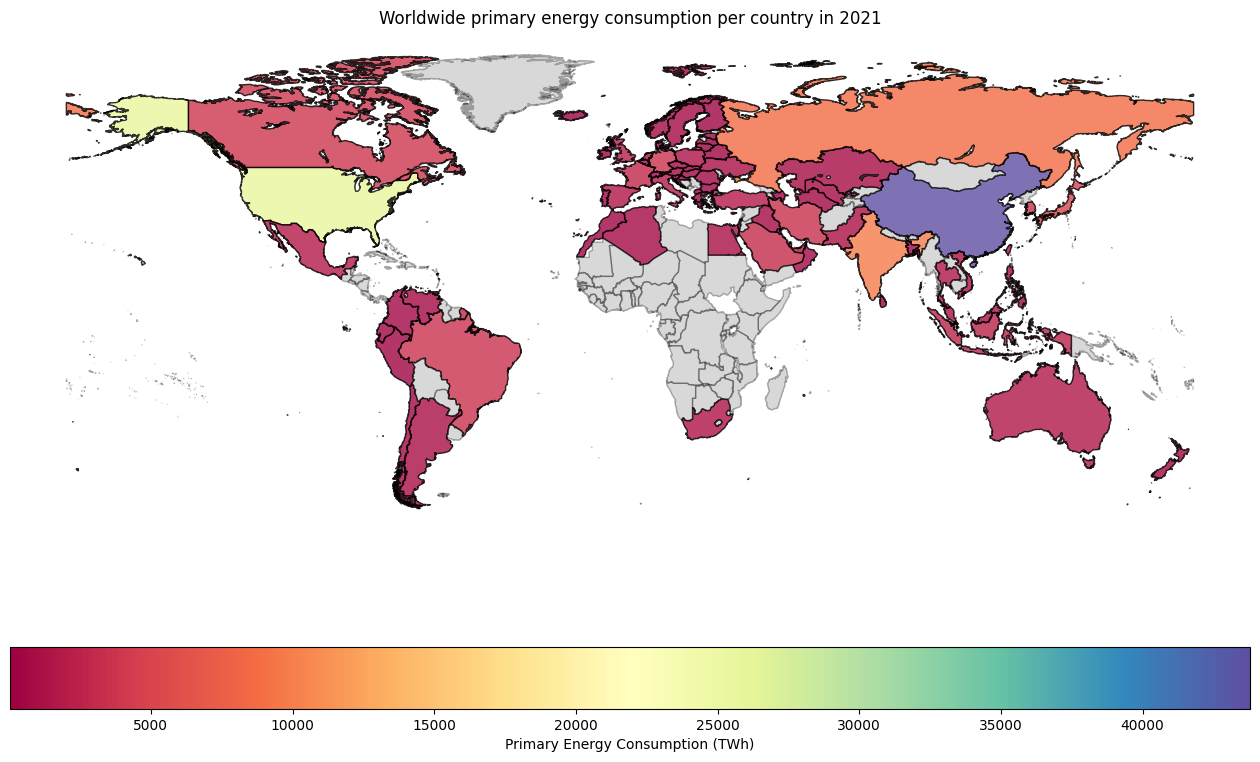

In [42]:
# Figure 1: Worldwide primary energy consumption per country in the selected year

# Select year:
year = 2021

# Filter by year:
owid_energy_data_year = owid_energy_data[owid_energy_data['year']==year]

# Merge geographical data with energy data:
merged = gdf.merge(owid_energy_data_year[['iso_code','country','primary_energy_consumption','population']],
                   left_on='ADM0_A3', right_on='iso_code')

# Make figure:
ax = merged.plot(column=merged['primary_energy_consumption'],
                 cmap=cmap,
                 figsize=figsize, legend=True,
                 missing_kwds={"color":"grey","edgecolor":"black","alpha":0.3,"label":"Missing Values"},
                 legend_kwds={"label":"Primary Energy Consumption (TWh)","orientation":"horizontal"},
                 edgecolor="k",alpha=0.8)
ax.set_title('Worldwide primary energy consumption per country in '+str(year))
ax.set_axis_off()
plt.show()


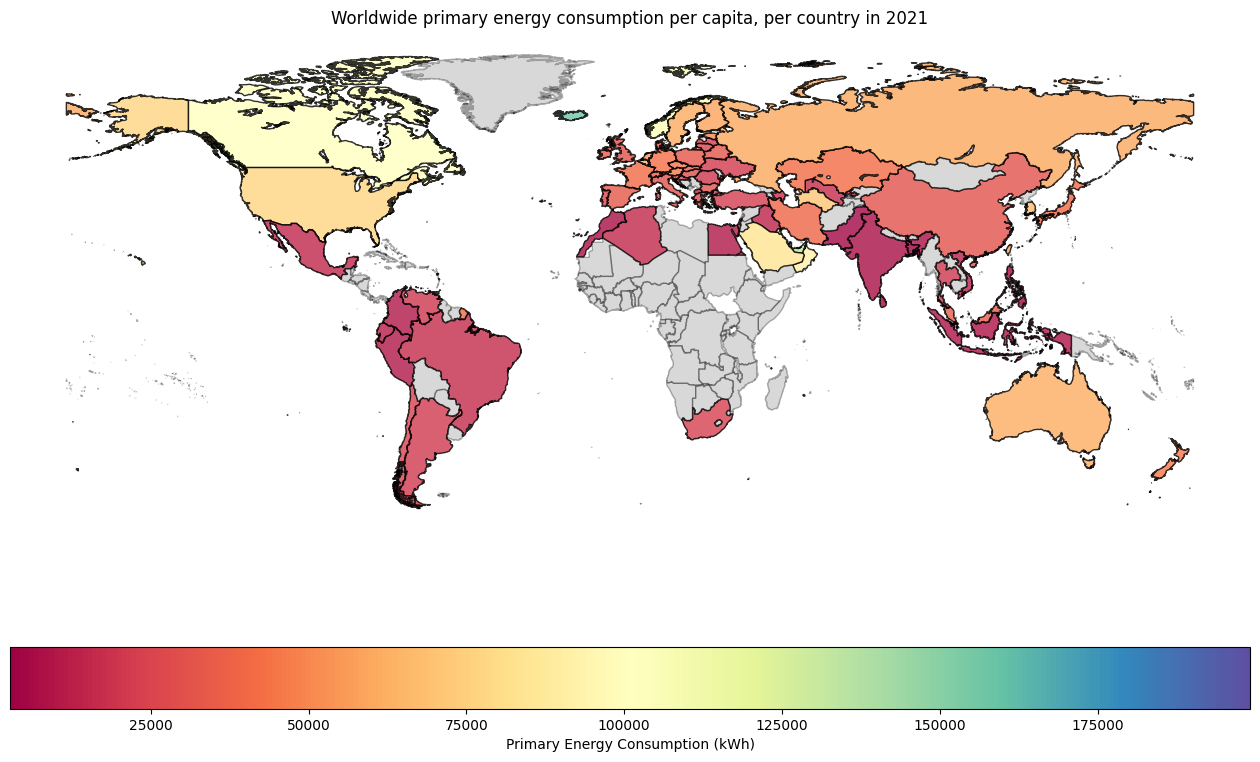

In [25]:
# Figure 2: Worldwide primary energy consumption per capita, per country in the selected year

# Make figure:

ax = merged.plot(column=1e9*merged['primary_energy_consumption']/merged['population'],
                 cmap=cmap,
                 figsize=figsize, legend=True,
                 missing_kwds={"color":"grey","edgecolor":"black","alpha":0.3,"label":"Missing Values"},
                 legend_kwds={"label":"Primary Energy Consumption (kWh)","orientation":"horizontal"},
                 edgecolor="k",alpha=0.8)
ax.set_title('Worldwide primary energy consumption per capita, per country in '+str(year))
ax.set_axis_off()
plt.show()


In [45]:
# Table 1: Top 10 energy consumers worldwide

print('Top 10 countries by primary energy consumption worldwide in '+str(year)+' (in MWh)')
merged = merged.sort_values('primary_energy_consumption',ascending=False)
merged.index = np.arange(1, len(merged) + 1)
merged[['country','primary_energy_consumption']].head(10)


Top 10 countries by primary energy consumption worldwide in 2021 (in MWh)


country  primary_energy_consumption
1           China                   43790.895
2   United States                   25825.461
3           India                    9841.214
4          Russia                    8693.623
5           Japan                    4927.854
6          Canada                    3871.156
7         Germany                    3511.587
8     South Korea                    3493.201
9          Brazil                    3490.447
10           Iran                    3386.192

In [47]:
# Table 1: Top 30 energy consumers per capita worldwide

print('Top 30 countries by primary energy consumption per capita worldwide in '+str(year) + ' (in kWh)')
merged['primary_energy_consumption_per_capita'] = 1e9*merged['primary_energy_consumption']/merged['population']
merged = merged.sort_values('primary_energy_consumption_per_capita',ascending=False)
merged.index = np.arange(1, len(merged) + 1)
merged[['country','primary_energy_consumption_per_capita']].head(30)


Top 30 countries by primary energy consumption per capita worldwide in 2021 (in kWh)


country  primary_energy_consumption_per_capita
1                  Qatar                          199137.799876
2              Singapore                          161620.403621
3                Iceland                          157653.278897
4   United Arab Emirates                          134316.923308
5                 Kuwait                          113650.208195
6    Trinidad and Tobago                          111894.373033
7                 Norway                          105148.212454
8                 Canada                          101458.649784
9                   Oman                           92127.949414
10          Saudi Arabia                           83635.406965
11         United States                           76633.953915
12          Turkmenistan                           70296.837674
13           South Korea                           67397.102720
14            Luxembourg                           65829.853127
15               Belgium                           65216.593738
16             Australia                           61297.181361
17                Sweden                           60610.226620
18                Russia                           59913.563872
19               Finland                           58140.543087
20                Taiwan                           57953.837534
21           Netherlands                           55146.141265
22               Estonia                           49581.396609
23               Austria                           46162.410898
24           New Zealand                           45563.411720
25               Czechia                           44337.377321
26               Germany                           42101.038550
27            Kazakhstan                           41235.137631
28                France                           40488.662210
29                 Japan                           39545.413925
30                  Iran                           38512.964326

As seen in the figures and tables, Germany was the 7th highest primary energy consumer worldwide in 2021, and 26th by primary energy consumption per capita. Germany consumed 3511.59 MWh of energy, equivalent to 42101.04 kWh per person, in 2021.

## 2.2 Germany's energy consumption in a European context<a name="2_2"></a>

In this subsection, Germany's recent energy consumption is put in an European context.

In [48]:
# Continental data looks better in a different size, so the figure size was re-defined.

figsize = (10, 10)


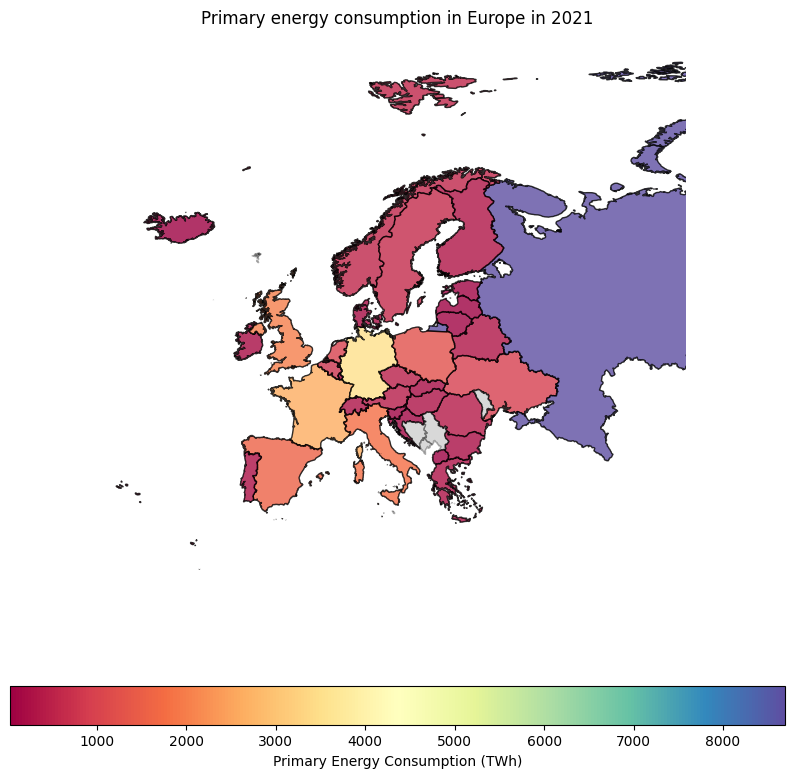

In [58]:
# Figure 3: Primary energy consumption in Europe in the selected year

# Select year:
year = 2021

# Filter by continent:
gdf_europe = (gdf[gdf['CONTINENT'] == 'Europe'])

# Filter by year:
owid_energy_data_year = owid_energy_data[owid_energy_data['year']==year]

# Merge geographical data with energy data:
merged = gdf_europe.merge(owid_energy_data_year[['iso_code','primary_energy_consumption','population','country']],
                          left_on='ADM0_A3', right_on='iso_code')

# Make figure:

ax = merged.plot(column=merged['primary_energy_consumption'],
                 cmap=cmap,
                 figsize=figsize, legend=True,
                 missing_kwds={"color":"grey","edgecolor":"black","alpha":0.3,"label":"Missing Values"},
                 legend_kwds={"label":"Primary Energy Consumption (TWh)","orientation":"horizontal"},
                 edgecolor="k",alpha=0.8)
ax.set_title('Primary energy consumption in Europe in '+str(year))
ax.set_xlim(-30,60)
ax.set_ylim(30,85)
ax.set_axis_off()
plt.show()


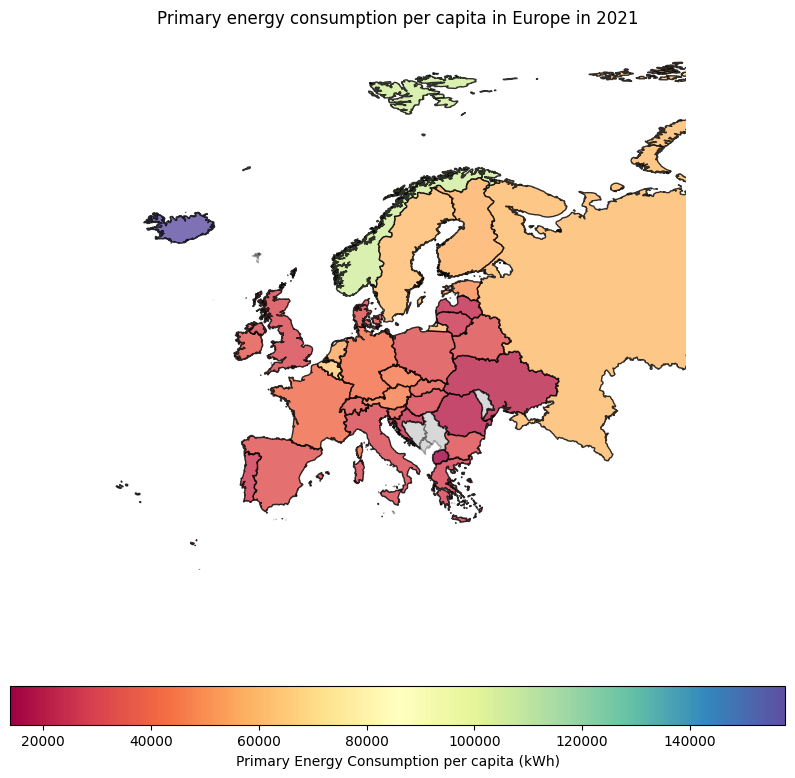

In [130]:
# Figure 4: Primary energy consumption per capita in Europe in the selected year

# Make figure:

ax = merged.plot(column=1e9*merged['primary_energy_consumption']/merged['population'],
                 cmap=cmap,
                 figsize=figsize, legend=True,
                 missing_kwds={"color":"grey","edgecolor":"black","alpha":0.3,"label":"Missing Values"},
                 legend_kwds={"label":"Primary Energy Consumption per capita (kWh)","orientation":"horizontal"},
                 edgecolor="k",alpha=0.8)
ax.set_title('Primary energy consumption per capita in Europe in '+str(year))
ax.set_xlim(-30,60)
ax.set_ylim(30,85)
ax.set_axis_off()


In [59]:
# Table 3: Top 10 energy consumers in Europe

print('Top 10 countries by primary energy consumption in Europe in '+str(year)+' (in MWh)')
merged = merged.sort_values('primary_energy_consumption',ascending=False)
merged.index = np.arange(1, len(merged) + 1)
merged[['country','primary_energy_consumption']].head(10)


Top 10 countries by primary energy consumption in Europe in 2021 (in MWh)


country  primary_energy_consumption
1           Russia                    8693.623
2          Germany                    3511.587
3           France                    2612.792
4   United Kingdom                    1994.278
5            Italy                    1765.336
6            Spain                    1553.231
7           Poland                    1233.894
8      Netherlands                     965.151
9          Ukraine                     926.315
10         Belgium                     757.257

In [62]:
# Table 1: Top 15 energy consumers per capita in Europe

print('Top 10 countries by primary energy consumption per capita in Europe in '+str(year) + ' (in kWh)')
merged['primary_energy_consumption_per_capita'] = 1e9*merged['primary_energy_consumption']/merged['population']
merged = merged.sort_values('primary_energy_consumption_per_capita',ascending=False)
merged.index = np.arange(1, len(merged) + 1)
merged[['country','primary_energy_consumption_per_capita']].head(15)


Top 10 countries by primary energy consumption per capita in Europe in 2021 (in kWh)


country  primary_energy_consumption_per_capita
1       Iceland                          157653.278897
2        Norway                          105148.212454
3    Luxembourg                           65829.853127
4       Belgium                           65216.593738
5        Sweden                           60610.226620
6        Russia                           59913.563872
7       Finland                           58140.543087
8   Netherlands                           55146.141265
9       Estonia                           49581.396609
10      Austria                           46162.410898
11      Czechia                           44337.377321
12      Germany                           42101.038550
13       France                           40488.662210
14     Slovakia                           36195.983531
15     Slovenia                           35382.993742

As seen in the figures and tables, Germany was the 2nd highest primary energy consumer in Europe in 2021, and 12th by primary energy consumption per capita. Within Europe and worldwide, Germany is amongst the top energy consumers.

## 2.3 History of Germany's energy consumtpion and electricity production<a name="2_3"></a>

In this subsection, Germany's history of primary energy consumption and electricity generation in the 20th and 21st centuries are analysed.

In [63]:
# Filter historical data by country:

owid_germany = owid_energy_data[owid_energy_data['country']=='Germany']
del(owid_germany['country'])
del(owid_germany['iso_code'])
owid_germany


year  population           gdp  biofuel_cons_change_pct   
7609  1900  55185341.0  2.587781e+11                      NaN  \
7610  1901  55981081.0  2.526593e+11                      NaN   
7611  1902  56801719.0  2.586955e+11                      NaN   
7612  1903  57647806.0  2.731376e+11                      NaN   
7613  1904  58506492.0  2.840587e+11                      NaN   
...    ...         ...           ...                      ...   
7727  2018  82896696.0  3.885961e+12                    4.234   
7728  2019  83148144.0           NaN                   -1.705   
7729  2020  83328992.0           NaN                   22.111   
7730  2021  83408560.0           NaN                  -11.925   
7731  2022  83369840.0           NaN                      NaN   

      biofuel_cons_change_twh  biofuel_cons_per_capita  biofuel_consumption   
7609                      NaN                      NaN                  NaN  \
7610                      NaN                      NaN                  NaN   
7611                      NaN                      NaN                  NaN   
7612                      NaN                      NaN                  NaN   
7613                      NaN                      NaN                  NaN   
...                       ...                      ...                  ...   
7727                    1.329                  394.683               32.718   
7728                   -0.558                  386.781               32.160   
7729                    7.111                  471.277               39.271   
7730                   -4.683                  414.680               34.588   
7731                      NaN                      NaN                  NaN   

      biofuel_elec_per_capita  biofuel_electricity  biofuel_share_elec  ...   
7609                      NaN                  NaN                 NaN  ...  \
7610                      NaN                  NaN                 NaN  ...   
7611                      NaN                  NaN                 NaN  ...   
7612                      NaN                  NaN                 NaN  ...   
7613                      NaN                  NaN                 NaN  ...   
...                       ...                  ...                 ...  ...   
7727                  612.690                50.79               8.027  ...   
7728                  602.900                50.13               8.362  ...   
7729                  611.192                50.93               8.978  ...   
7730                  562.412                46.91               8.057  ...   
7731                  567.351                47.30               8.113  ...   

      solar_share_elec  solar_share_energy  wind_cons_change_pct   
7609               NaN                 NaN                   NaN  \
7610               NaN                 NaN                   NaN   
7611               NaN                 NaN                   NaN   
7612               NaN                 NaN                   NaN   
7613               NaN                 NaN                   NaN   
...                ...                 ...                   ...   
7727             6.869               3.032                 4.029   
7728             7.403               3.166                14.500   
7729             8.726               3.722                 4.931   
7730             8.474               3.651               -10.902   
7731            10.117                 NaN                   NaN   

      wind_cons_change_twh  wind_consumption  wind_elec_per_capita   
7609                   NaN               NaN                   NaN  \
7610                   NaN               NaN                   NaN   
7611                   NaN               NaN                   NaN   
7612                   NaN               NaN                   NaN   
7613                   NaN               NaN                   NaN   
...                    ...               ...                   ...   
7727                

In [65]:
# Table 5: Pandas statistical description of Germany's historical energy data

owid_germany.describe()


year    population           gdp  biofuel_cons_change_pct   
count   123.000000  1.230000e+02  1.190000e+02                29.000000  \
mean   1961.000000  7.295022e+07  1.310497e+12                36.941966   
std      35.651087  7.719998e+06  1.099046e+12                86.429096   
min    1900.000000  5.518534e+07  2.285721e+11               -12.259000   
25%    1930.500000  6.652971e+07  3.638365e+11                 0.094000   
50%    1961.000000  7.360435e+07  8.238385e+11                11.093000   
75%    1991.500000  8.000350e+07  2.012769e+12                43.285000   
max    2022.000000  8.340856e+07  3.885961e+12               459.859000   

       biofuel_cons_change_twh  biofuel_cons_per_capita  biofuel_consumption   
count                31.000000                32.000000            32.000000  \
mean                  1.115677               221.766031            18.178094   
std                   3.395558               188.962270            15.514590   
min                  -4.683000                 0.000000             0.000000   
25%                   0.015000                12.274750             1.000500   
50%                   0.310000               310.083000            25.359000   
75%                   1.787000               390.802750            31.889250   
max                  11.859000               471.277000            39.271000   

       biofuel_elec_per_capita  biofuel_electricity  biofuel_share_elec  ...   
count                33.000000            33.000000           33.000000  ...  \
mean                287.968121            23.659091            3.870273  ...   
std                 247.624508            20.458973            3.317154  ...   
min                  20.159000             1.600000            0.293000  ...   
25%                  37.535000             3.060000            0.554000  ...   
50%                 233.315000            18.940000            3.007000  ...   
75%                 562.412000            46.910000            7.789000  ...   
max                 618.597000            50.930000            8.978000  ...   

       solar_share_elec  solar_share_energy  wind_cons_change_pct   
count         38.000000           57.000000             35.000000  \
mean           2.180289            0.556982             50.465514   
std            3.174000            1.095573             69.797755   
min            0.000000            0.000000            -10.902000   
25%            0.002000            0.000000              5.838000   
50%            0.071500            0.000000             29.341000   
75%            4.747750            0.228000             51.424500   
max           10.117000            3.722000            300.000000   

       wind_cons_change_twh  wind_consumption  wind_elec_per_capita   
count             56.000000         57.000000             58.000000  \
mean               5.499696         61.020333            294.500379   
std               15.182408         97.482199            466.967122   
min              -38.955000          0.000000              0.000000   
25%                0.000000          0.000000              0.000000   
50%                0.069500          1.774000             12.997500   
75%                4.515000        106.990000            482.335250   
max               67.320000        346.938000           1585.283000   

       wind_electricity  wind_energy_per_capita  wind_share_elec   
count         58.000000               57.000000        38.000000  \
mean          24.260121              741.796895         6.084632   
std           38.711999             1177.635711         7.102381   
min            0.000000                0.000000         0.000000   
25%            0.000000                0.000000         0.284250   
50%            1.050000               22.020000         3.716000   
75%           39.202500             1315.587000         8.349500   
max          132.100000             4163.474000        23.287000   

       wind_share_ene

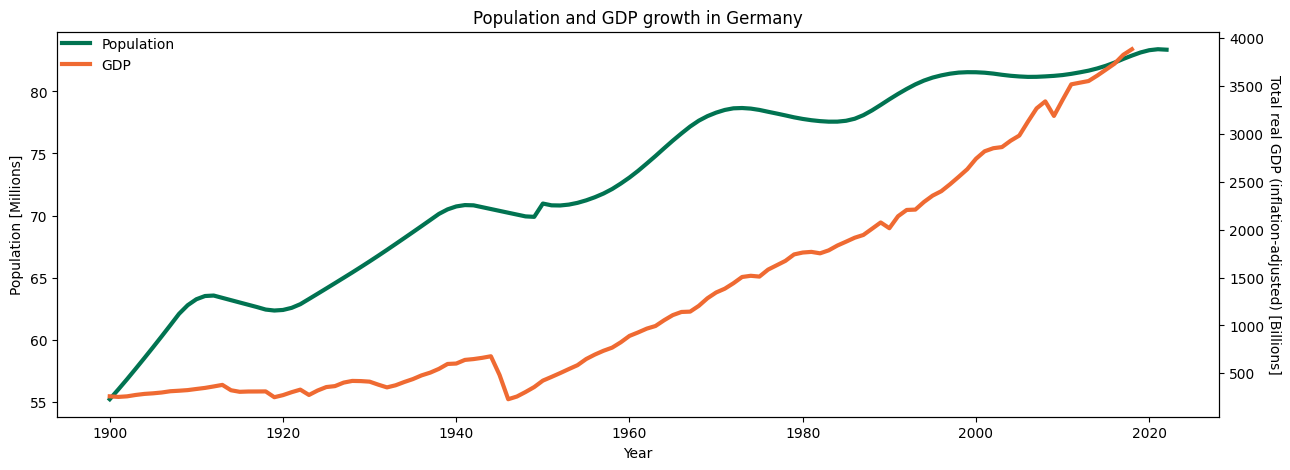

In [110]:
# Figure 5: Population and GDP growth in Germany since 1900

fig, ax1 = plt.subplots(figsize=(15.,5.))
ax2 = ax1.twinx()

line1 = ax1.plot(owid_germany['year'],owid_germany['population']/1e6, c=colors[0],lw=3,label='Population')
line2 = ax2.plot(owid_germany['year'],owid_germany['gdp']/1e9,c=colors[3],lw=3,label='GDP')

ax1.set_xlabel('Year')

ax1.set_ylabel('Population [Millions]')
ax2.set_ylabel('Total real GDP (inflation-adjusted) [Billions]',rotation=270,labelpad=12)

lines = line1 + line2
labs = [l.get_label() for l in lines]
ax1.legend(lines, labs, loc='upper left', borderaxespad=0.,frameon=False)
plt.title('Population and GDP growth in Germany')

plt.show()


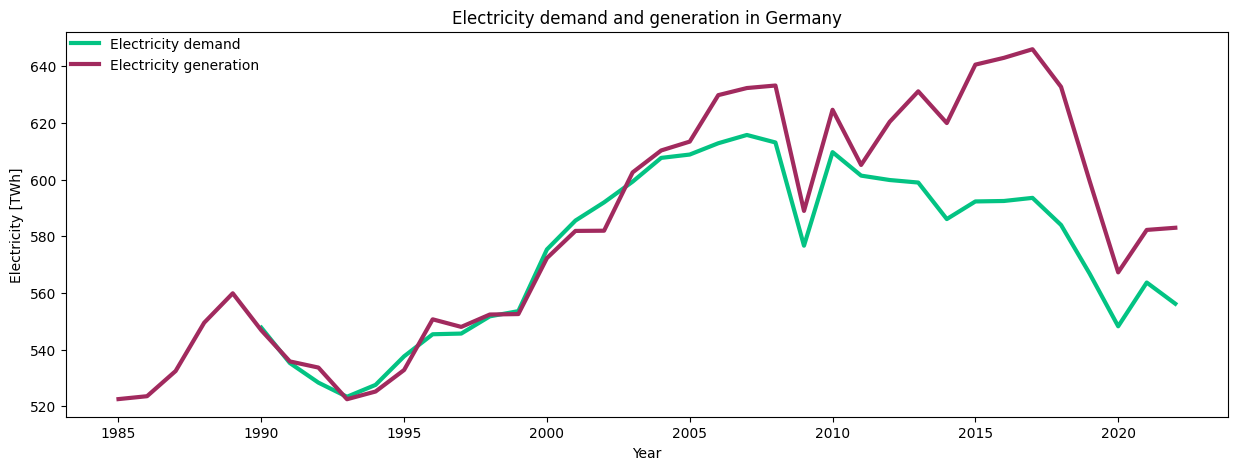

In [117]:
# Figure 6: Electricity demand and generation in Germany

fig, ax = plt.subplots(figsize=(15.,5.))

ax.plot(owid_germany['year'],owid_germany['electricity_demand'],label='Electricity demand',c=colors[1],lw=3)
ax.plot(owid_germany['year'],owid_germany['electricity_generation'],label='Electricity generation',c=colors[6],lw=3)

ax.set_xlabel('Year')
ax.set_ylabel('Electricity [TWh]')

plt.title('Electricity demand and generation in Germany')
plt.legend(loc='best', borderaxespad=0.,frameon=False)

plt.show()


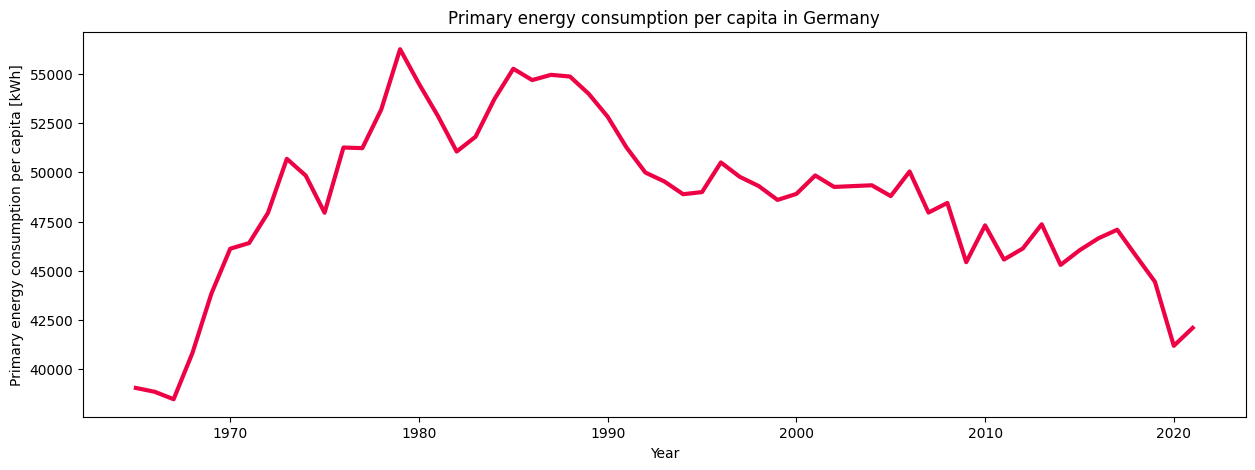

In [127]:
# Figure 7: Primary energy consumption per capita in Germany

fig, ax = plt.subplots(figsize=(15.,5.))

ax.plot(owid_germany['year'],1e9*(owid_germany['primary_energy_consumption']/owid_germany['population']),
        lw=3,c=colors[4])

ax.set_ylabel('Primary energy consumption per capita [kWh]')
ax.set_xlabel('Year')

plt.title('Primary energy consumption per capita in Germany')

plt.show()


In [140]:
# Filter dataframe by relevant energy consumption columns and define labels for figures
# Note: columns are sorted from highest to lowest value in 2021

consumption_cols = ['biofuel_consumption','wind_consumption','oil_consumption','coal_consumption',
                    'solar_consumption','hydro_consumption','gas_consumption','other_renewable_consumption',
                    'nuclear_consumption']
consumption_cols = sorted(consumption_cols, key=lambda x: owid_germany[x].values[-2],reverse=True)
consumption_labels = [' '.join(x.split('_')[:-1]) for x in consumption_cols]


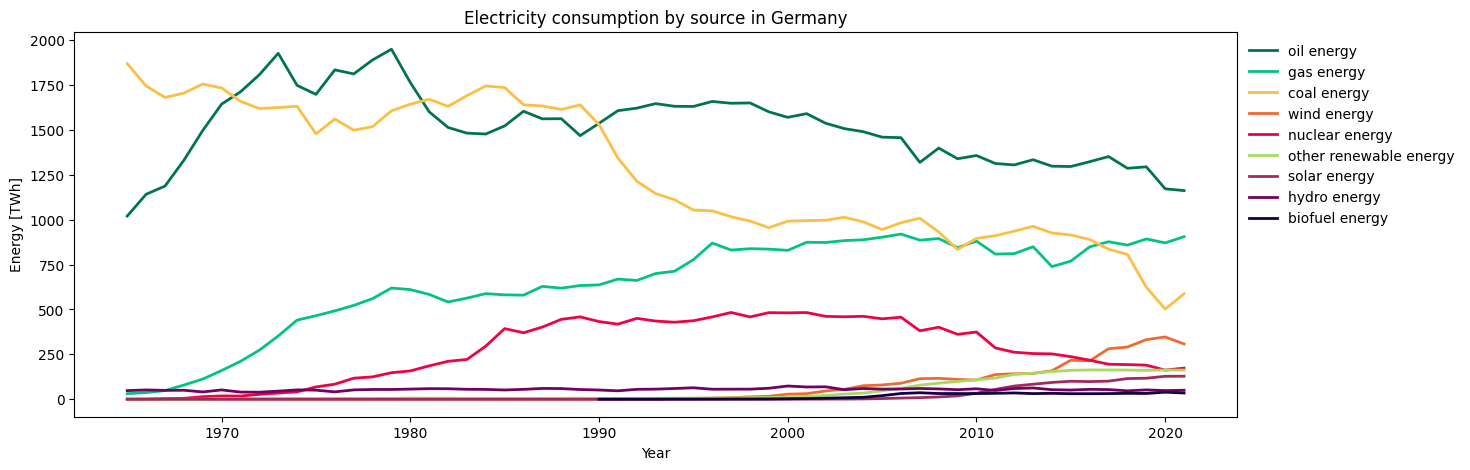

In [128]:
# Figure 8: Energy consumption by source in Germany

fig, ax = plt.subplots(figsize=(15.,5.))
clrs = iter(colors)

for source,label in zip(consumption_cols,consumption_labels):
    c=next(clrs)
    ax.plot(owid_germany['year'],owid_germany[source],label=label+' energy',c=c,lw=2)

ax.set_xlabel('Year')
ax.set_ylabel('Energy [TWh]')

plt.title('Energy consumption by source in Germany')
plt.legend(bbox_to_anchor=(1, 1),frameon=False)

plt.show()

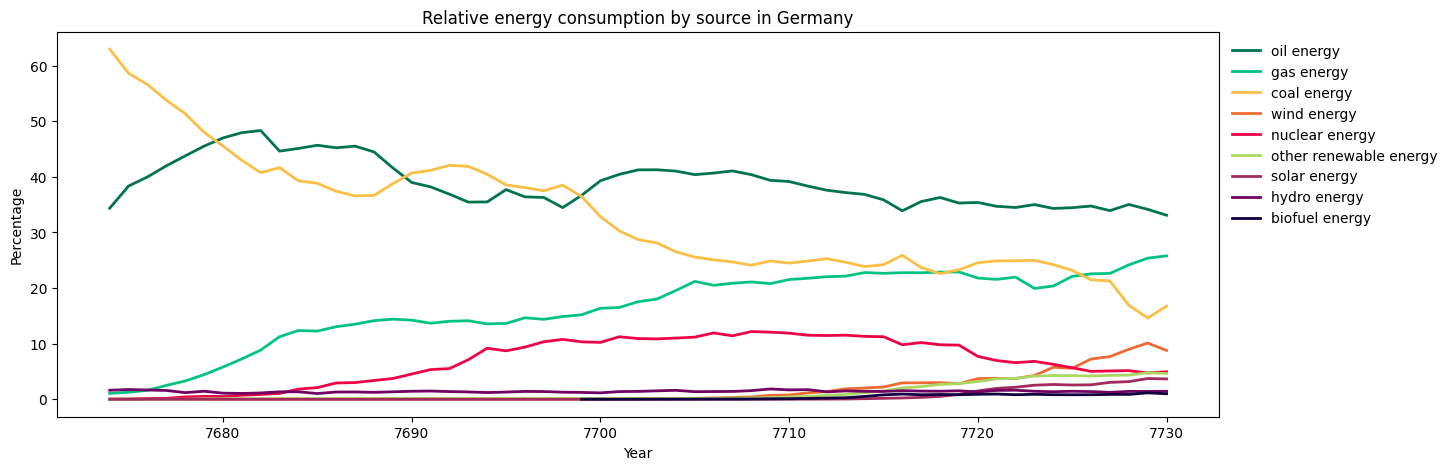

In [131]:
# Figure 9: Relative energy consumption by source in Germany

fig, ax = plt.subplots(figsize=(15.,5.))
clrs = iter(colors)

for source,label in zip(consumption_cols,consumption_labels):
    c=next(clrs)
    ax.plot(owid_germany.index,100.*owid_germany[source]/owid_germany['primary_energy_consumption'],
            label=label+' energy',c=c,lw=2)

ax.set_xlabel('Year')
ax.set_ylabel('Percentage')

plt.title('Relative energy consumption by source in Germany')
plt.legend(bbox_to_anchor=(1, 1),frameon=False)

plt.show()

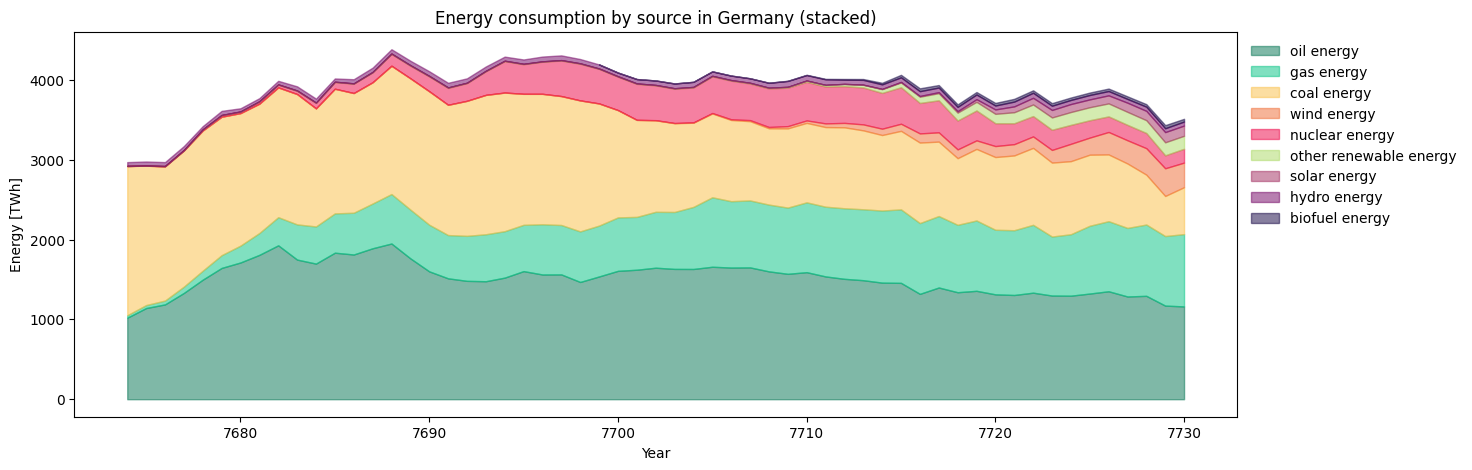

In [136]:
# Figure 10: Energy consumption by source in Germany (stacked)

fig, ax = plt.subplots(figsize=(15.,5.))
clrs = iter(colors)

y = np.zeros(len(owid_germany.index))
for source,label in zip(consumption_cols,consumption_labels):
    c=next(clrs)
    yp = np.copy(y)
    y += owid_germany[source].values
    ax.fill_between(owid_germany.index,yp,y,label=label+' energy',alpha=0.5,color=c)

ax.set_xlabel('Year')
ax.set_ylabel('Energy [TWh]')

plt.title('Energy consumption by source in Germany (stacked)')
plt.legend(bbox_to_anchor=(1.2, 1),frameon=False)

plt.show()


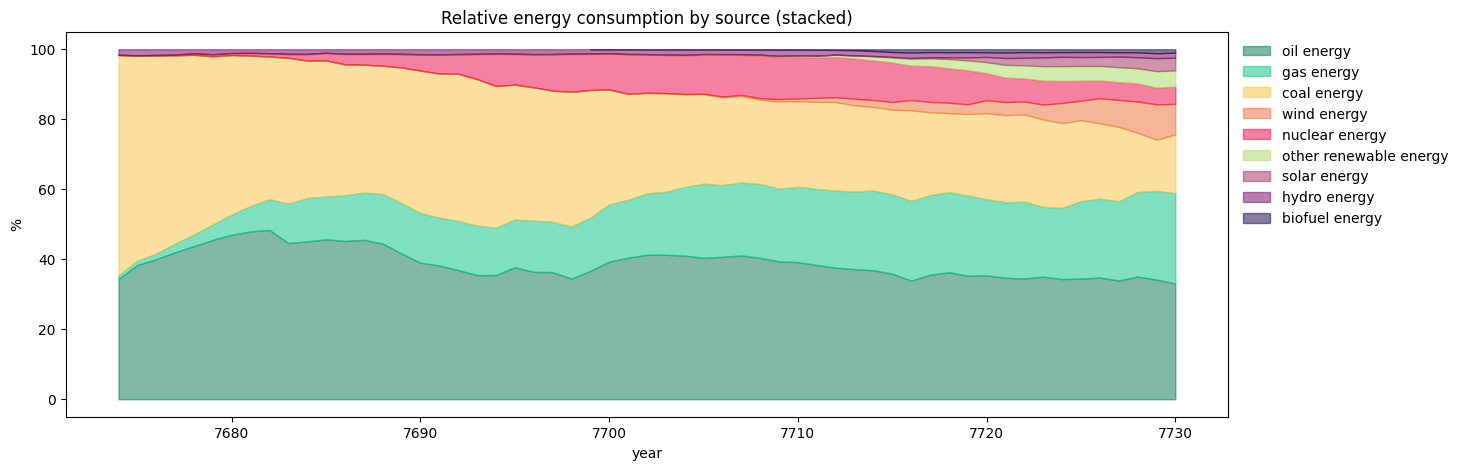

In [137]:
# Figure 11: Relative energy consumption by source in Germany (stacked)

fig, ax = plt.subplots(figsize=(15.,5.))
clrs = iter(colors)

y = np.zeros(len(owid_germany.index))
for source,label in zip(consumption_cols,consumption_labels):
    c=next(clrs)
    yp = np.copy(y)
    y += 100.*owid_germany[source].values/owid_germany['primary_energy_consumption'].values
    ax.fill_between(owid_germany.index,yp,y,label=label+' energy',alpha=0.5,color=c)
ax.set_xlabel('year')
ax.set_ylabel('%')

plt.title('Relative energy consumption by source (stacked)')
plt.legend(bbox_to_anchor=(1.2, 1),frameon=False)

plt.show()

In [141]:
# Filter dataframe by relevant electricity generation columns and define labels for figures
# Note: columns are sorted from highest to lowest value in 2021

electricity_cols = ['coal_electricity', 'wind_electricity', 'gas_electricity', 'nuclear_electricity',
                    'solar_electricity', 'other_renewable_exc_biofuel_electricity', 'biofuel_electricity',
                    'oil_electricity', 'hydro_electricity']
electricity_cols = sorted(electricity_cols, key=lambda x: owid_germany[x].values[-2],reverse=True)
electricity_labels = [' '.join(x.split('_')[:-1]) for x in electricity_cols]


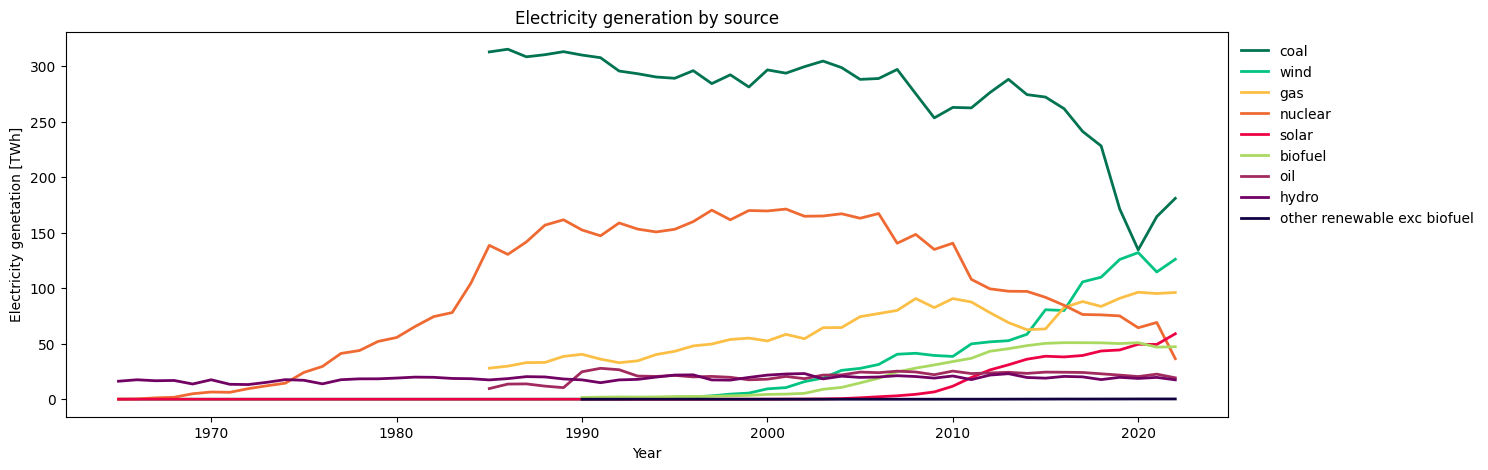

In [143]:
# Figure 12: Electricity generation by source in Germany

fig, ax = plt.subplots(figsize=(15.,5.))
clrs = iter(colors)

for source,label in zip(electricity_cols,electricity_labels):
    c=next(clrs)
    ax.plot(owid_germany['year'],owid_germany[source],label=label,c=c,lw=2)

ax.set_xlabel('Year')
ax.set_ylabel('Electricity genetation [TWh]')

plt.title('Electricity generation by source')
plt.legend(bbox_to_anchor=(1, 1),frameon=False)

plt.show()


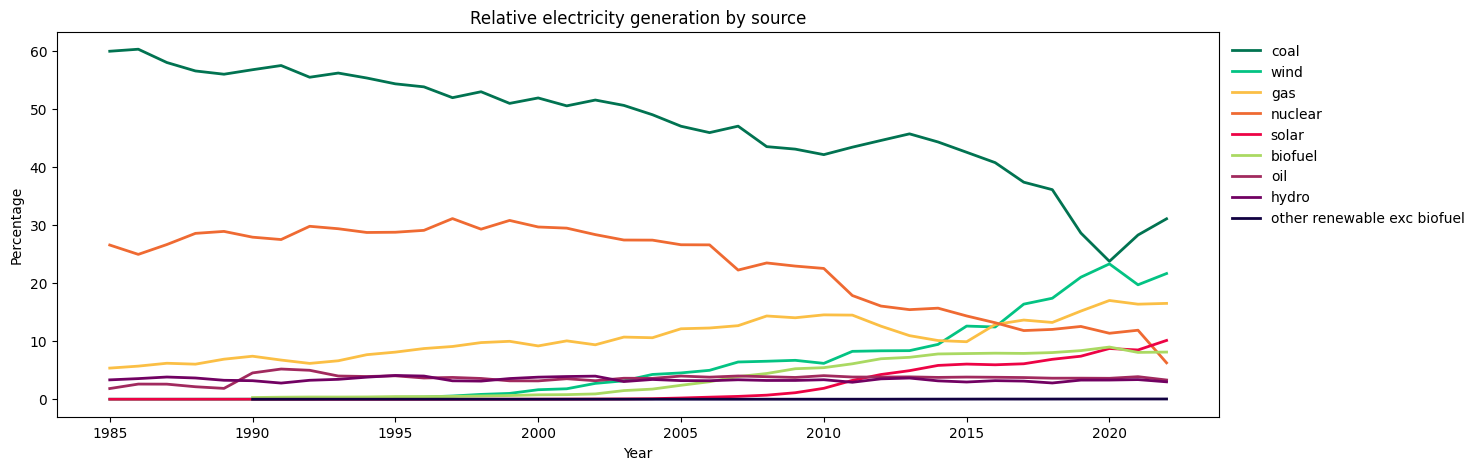

In [145]:
# Figure 13: Relative electricity generation by source in Germany

fig, ax = plt.subplots(figsize=(15.,5.))
clrs = iter(colors)

for source,label in zip(electricity_cols,electricity_labels):
    c=next(clrs)
    ax.plot(owid_germany['year'],100.*owid_germany[source]/owid_germany['electricity_generation'],
            label=label,c=c,lw=2)

ax.set_xlabel('Year')
ax.set_ylabel('Percentage')

plt.title('Relative electricity generation by source')
plt.legend(bbox_to_anchor=(1, 1),frameon=False)

plt.show()


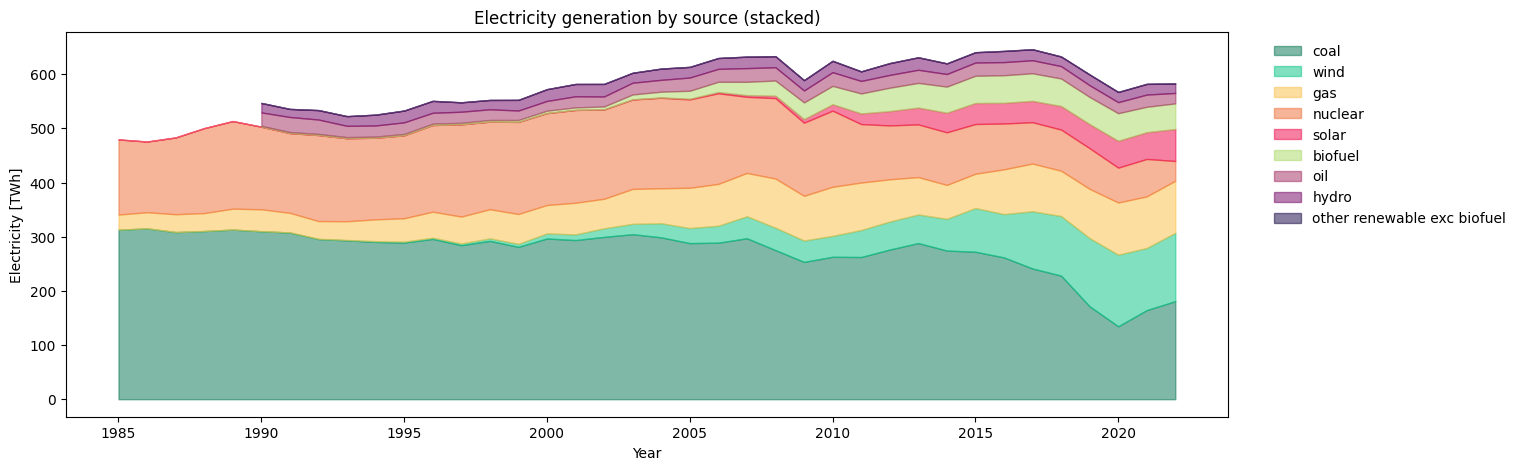

In [147]:
# Figure 13: Electricity generation by source in Germany (stacked)

fig, ax = plt.subplots(figsize=(15.,5.))
clrs = iter(colors)

y = np.zeros(len(owid_germany.index))
for source,label in zip(electricity_cols,electricity_labels):
    c=next(clrs)
    yp = np.copy(y)
    y += owid_germany[source].values
    ax.fill_between(owid_germany['year'],yp,y,label=label,alpha=0.5,color=c)

ax.set_xlabel('Year')
ax.set_ylabel('Electricity [TWh]')

plt.title('Electricity generation by source (stacked)')
plt.legend(bbox_to_anchor=(1.25, 1),frameon=False)

plt.show()

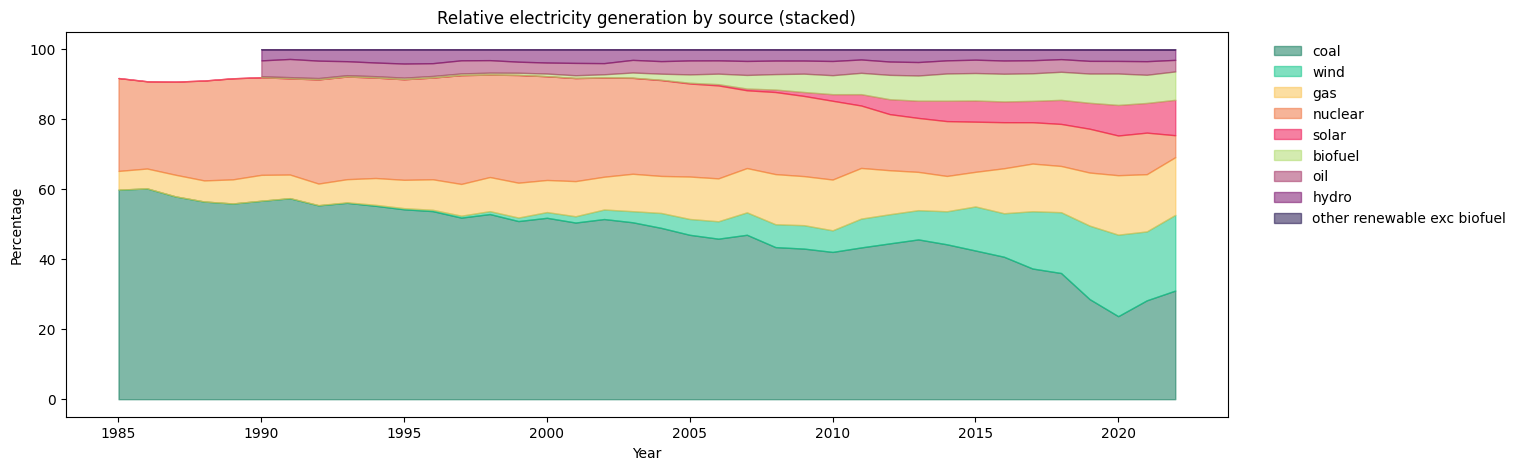

In [151]:
# Figure 13: Electricity generation by source in Germany (stacked)

fig, ax = plt.subplots(figsize=(15.,5.))
clrs = iter(colors)

y = np.zeros(len(owid_germany.index))
for source,label in zip(electricity_cols,electricity_labels):
    c = next(clrs)
    yp = np.copy(y)
    y += 100.*owid_germany[source].values / owid_germany['electricity_generation'].values
    ax.fill_between(owid_germany['year'],yp,y,label=label,alpha=0.5,color=c)
ax.set_xlabel('Year')
ax.set_ylabel('Percentage')

plt.title('Relative electricity generation by source (stacked)')
plt.legend(bbox_to_anchor=(1.25, 1),frameon=False)

plt.show()

Although energy consumption and generation (both in absolute value and per capita) have decreased since they reached their maximum value in previous decades, Germany remains one of the biggest producers of electricity and energy consumers in Europe and worldwide.

Germany is part of the Paris agreement, and aims to progressively reduce its electricity generation coming from non-renewable sources. Notably, in the last decade renewable energy sources such as wind and solar have begun to take over non-renewable sources such as coal and gas. However, Germany is also phasing out nuclear energy generation.

# 3. Electricity generation in Germany today<a name="3_0"></a>

In this Section, datasets regarding energy generation in Germany are analysed. Said datasets have a cadence of 15 minutes (as opposed to the yearly data presented in the previous sections), and it spans the period between 2020 and 2023. The data was acquired from the [entso-e transparency platform](https://transparency.entsoe.eu/dashboard/show), and it is free to use (CC-BY 4.0).

# 3.1 Sources of electricity genration<a name="3_1"></a>

In this subsection, we analyse the dataset described above.

In [3]:
# Loading the energy data from entso-e from Germany in 2023. 

ener_2023 = pd.read_csv('./Actual Generation per Production Type_202301010000-202401010000.csv',
                na_values=['-','n/e'])

# The dataframe index is set to be the time of the measurement, a datetime object

ener_2023['MTU'] = pd.to_datetime(ener_2023['MTU'].str.split().str[0] + ' '
                     + ener_2023['MTU'].str.split().str[1],
                    format = '%d.%m.%Y %H:%M')
ener_2023 = ener_2023.set_index('MTU')
ener_2023 = ener_2023[ener_2023.index<pd.to_datetime('2023-5-1')]

ener_2023

Area  Biomass  - Actual Aggregated [MW]   
MTU                                                                    
2023-01-01 00:00:00  Germany (DE)                             4377.0  \
2023-01-01 00:15:00  Germany (DE)                             4365.0   
2023-01-01 00:30:00  Germany (DE)                             4361.0   
2023-01-01 00:45:00  Germany (DE)                             4357.0   
2023-01-01 01:00:00  Germany (DE)                             4341.0   
...                           ...                                ...   
2023-04-30 22:45:00  Germany (DE)                             4636.0   
2023-04-30 23:00:00  Germany (DE)                             4644.0   
2023-04-30 23:15:00  Germany (DE)                             4650.0   
2023-04-30 23:30:00  Germany (DE)                             4659.0   
2023-04-30 23:45:00  Germany (DE)                             4637.0   

                     Fossil Brown coal/Lignite  - Actual Aggregated [MW]   
MTU                                                                        
2023-01-01 00:00:00                                             3851.0    \
2023-01-01 00:15:00                                             3853.0     
2023-01-01 00:30:00                                             3866.0     
2023-01-01 00:45:00                                             3867.0     
2023-01-01 01:00:00                                             3876.0     
...                                                                ...     
2023-04-30 22:45:00                                             9973.0     
2023-04-30 23:00:00                                             9863.0     
2023-04-30 23:15:00                                             9849.0     
2023-04-30 23:30:00                                             9830.0     
2023-04-30 23:45:00                                             9811.0     

                     Fossil Coal-derived gas  - Actual Aggregated [MW]   
MTU                                                                      
2023-01-01 00:00:00                                                NaN  \
2023-01-01 00:15:00                                                NaN   
2023-01-01 00:30:00                                                NaN   
2023-01-01 00:45:00                                                NaN   
2023-01-01 01:00:00                                                NaN   
...                                                                ...   
2023-04-30 22:45:00                                                NaN   
2023-04-30 23:00:00                                                NaN   
2023-04-30 23:15:00                                                NaN   
2023-04-30 23:30:00                                                NaN   
2023-04-30 23:45:00                                                NaN   

                     Fossil Gas  - Actual Aggregated [MW]   
MTU                                                         
2023-01-01 00:00:00                                2484.0  \
2023-01-01 00:15:00                                2461.0   
2023-01-01 00:30:00                                2472.0   
2023-01-01 00:45:00                                2456.0   
2023-01-01 01:00:00                                2295.0   
...                                                   ...   
2023-04-30 22:45:00                                4880.0   
2023-04-30 23:00:00                                4539.0   
2023-04-30 23:15:00                                4440.0   
2023-04-30 23:30:00                                4445.0   
2023-04-30 23:45:00                                4432.0   

                     Fossil Hard coal  - Actual Aggregated [MW]   
MTU                                                               
2023-01-01 00:00:00                                      2068.0  \
2023-01-01 00:15:00                                      2072.0   
2023-01-01 00:30:00                                      2068.0   
2023-01-01 

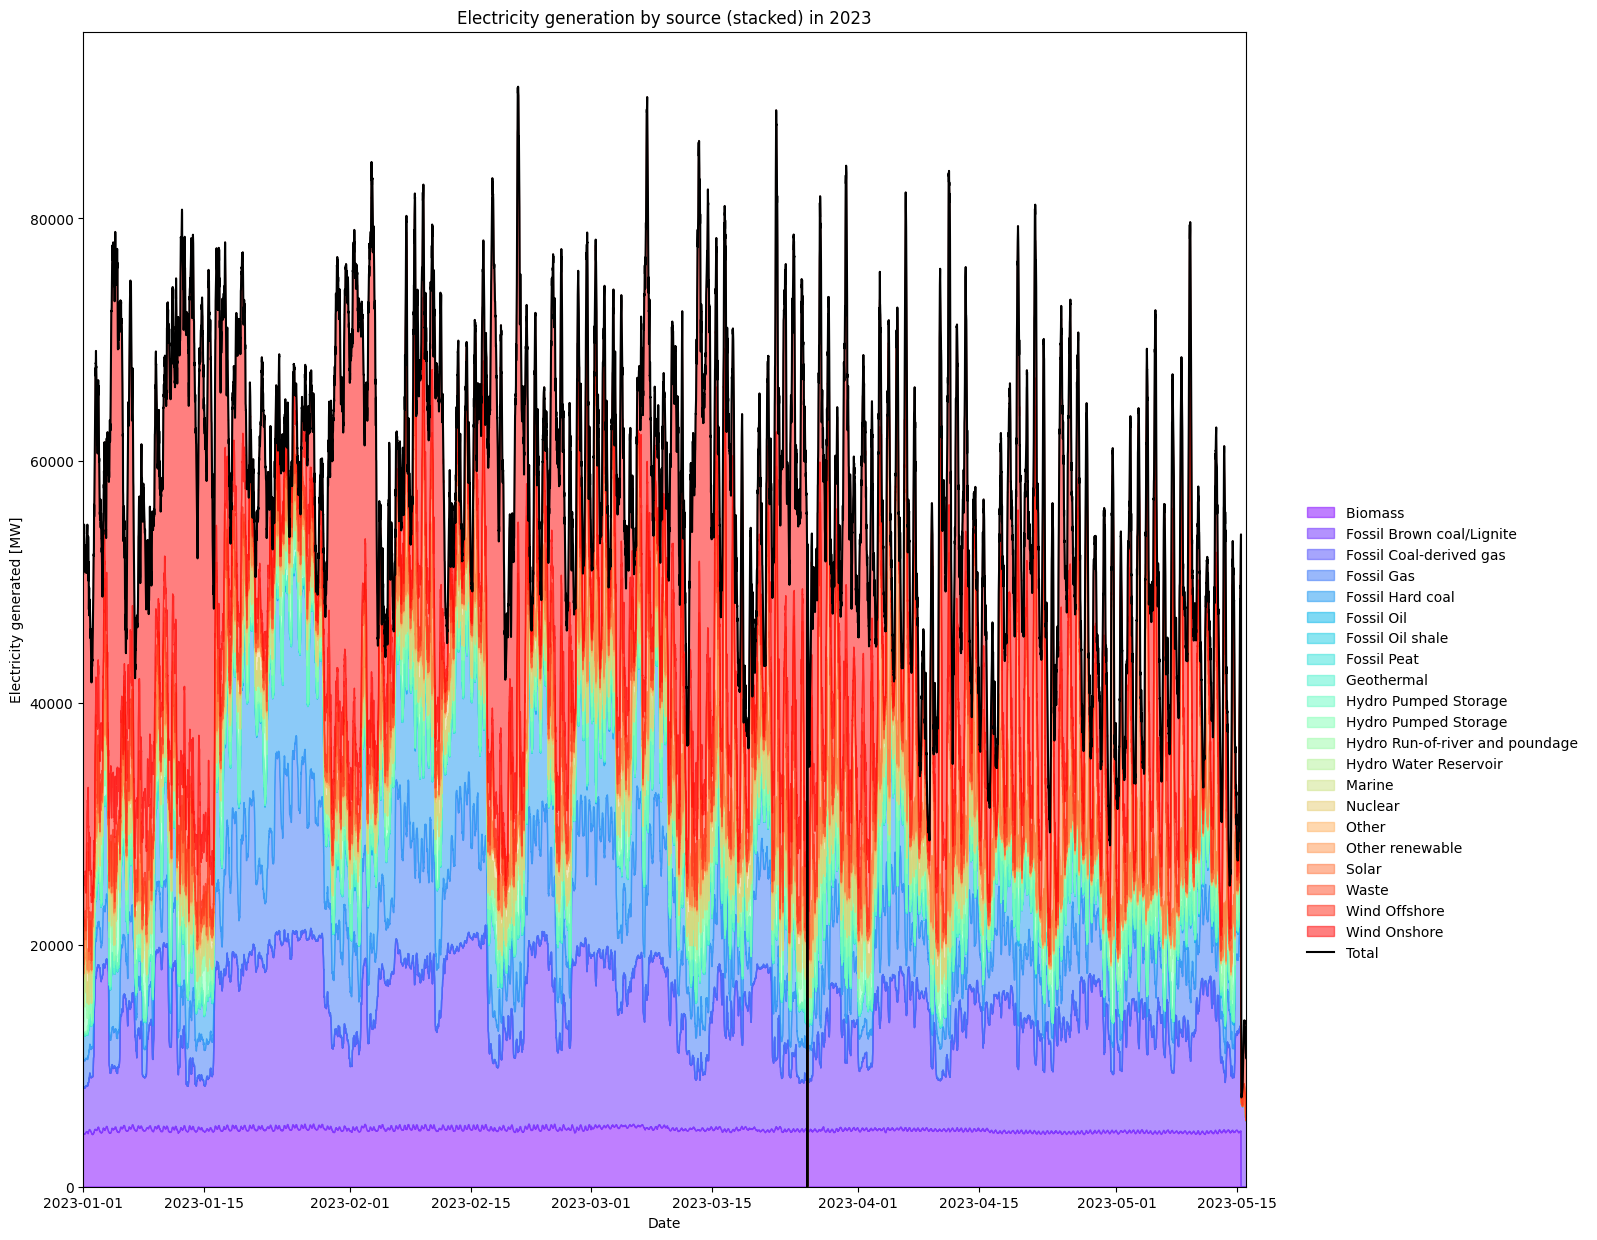

In [154]:
# Figure 14: Electricity generation by source in Germany in 2023 (stacked)

fig, ax = plt.subplots(figsize=(15.,15.))
color = iter(plt.cm.rainbow(np.linspace(0,1,21)))

y = np.zeros(len(ener_2023.index))
for col in ener_2023:
    if col!='Area':
        yp = np.copy(y)
        y += np.nan_to_num(ener_2023[col].values,0)
        label = col.split(' - ')[0]
        c=next(color)
        ax.fill_between(ener_2023.index,yp,y,label=label,alpha=0.5,color=c)
ax.set_xlim(datetime.date(2023, 1, 1),datetime.date(2023, 5, 16))
ax.set_ylim(0,)
ax.plot(ener_2023.index,y,c='black',label='Total')
ax.set_xlabel('Date')
ax.set_ylabel('Electricity generated [MW]')

plt.title('Electricity generation by source (stacked) in 2023')
plt.legend(bbox_to_anchor=(1.3, 0.6),frameon=False)

plt.show()

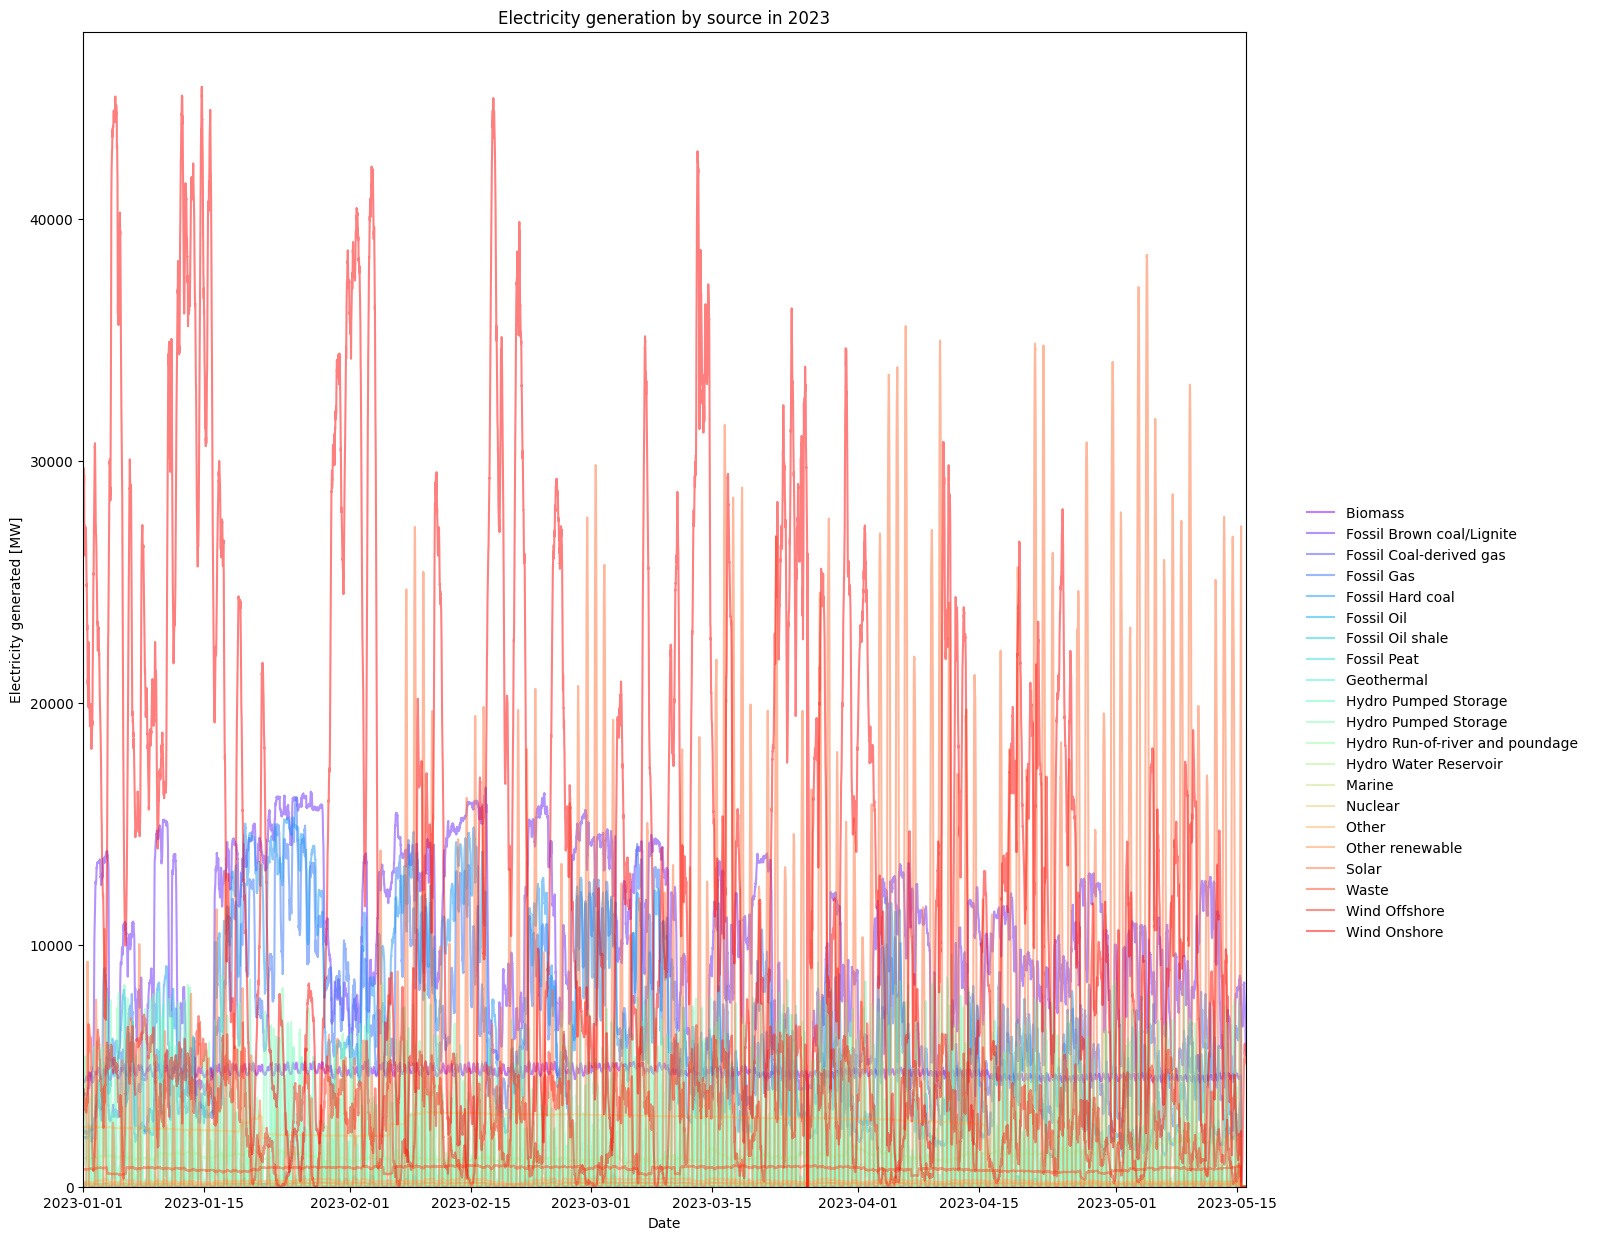

In [162]:
# Figure 15: Electricity generation by source in Germany in 2023

fig, ax = plt.subplots(figsize=(15.,15.))
color = iter(plt.cm.rainbow(np.linspace(0,1,21)))

for col in ener_2023:
    if col!='Area':
        label = col.split(' - ')[0]
        c=next(color)
        ax.plot(ener_2023.index,ener_2023[col],label=label,alpha=0.5,color=c)
ax.set_xlim(datetime.date(2023, 1, 1),datetime.date(2023, 5, 16))
ax.set_ylim(0,)
ax.set_xlabel('Date')
ax.set_ylabel('Electricity generated [MW]')

plt.title('Electricity generation by source in 2023')
plt.legend(bbox_to_anchor=(1.3, 0.6),frameon=False)

plt.show()

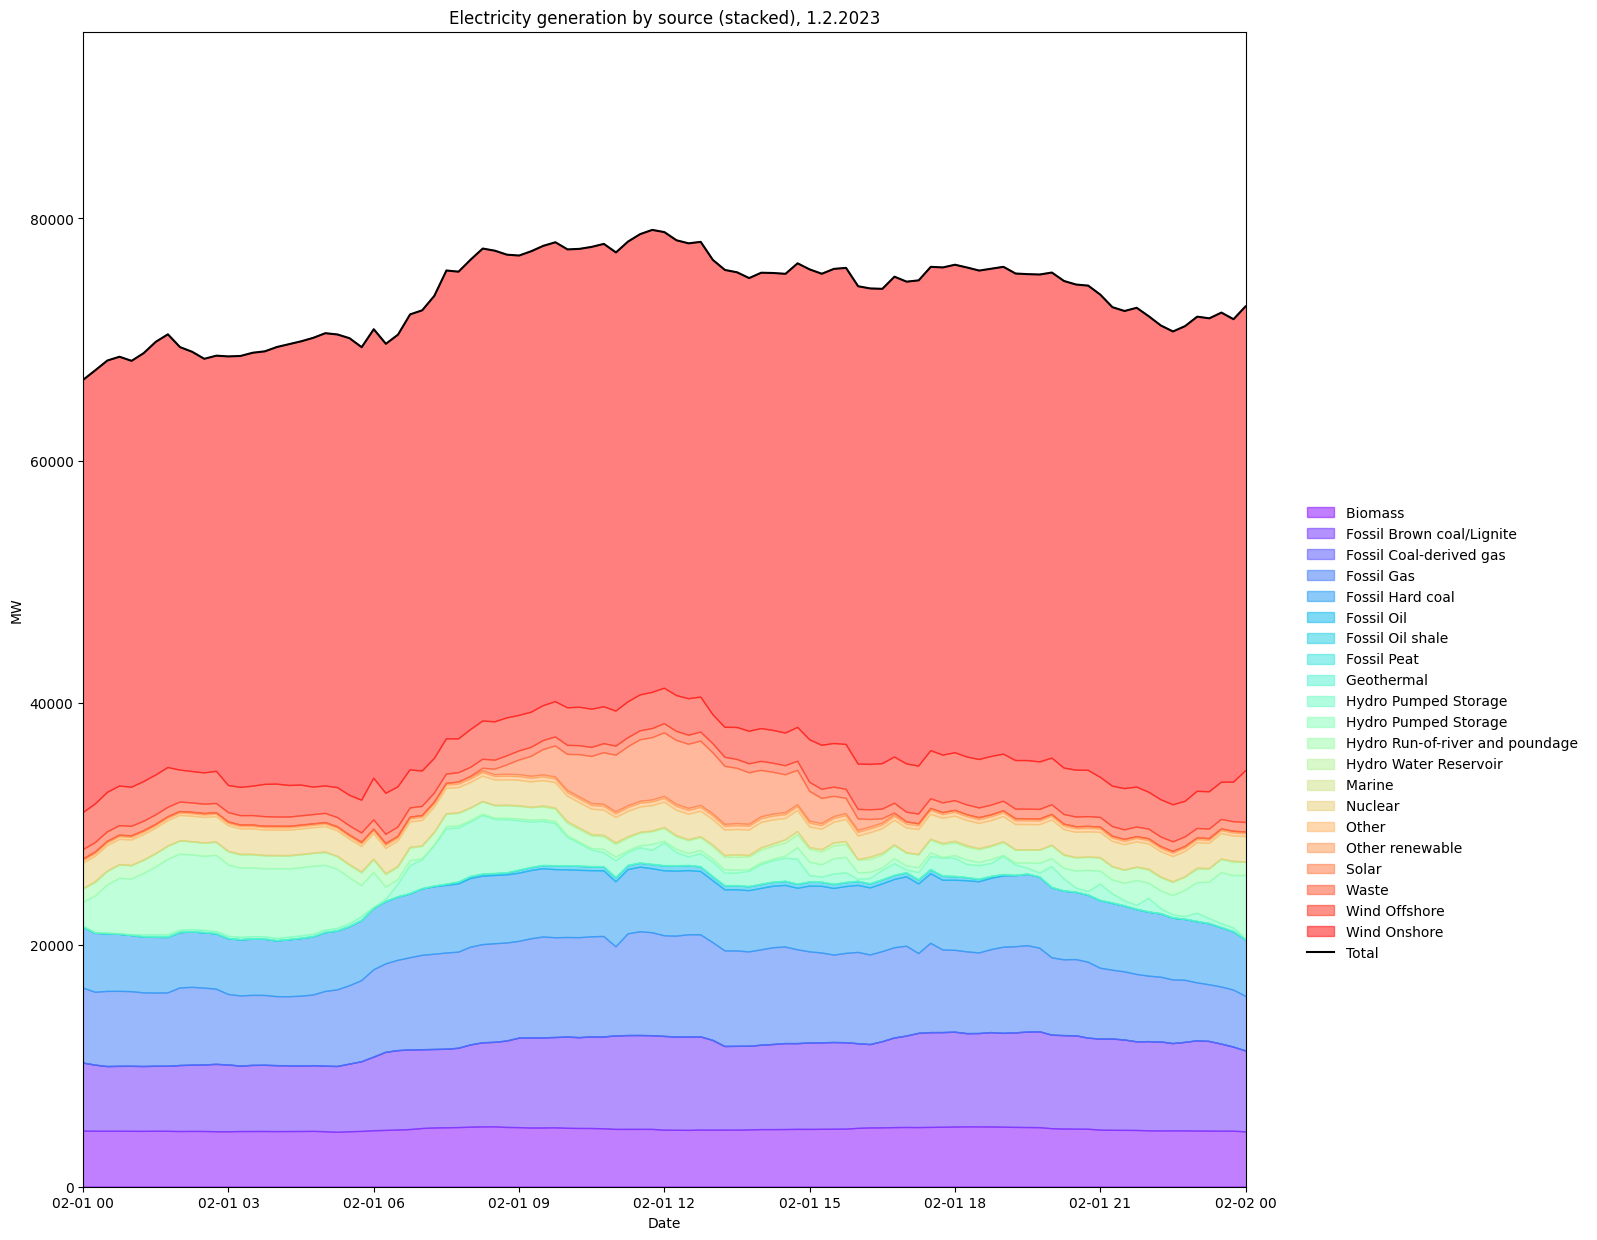

In [161]:
# Figure 16: Electricity generation by source in Germany in 1.2.2023 (stacked)

fig, ax = plt.subplots(figsize=(15.,15.))
color = iter(plt.cm.rainbow(np.linspace(0,1,21)))

y = np.zeros(len(ener_2023.index))
for col in ener_2023:
    if col!='Area':
        yp = np.copy(y)
        y += np.nan_to_num(ener_2023[col].values,0)
        label = col.split(' - ')[0]
        c=next(color)
        ax.fill_between(ener_2023.index,yp,y,label=label,alpha=0.5,color=c)
ax.set_xlim(datetime.date(2023, 2, 1),datetime.date(2023, 2, 2))
ax.set_ylim(0,)
ax.plot(ener_2023.index,y,c='black',label='Total')
ax.set_xlabel('Date')
ax.set_ylabel('MW')

plt.title('Electricity generation by source (stacked), 1.2.2023')
plt.legend(bbox_to_anchor=(1.3, 0.6),frameon=False)

plt.show()

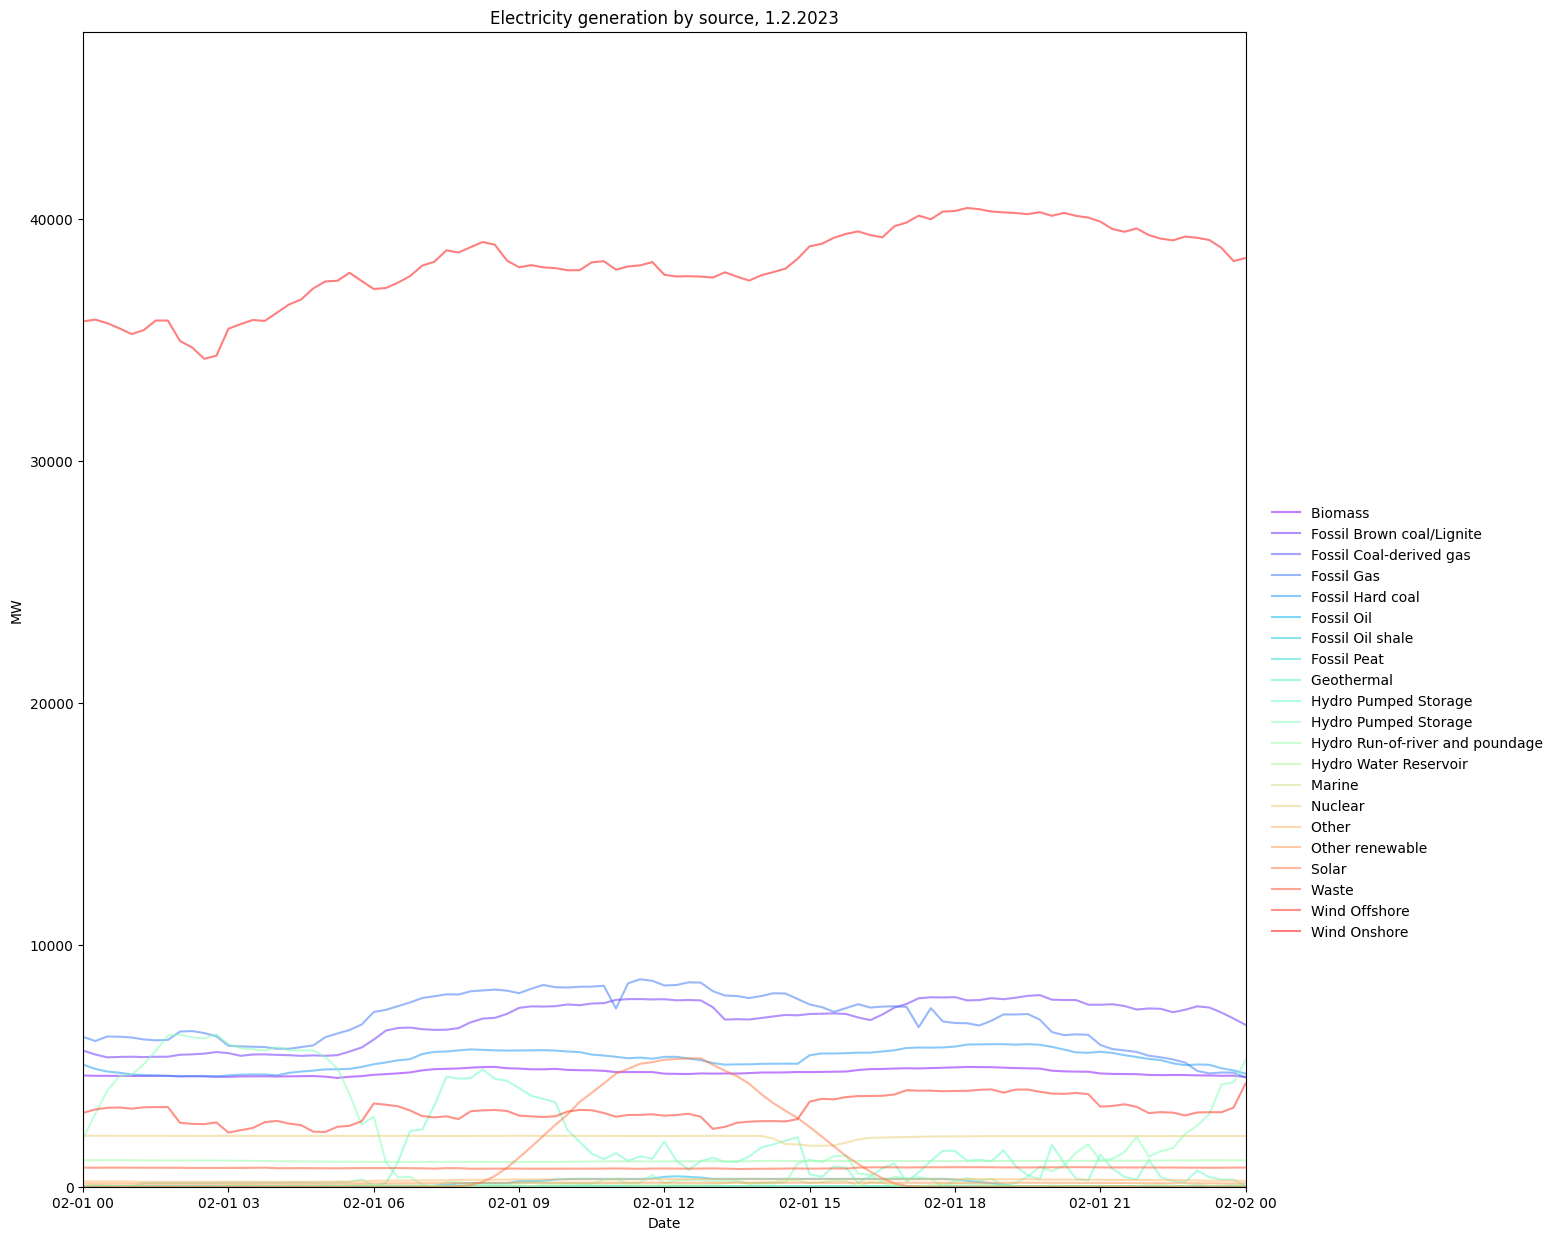

In [167]:
# Figure 16: Electricity generation by source in Germany in 1.2.2023

fig, ax = plt.subplots(figsize=(15.,15.))
color = iter(plt.cm.rainbow(np.linspace(0,1,21)))

for col in ener_2023:
    if col!='Area':
        label = col.split(' - ')[0]
        c=next(color)
        ax.plot(ener_2023.index,ener_2023[col],label=label,alpha=0.5,color=c)
ax.set_xlim(datetime.date(2023, 2, 1),datetime.date(2023, 2, 2))
ax.set_ylim(0,)
ax.set_xlabel('Date')
ax.set_ylabel('MW')

plt.title('Electricity generation by source, 1.2.2023')
plt.legend(bbox_to_anchor=(1.27, 0.6),frameon=False)

plt.show()

In [4]:
# Loading the energy data from entso-e from Germany in 2020-2022. 

ener_2022 = pd.read_csv('./Actual Generation per Production Type_202201010000-202301010000.csv',
                na_values=['-','n/e'])
ener_2022['MTU'] = pd.to_datetime(ener_2022['MTU'].str.split().str[0] + ' '
                     + ener_2022['MTU'].str.split().str[1],
                    format = '%d.%m.%Y %H:%M')
ener_2022 = ener_2022.set_index('MTU')

ener_2021 = pd.read_csv('./Actual Generation per Production Type_202101010000-202201010000.csv',
                na_values=['-','n/e'])
ener_2021['MTU'] = pd.to_datetime(ener_2021['MTU'].str.split().str[0] + ' '
                     + ener_2021['MTU'].str.split().str[1],
                    format = '%d.%m.%Y %H:%M')
ener_2021 = ener_2021.set_index('MTU')

ener_2020 = pd.read_csv('./Actual Generation per Production Type_202001010000-202101010000.csv',
                na_values=['-','n/e'])
ener_2020['MTU'] = pd.to_datetime(ener_2020['MTU'].str.split().str[0] + ' '
                     + ener_2020['MTU'].str.split().str[1],
                    format = '%d.%m.%Y %H:%M')
ener_2020 = ener_2020.set_index('MTU')

# Create a dataframe that contains all the data from 2020 to 2022

dfs = [ener_2020, ener_2021, ener_2022]
ener_past = pd.concat(dfs)

ener_all = pd.concat([ener_past,ener_2023])
ener_all

Area  Biomass  - Actual Aggregated [MW]   
MTU                                                                    
2020-01-01 00:00:00  Germany (DE)                             4918.0  \
2020-01-01 00:15:00  Germany (DE)                             4913.0   
2020-01-01 00:30:00  Germany (DE)                             4899.0   
2020-01-01 00:45:00  Germany (DE)                             4897.0   
2020-01-01 01:00:00  Germany (DE)                             4896.0   
...                           ...                                ...   
2023-04-30 22:45:00  Germany (DE)                             4636.0   
2023-04-30 23:00:00  Germany (DE)                             4644.0   
2023-04-30 23:15:00  Germany (DE)                             4650.0   
2023-04-30 23:30:00  Germany (DE)                             4659.0   
2023-04-30 23:45:00  Germany (DE)                             4637.0   

                     Biomass  - Actual Consumption [MW]   
MTU                                                       
2020-01-01 00:00:00                                 NaN  \
2020-01-01 00:15:00                                 NaN   
2020-01-01 00:30:00                                 NaN   
2020-01-01 00:45:00                                 NaN   
2020-01-01 01:00:00                                 NaN   
...                                                 ...   
2023-04-30 22:45:00                                 NaN   
2023-04-30 23:00:00                                 NaN   
2023-04-30 23:15:00                                 NaN   
2023-04-30 23:30:00                                 NaN   
2023-04-30 23:45:00                                 NaN   

                     Fossil Brown coal/Lignite  - Actual Aggregated [MW]   
MTU                                                                        
2020-01-01 00:00:00                                             9280.0    \
2020-01-01 00:15:00                                             9304.0     
2020-01-01 00:30:00                                             9336.0     
2020-01-01 00:45:00                                             9348.0     
2020-01-01 01:00:00                                             9408.0     
...                                                                ...     
2023-04-30 22:45:00                                             9973.0     
2023-04-30 23:00:00                                             9863.0     
2023-04-30 23:15:00                                             9849.0     
2023-04-30 23:30:00                                             9830.0     
2023-04-30 23:45:00                                             9811.0     

                     Fossil Brown coal/Lignite  - Actual Consumption [MW]   
MTU                                                                         
2020-01-01 00:00:00                                                NaN     \
2020-01-01 00:15:00                                                NaN      
2020-01-01 00:30:00                                                NaN      
2020-01-01 00:45:00                                                NaN      
2020-01-01 01:00:00                                                NaN      
...                                                                ...      
2023-04-30 22:45:00                                                NaN      
2023-04-30 23:00:00                                                NaN      
2023-04-30 23:15:00                                                NaN      
2023-04-30 23:30:00                                                NaN      
2023-04-30 23:45:00                                                NaN      

                     Fossil Coal-derived gas  - Actual Aggregated [MW]   
MTU                                                                      
2020-01-01 00:00:00                                                NaN  \
2020-01-01 00:15:00                                                NaN   
2020-01-01 00:30:00                  

# 3.2 Machine Learning driven forecast of electricity generation<a name="3_2"></a>

In this section, I make machine learning models that make forecasts of energy generation in Germany, using the data described above. Before creating any actual models, I analyse the data looking for trends, and engineer a few simple features to feed the models with. I use XGBoost to make the forecast models, and test them using a rolling window approach.

In [5]:
# The following functions add additional feature columns to the energy dataframes
# that will be useful for our machine learning algorithm

# This function adds columns with temporal information, since energy generation
# is quite cyclical (as shown below).
def add_time_cols(df):
    # The columns are added using concat (instead of doing something like df['column']=values)
    # to avoid fragmentation of the dataframes
    if 'hour' not in df.keys():
        df = pd.concat([df,pd.Series(df.index.hour.values,index=df.index,name='hour')],axis=1)
    if 'minute' not in df.keys():
        df = pd.concat([df,pd.Series(df.index.minute.values,index=df.index,name='minute')],axis=1)
    if 'dayofyear' not in df.keys():
        df = pd.concat([df,pd.Series(df.index.dayofyear.values,index=df.index,name='dayofyear')],axis=1)
    if 'dayofweek' not in df.keys():
        df = pd.concat([df,pd.Series(df.index.dayofweek.values,index=df.index,name='dayofweek')],axis=1)
    if 'month' not in df.keys():
        df = pd.concat([df,pd.Series(df.index.month.values,index=df.index,name='month')],axis=1)
    if 'quarter' not in df.keys():
        df = pd.concat([df,pd.Series(df.index.quarter.values,index=df.index,name='quarter')],axis=1)
    if 'year' not in df.keys():
        df = pd.concat([df,pd.Series(df.index.year.values,index=df.index,name='year')],axis=1)
    return df

# This function adds a column with the sum of energies generated by each source. This
# will be the target of the forecast algorithm.
def add_total_ener(df):
    if 'Total electricity generated' not in df.keys():
        y = np.zeros(len(df.index))
        for col in df:
            if 'Aggregated' in col.split():
                yp = np.copy(y)
                y += np.nan_to_num(df[col].values,0)
        df = pd.concat([df,pd.Series(y,index=df.index,name='Total electricity generated')],axis=1)
    return df

# This function adds columns with lags (and removes rows with NaN values), since 
# the data is strongly autocorrelation (as shown below)

def add_lags(df,n):
    if isinstance(n,int):
        for i in range(1,n+1):
            if 'lag_'+str(i) not in df.keys():
                col_temp = df['Total electricity generated'].shift(i)
                df = pd.concat([df,col_temp.rename('lag_'+str(i))],axis=1)
        df.dropna(how='any', axis=0, inplace=True,subset=['lag_'+str(i) for i in range(1,n+1)])
    if isinstance(n,list):
        for i in n:
            if 'lag_'+str(i) not in df.keys():
                col_temp = df['Total electricity generated'].shift(i)
                df = pd.concat([df,col_temp.rename('lag_'+str(i))],axis=1)
        df.dropna(how='any', axis=0, inplace=True,subset=['lag_'+str(i) for i in n])
    return df


In [ ]:
# The following function generates machine learning driven forecast models 
# with a given set of features, and it validates them using a rolling window
# method. Then, the function returns the values predicted by the models, and
# the root mean square deviation as a measure of the accuracy of the models

def rolling_window_validation(df,features,target,
                              train_start_date='01-01-2022',
                              train_end_date='12-31-2022',
                              test_end_date='01-01-2023'
                              ):
    # Select columns with features and target from input
    df_features = df[features]
    df_target = df[target]
    
    # Print the length of the time window (added one day because the window includes the day of train_end_date)
    window_length = pd.to_datetime(train_end_date)-pd.to_datetime(train_start_date)+timedelta(days=1)
    print('The test window length is', window_length)
    
    # Print the length of the times tested
    test_length = pd.to_datetime(test_end_date)-pd.to_datetime(train_end_date)
    print('The test window length is', test_length)

    
    # Split between training and test
    X_train = df_features[df_features.index>=pd.to_datetime(train_start_date)]
    X_train = X_train[X_train.index<pd.to_datetime(train_end_date)+timedelta(days=1)]
    y_train = df_target[df_features.index>=pd.to_datetime(train_start_date)]
    y_train = y_train[y_train.index<pd.to_datetime(train_end_date)+timedelta(days=1)]
    
    X_test = df_features[df_features.index>=pd.to_datetime(train_end_date)+timedelta(days=1)]
    X_test = X_test[X_test.index<pd.to_datetime(test_end_date)+timedelta(days=1)]
    y_test = df_target[df_features.index>=pd.to_datetime(train_end_date)+timedelta(days=1)]
    y_test = y_test[y_test.index<pd.to_datetime(test_end_date)+timedelta(days=1)]
    test_time = pd.to_datetime(train_end_date) + timedelta(days=1)
    dt = timedelta(minutes=15)    
    predictions = []
    print('Predictions are as follows:')
    print('Time, test value, predicted value')
    while test_time<pd.to_datetime(test_end_date)+timedelta(days=1):
        model = xgb.XGBRegressor(n_estimators=1000,learning_rate=0.01)
        model.fit(X_train,y_train)
        val = X_test[X_test.index==test_time]
        pred = model.predict(np.asarray(X_test[X_test.index==test_time].values))
        predictions.append(pred[0])
        print(test_time,y_test[y_test.index==test_time].values[0],pred[0])
        X_train = X_train.drop(index=test_time-window_length)
        y_train = y_train.drop(index=test_time-window_length)
        test_time += dt
        X_train = pd.concat([X_train,X_test[X_test.index==test_time]])
        y_train = pd.concat([y_train,y_test[y_test.index==test_time]])
    rmse = np.sqrt(mean_squared_error(y_test,predictions))
    predictions = pd.DataFrame(data=predictions,index=y_test.index,columns=[target])
    return predictions, rmse

To start, I add time-related columns to the data, and then I use violin and box plots from seaborn (Figs. 17-22) to see if the data shows any seasonality. Then I use a decomposition method to extract the seasonality and isolate the trends in the data using a local regression model (using a season-trend decomposition function from the statsmodels package that uses a locally estimated scatterplot smoothing polynomial regressor, Fig. 23).

In [6]:
# Adding time columns to data frames

ener_all = add_time_cols(ener_all)
ener_past = add_time_cols(ener_past)
ener_2023 = add_time_cols(ener_2023)

ener_all = add_total_ener(ener_all)
ener_past = add_total_ener(ener_past)
ener_2023 = add_total_ener(ener_2023)

ener_all

Area  Biomass  - Actual Aggregated [MW]   
MTU                                                                    
2020-01-01 00:00:00  Germany (DE)                             4918.0  \
2020-01-01 00:15:00  Germany (DE)                             4913.0   
2020-01-01 00:30:00  Germany (DE)                             4899.0   
2020-01-01 00:45:00  Germany (DE)                             4897.0   
2020-01-01 01:00:00  Germany (DE)                             4896.0   
...                           ...                                ...   
2023-04-30 22:45:00  Germany (DE)                             4636.0   
2023-04-30 23:00:00  Germany (DE)                             4644.0   
2023-04-30 23:15:00  Germany (DE)                             4650.0   
2023-04-30 23:30:00  Germany (DE)                             4659.0   
2023-04-30 23:45:00  Germany (DE)                             4637.0   

                     Biomass  - Actual Consumption [MW]   
MTU                                                       
2020-01-01 00:00:00                                 NaN  \
2020-01-01 00:15:00                                 NaN   
2020-01-01 00:30:00                                 NaN   
2020-01-01 00:45:00                                 NaN   
2020-01-01 01:00:00                                 NaN   
...                                                 ...   
2023-04-30 22:45:00                                 NaN   
2023-04-30 23:00:00                                 NaN   
2023-04-30 23:15:00                                 NaN   
2023-04-30 23:30:00                                 NaN   
2023-04-30 23:45:00                                 NaN   

                     Fossil Brown coal/Lignite  - Actual Aggregated [MW]   
MTU                                                                        
2020-01-01 00:00:00                                             9280.0    \
2020-01-01 00:15:00                                             9304.0     
2020-01-01 00:30:00                                             9336.0     
2020-01-01 00:45:00                                             9348.0     
2020-01-01 01:00:00                                             9408.0     
...                                                                ...     
2023-04-30 22:45:00                                             9973.0     
2023-04-30 23:00:00                                             9863.0     
2023-04-30 23:15:00                                             9849.0     
2023-04-30 23:30:00                                             9830.0     
2023-04-30 23:45:00                                             9811.0     

                     Fossil Brown coal/Lignite  - Actual Consumption [MW]   
MTU                                                                         
2020-01-01 00:00:00                                                NaN     \
2020-01-01 00:15:00                                                NaN      
2020-01-01 00:30:00                                                NaN      
2020-01-01 00:45:00                                                NaN      
2020-01-01 01:00:00                                                NaN      
...                                                                ...      
2023-04-30 22:45:00                                                NaN      
2023-04-30 23:00:00                                                NaN      
2023-04-30 23:15:00                                                NaN      
2023-04-30 23:30:00                                                NaN      
2023-04-30 23:45:00                                                NaN      

                     Fossil Coal-derived gas  - Actual Aggregated [MW]   
MTU                                                                      
2020-01-01 00:00:00                                                0.0  \
2020-01-01 00:15:00                                                0.0   
2020-01-01 00:30:00                  

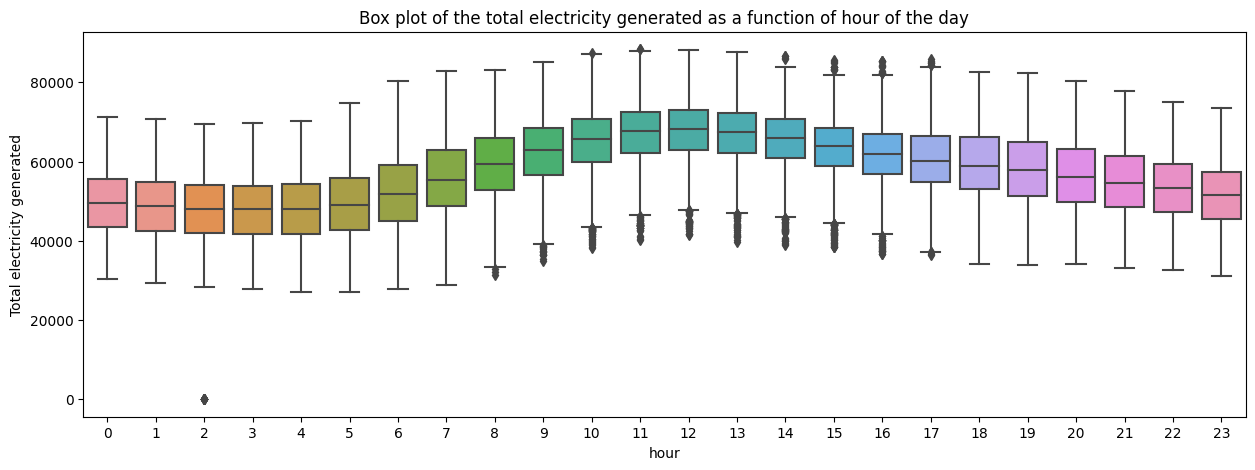

In [192]:
# Figure 17: Seaborn box plot of the total electricity generated as a function of hour of the day for all the data

fig,ax = plt.subplots(figsize=(15.,5.))
sns.boxplot(data=ener_all,x='hour',y='Total electricity generated')
plt.title('Box plot of the total electricity generated as a function of hour of the day')
plt.show()

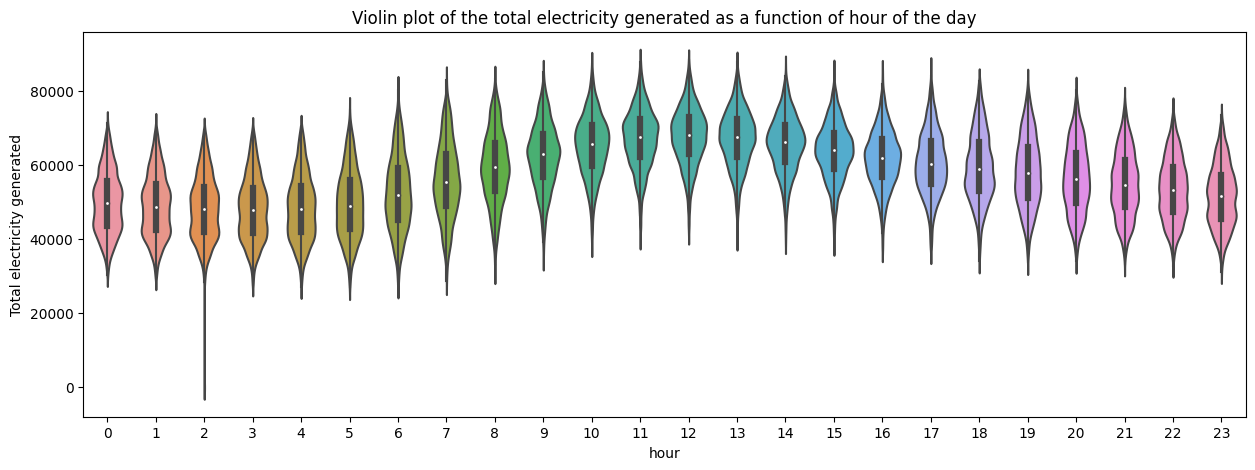

In [193]:
# Figure 18: Seaborn violin plot of the total electricity generated as
# a function of hour of the day for all the data

fig,ax = plt.subplots(figsize=(15.,5.))
sns.violinplot(data=ener_all,x='hour',y='Total electricity generated',split=True,width=0.8)
plt.title('Violin plot of the total electricity generated as a function of hour of the day')
plt.show()

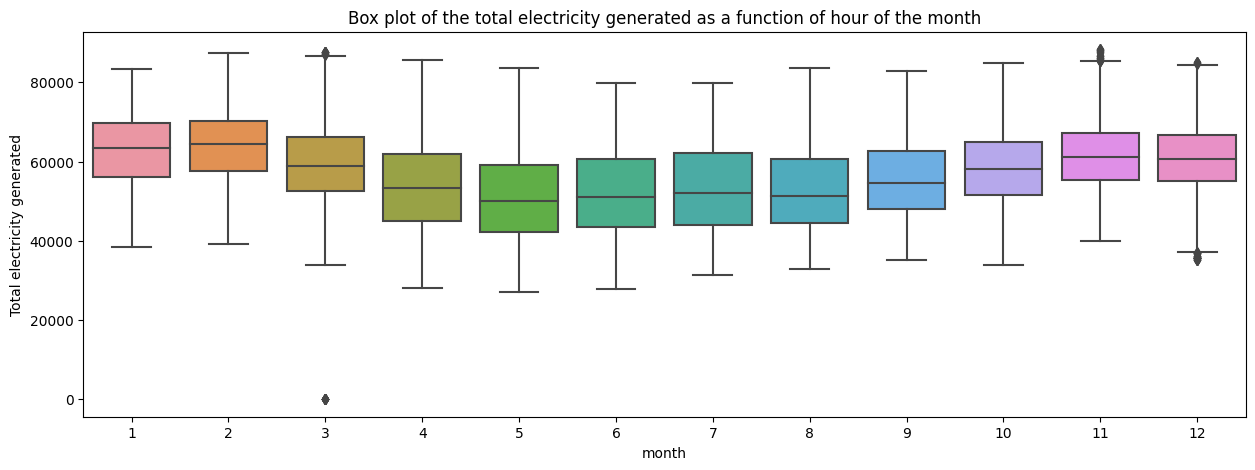

In [195]:
# Figure 19: Seaborn box plot of the total electricity generated as
# a function of month for all the data

fig,ax = plt.subplots(figsize=(15.,5.))
sns.boxplot(data=ener_all,x='month',y='Total electricity generated')
plt.title('Box plot of the total electricity generated as a function of hour of the month')
plt.show()

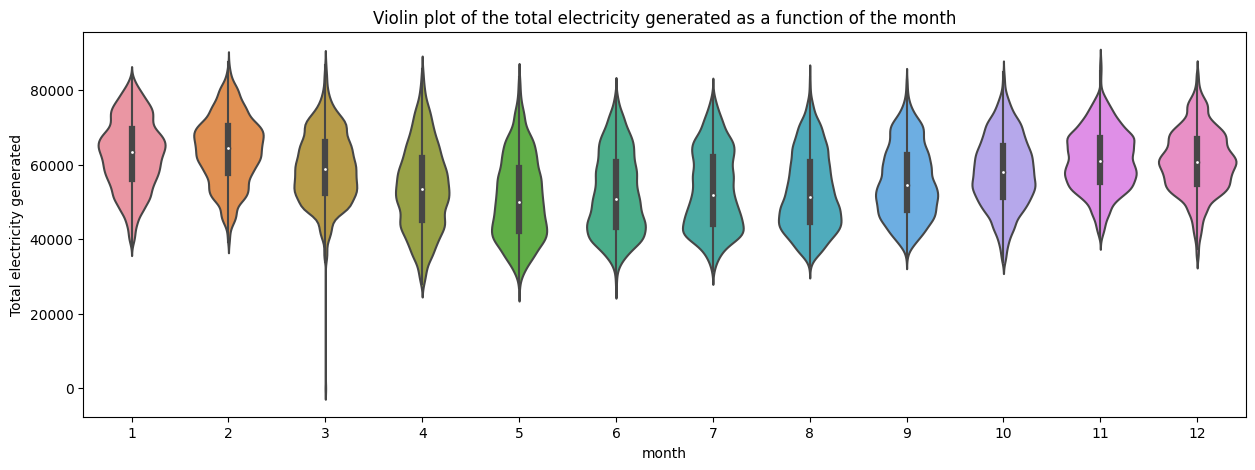

In [196]:
# Figure 20: Seaborn violin plot of the total electricity generated as
# a function of month for all the data

fig,ax = plt.subplots(figsize=(15.,5.))
sns.violinplot(data=ener_all,x='month',y='Total electricity generated',split=True,width=0.8)
plt.title('Violin plot of the total electricity generated as a function of the month')
plt.show()

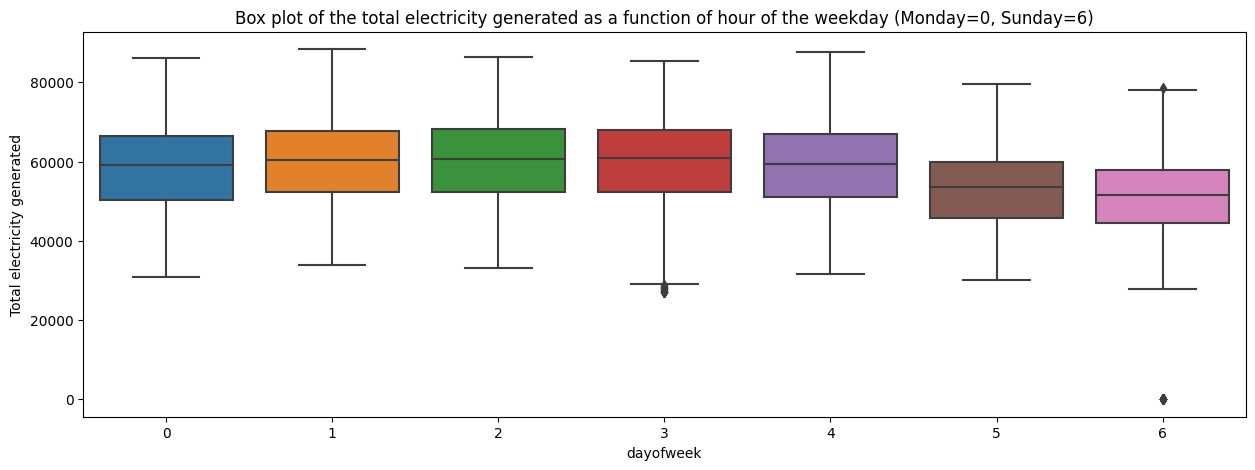

In [197]:
# Figure 21: Seaborn box plot of the total electricity generated as
# a function of the weekday for all the data

fig,ax = plt.subplots(figsize=(15.,5.))
sns.boxplot(data=ener_all,x='dayofweek',y='Total electricity generated')
plt.title('Box plot of the total electricity generated as a function of hour of the weekday (Monday=0, Sunday=6)')
plt.show()

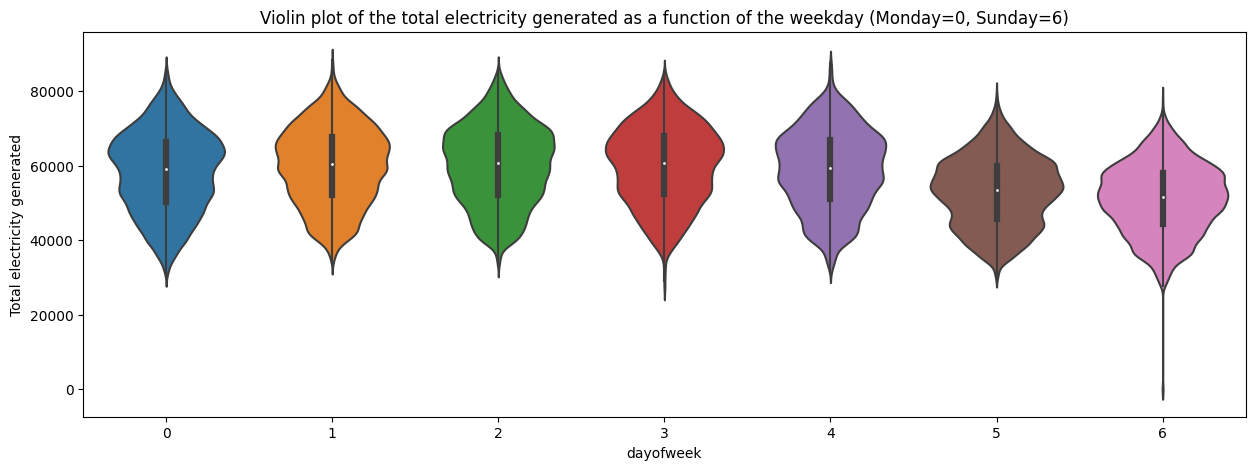

In [198]:
# Figure 22: Seaborn violin plot of the total electricity generated as
# a function of the weekday for all the data

fig,ax = plt.subplots(figsize=(15.,5.))
sns.violinplot(data=ener_all,x='dayofweek',y='Total electricity generated',split=True,width=0.8)
plt.title('Violin plot of the total electricity generated as a function of the weekday (Monday=0, Sunday=6)')
plt.show()

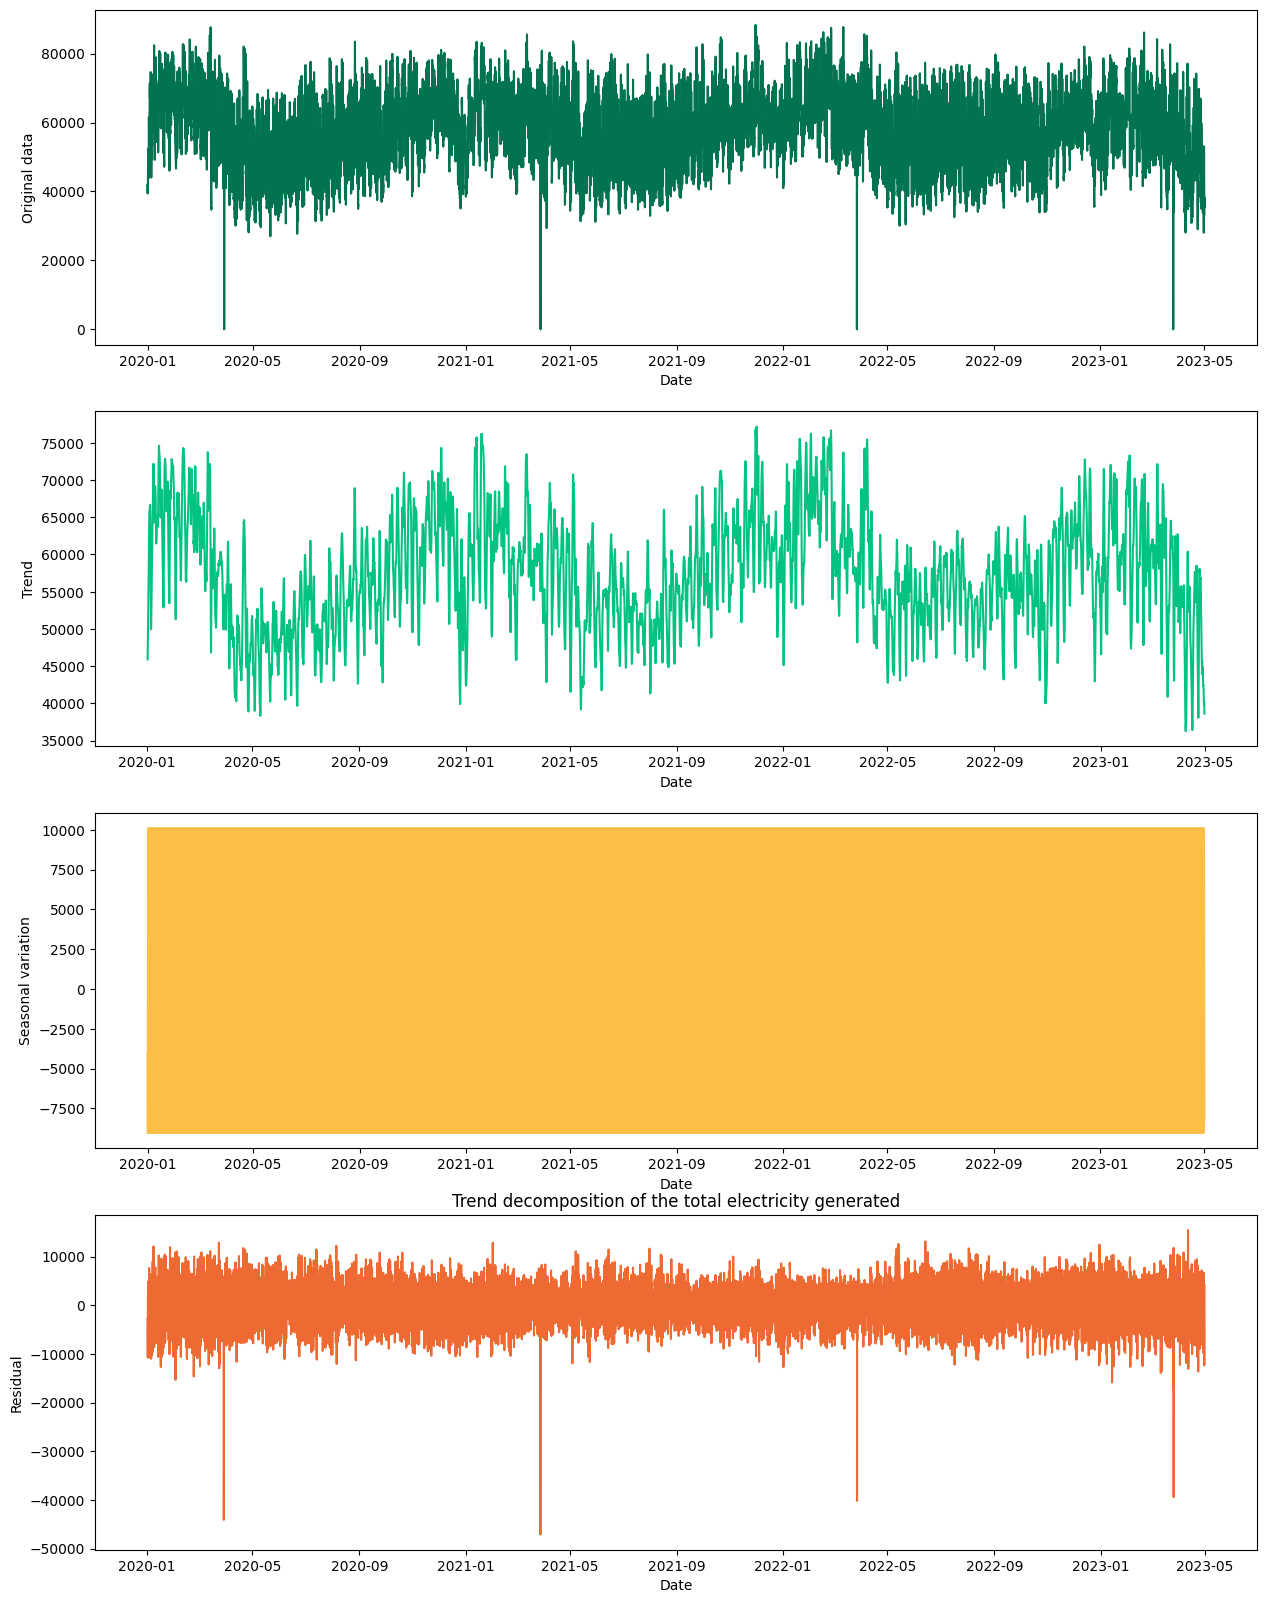

In [56]:
# Figure 23: A seasonal decomposition function using moving averages from the statsmodels package,
# applied to the electricity generation data from 2020 to April 2023 with a daily period.

decomposition = seasonal_decompose(ener_all['Total electricity generated'], model='additive',period=96)
# The number 96 corresponds to one day, since each day has measurements every 15 minutes.
trend    = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize = (15.,20.))

clrs = iter(colors)

ax1.plot(ener_all.index,ener_all['Total electricity generated'],c=next(clrs))
ax1.set_xlabel('Date')
ax1.set_ylabel('Original data')

ax2.plot(ener_all.index,trend,c=next(clrs))
ax2.set_xlabel('Date')
ax2.set_ylabel('Trend')

ax3.plot(ener_all.index,seasonal,c=next(clrs))
ax3.set_xlabel('Date')
ax3.set_ylabel('Seasonal variation')

ax4.plot(ener_all.index,residual,c=next(clrs))
ax4.set_xlabel('Date')
ax4.set_ylabel('Residual')


plt.title('Trend decomposition of the total electricity generated')
#plt.legend(bbox_to_anchor=(1.25, 1),frameon=False)

plt.show()

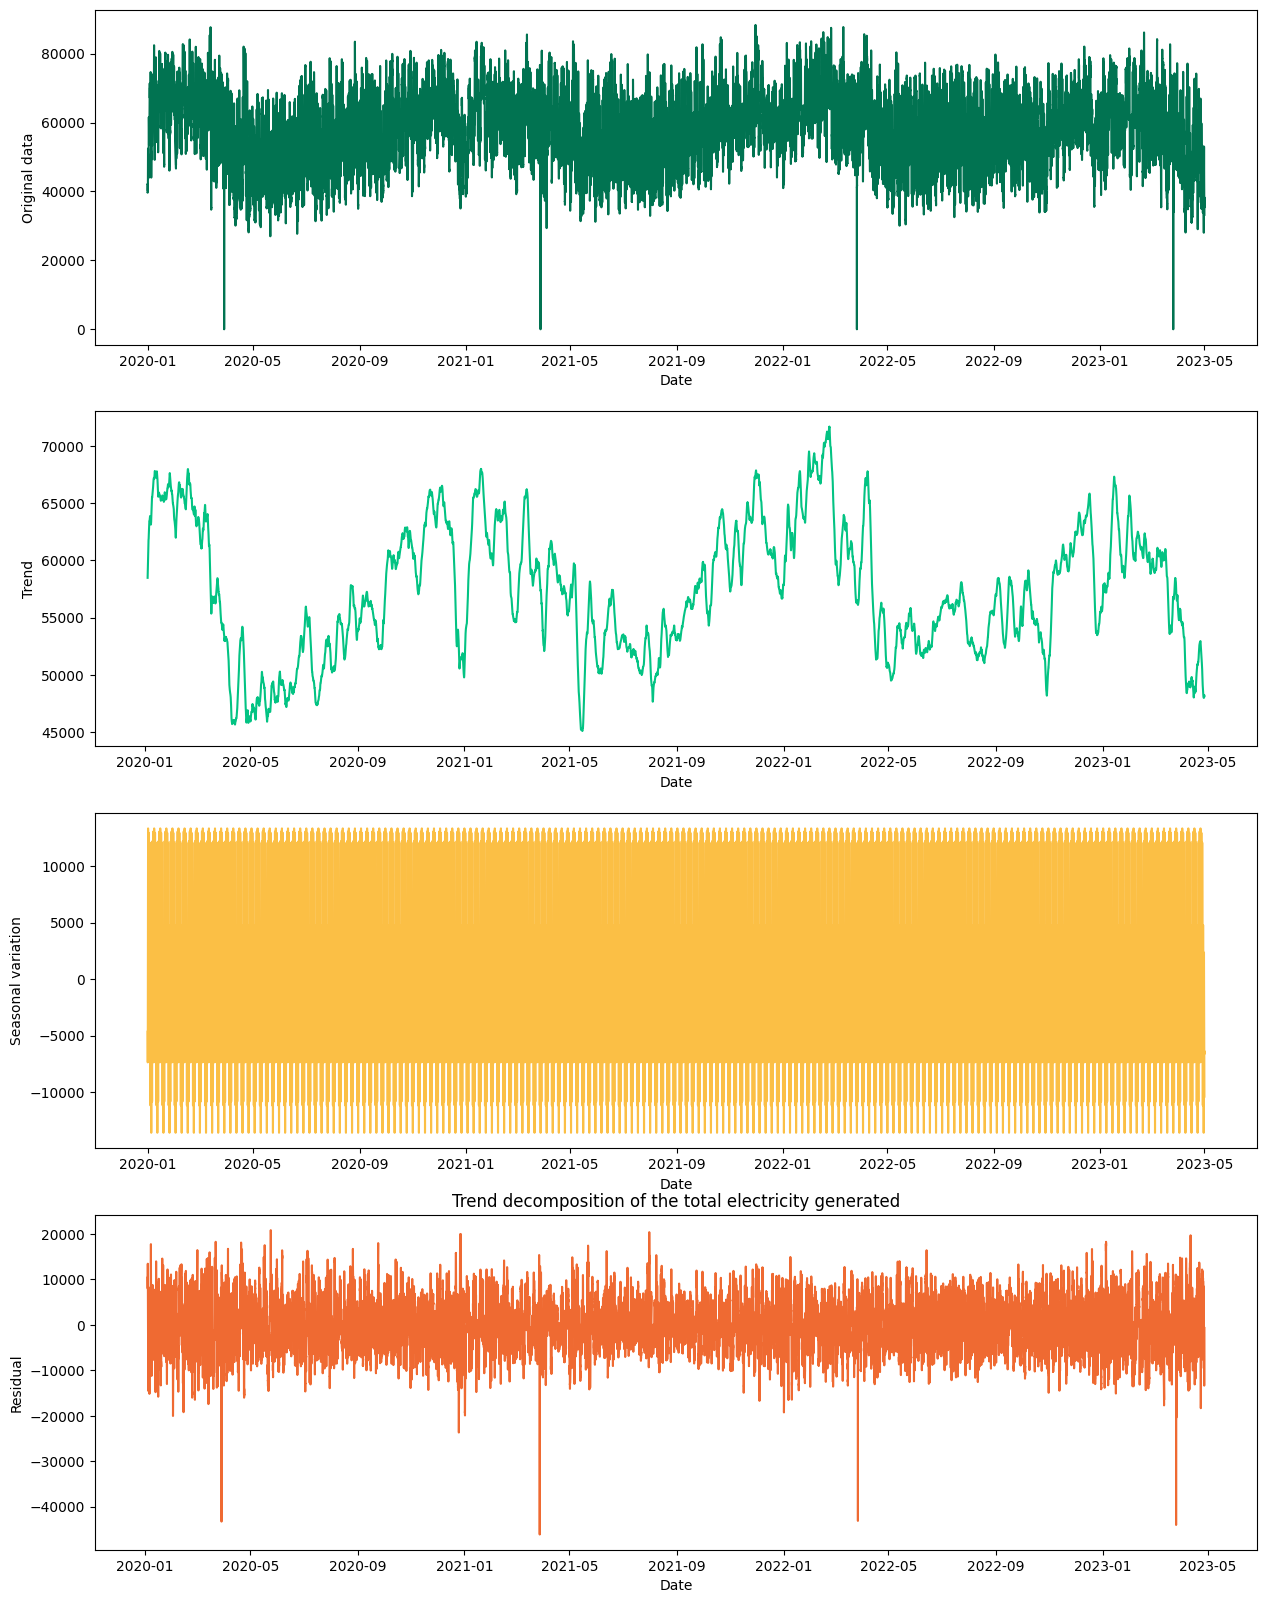

In [39]:
# Figure 24: A seasonal decomposition function using moving averages from the statsmodels package,
# applied to the electricity generation data from 2020 to April 2023 with a weekly period.

decomposition = seasonal_decompose(ener_all['Total electricity generated'], model='additive',period=672)
# The number 672 corresponds to one week, since each day has measurements every 15 minutes.
trend    = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize = (15.,20.))

clrs = iter(colors)

ax1.plot(ener_all.index,ener_all['Total electricity generated'],c=next(clrs))
ax1.set_xlabel('Date')
ax1.set_ylabel('Original data')

ax2.plot(ener_all.index,trend,c=next(clrs))
ax2.set_xlabel('Date')
ax2.set_ylabel('Trend')

ax3.plot(ener_all.index,seasonal,c=next(clrs))
ax3.set_xlabel('Date')
ax3.set_ylabel('Seasonal variation')

ax4.plot(ener_all.index,residual,c=next(clrs))
ax4.set_xlabel('Date')
ax4.set_ylabel('Residual')


plt.title('Trend decomposition of the total electricity generated')
#plt.legend(bbox_to_anchor=(1.25, 1),frameon=False)

plt.show()

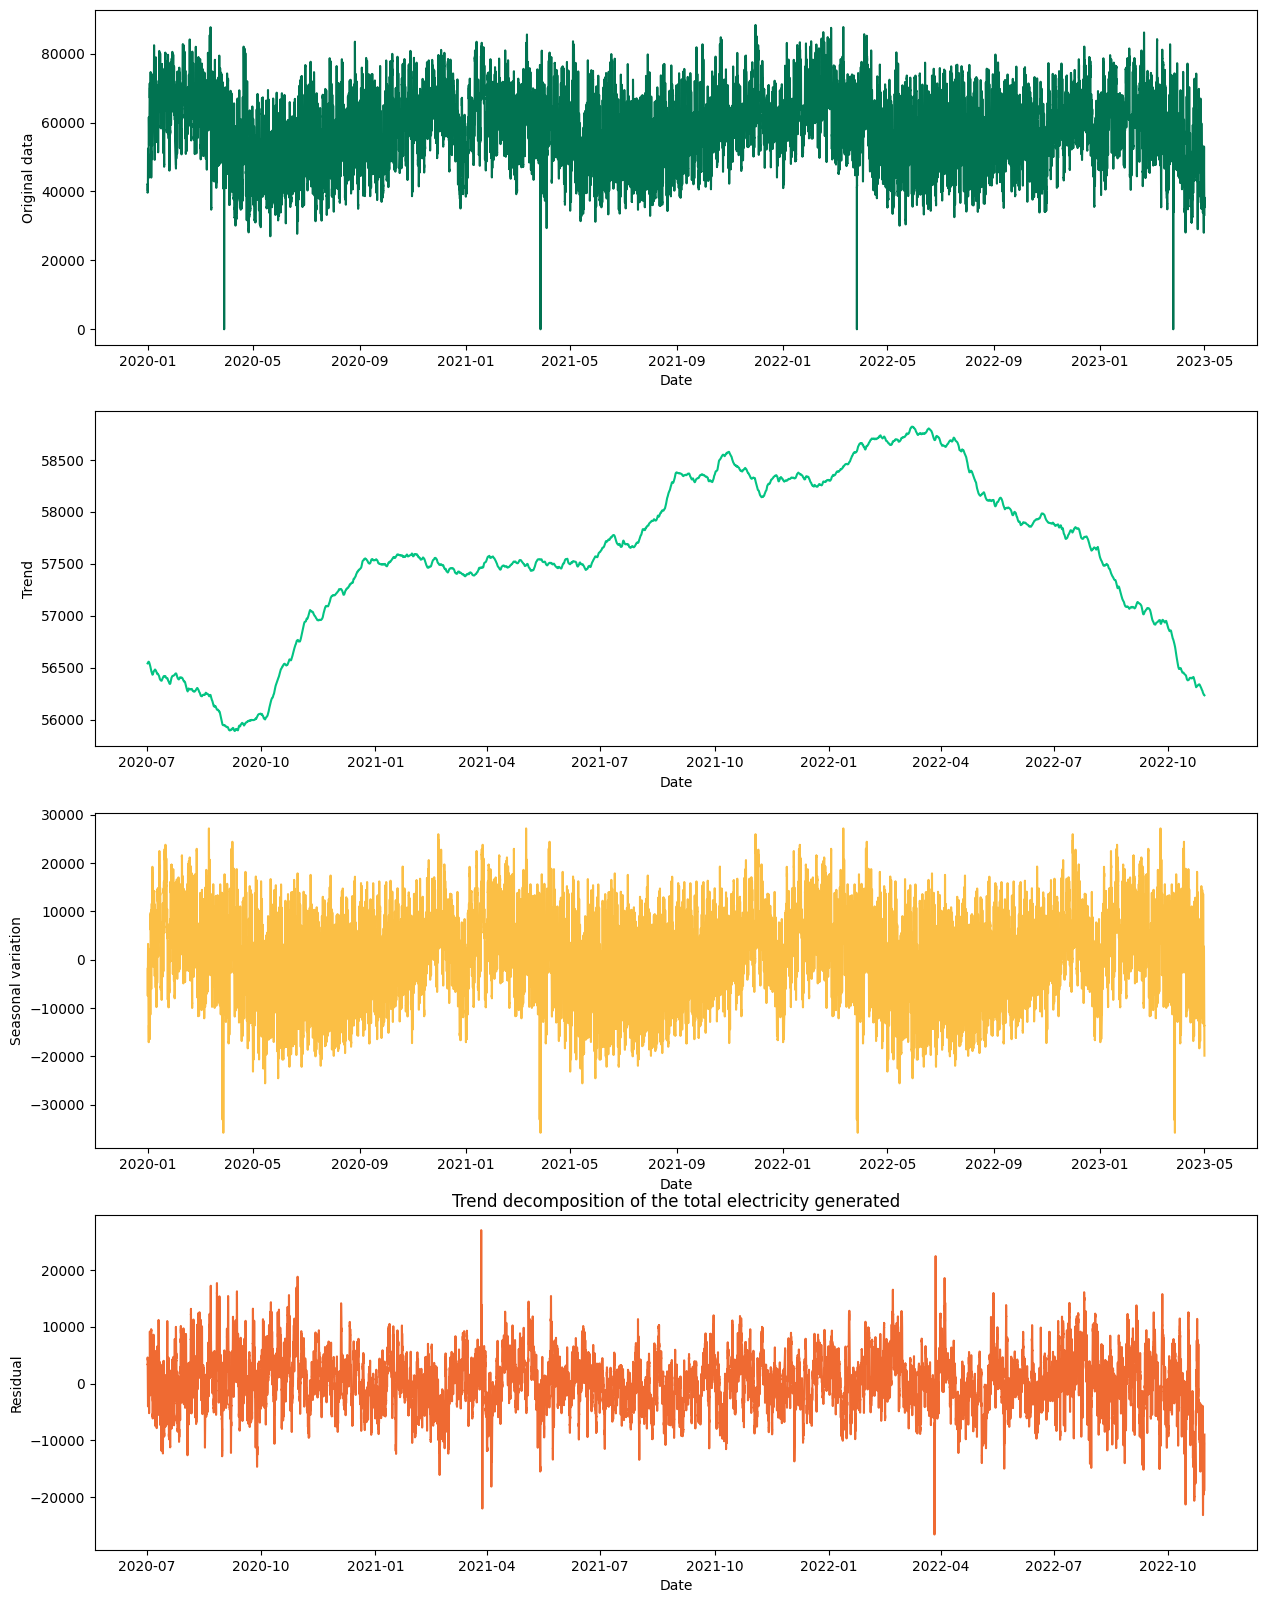

In [40]:
# Figure 25: A seasonal decomposition function using moving averages from the statsmodels package,
# applied to the electricity generation data from 2020 to April 2023 with a yearly period.

decomposition = seasonal_decompose(ener_all['Total electricity generated'], model='additive',period=35040)
# The number 35040 corresponds to one year, since each day has measurements every 15 minutes.
trend    = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize = (15.,20.))

clrs = iter(colors)

ax1.plot(ener_all.index,ener_all['Total electricity generated'],c=next(clrs))
ax1.set_xlabel('Date')
ax1.set_ylabel('Original data')

ax2.plot(ener_all.index,trend,c=next(clrs))
ax2.set_xlabel('Date')
ax2.set_ylabel('Trend')

ax3.plot(ener_all.index,seasonal,c=next(clrs))
ax3.set_xlabel('Date')
ax3.set_ylabel('Seasonal variation')

ax4.plot(ener_all.index,residual,c=next(clrs))
ax4.set_xlabel('Date')
ax4.set_ylabel('Residual')


plt.title('Trend decomposition of the total electricity generated')
#plt.legend(bbox_to_anchor=(1.25, 1),frameon=False)

plt.show()

In [81]:
mstl = MSTL(ener_all['Total electricity generated'], periods=[4*24,4*24*7,4*24*365])
res = mstl.fit()
#print(res.seasonal)

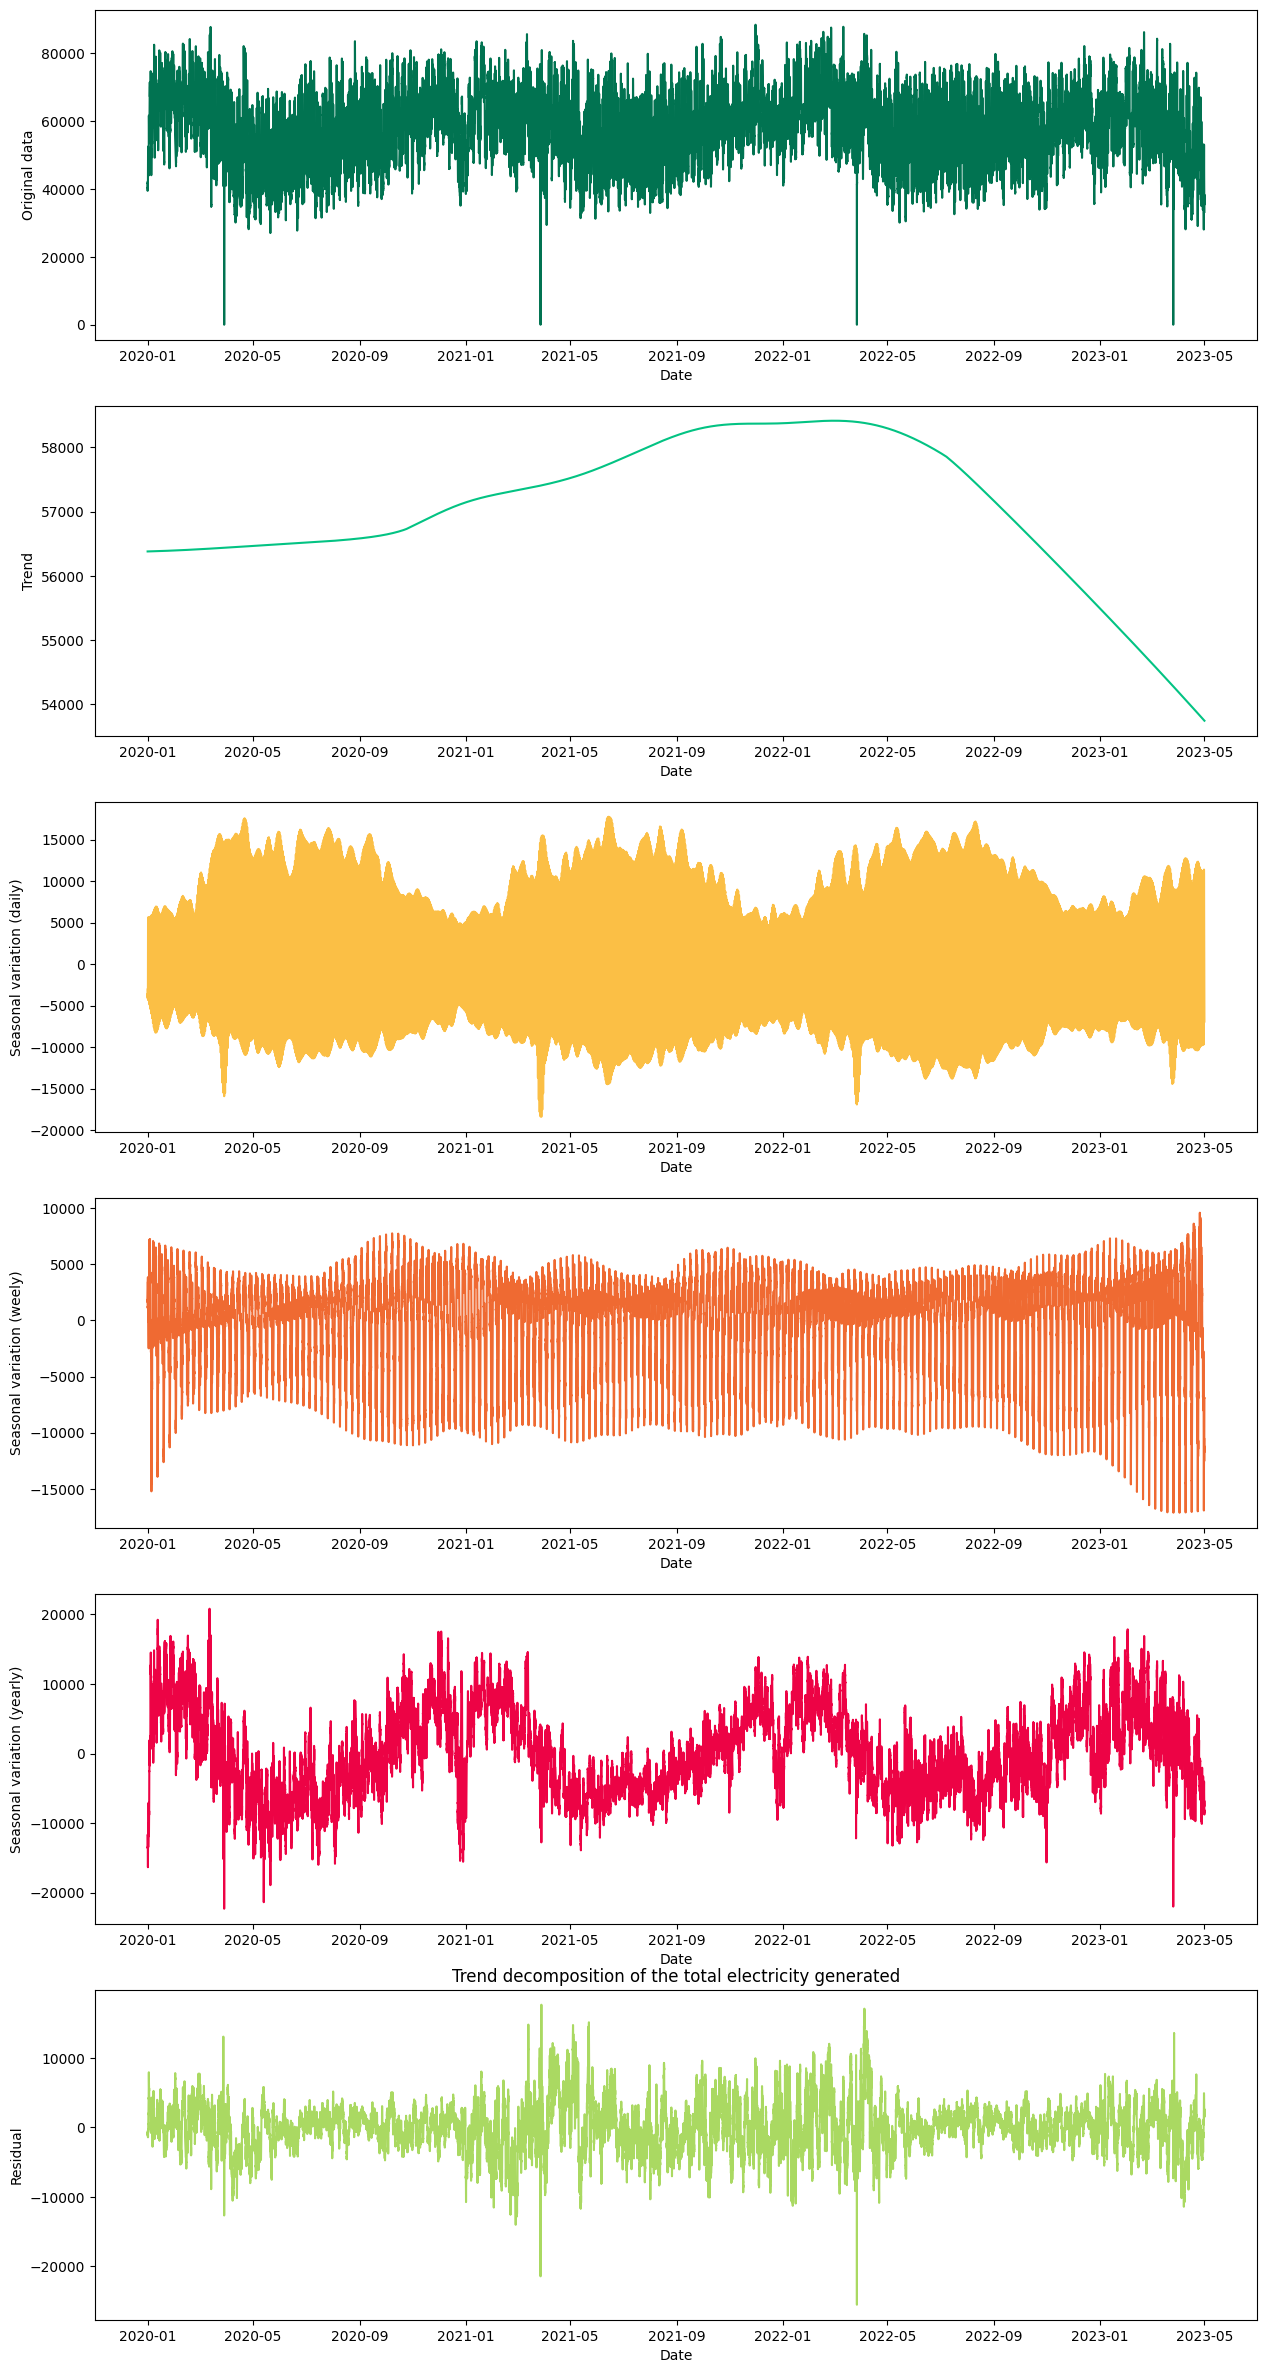

In [82]:
# Figure 26: A multi-seasonal decomposition function from the statsmodels package,
# applied to the electricity generation data from 2020 to April 2023 with the
# above three periods applied at once. This function is very time consuming to apply
# on such a large dataset, but the results are nonetheless interesting.

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, figsize = (15.,30.))

clrs = iter(colors)

ax1.plot(ener_all.index,ener_all['Total electricity generated'],c=next(clrs))
ax1.set_xlabel('Date')
ax1.set_ylabel('Original data')

ax2.plot(ener_all.index,res.trend,c=next(clrs))
ax2.set_xlabel('Date')
ax2.set_ylabel('Trend')

ax3.plot(ener_all.index,res.seasonal['seasonal_96'],c=next(clrs))
ax3.set_xlabel('Date')
ax3.set_ylabel('Seasonal variation (daily)')

ax4.plot(ener_all.index,res.seasonal['seasonal_672'],c=next(clrs))
ax4.set_xlabel('Date')
ax4.set_ylabel('Seasonal variation (weely)')

ax5.plot(ener_all.index,res.seasonal['seasonal_35040'],c=next(clrs))
ax5.set_xlabel('Date')
ax5.set_ylabel('Seasonal variation (yearly)')

ax6.plot(ener_all.index,res.resid,c=next(clrs))
ax6.set_xlabel('Date')
ax6.set_ylabel('Residual')


plt.title('Trend decomposition of the total electricity generated')
#plt.legend(bbox_to_anchor=(1.25, 1),frameon=False)

plt.show()


It became clear from the data on Figs. 17-22 that electricity generation rates are correlated to the time of day, day of the week and month. From Figs. 23-26 we see that seasonalities can be extracted, but more than one period is necessary. I extracted a daily, weekly and yearly seasonality, but there may still be structure in the noise that has additional seasonality to it. Using this approach over and over trying to extract all sub-periods can result in improvements, but it is time consuming. However, knowing that there is a correlation between the time defined in the data frame and the electricity generation rate, some machine learning models are produced, progressively using more of these variables as the model's features.

In [93]:
# Creating a first XGBoost model, using only three time time features

features = ['hour','month','dayofweek']
X_train = ener_past[features]
y_train = ener_past['Total electricity generated']
X_test = ener_2023[features]
y_test = ener_2023['Total electricity generated']

In [94]:
regression = xgb.XGBRegressor(n_estimators=10000,early_stopping_rounds=50,learning_rate=0.01)
regression.fit(X_train,y_train,
              eval_set=[(X_train,y_train),(X_test,y_test)],
              verbose=True)

[0]	validation_0-rmse:57772.46245	validation_1-rmse:57843.48880
[1]	validation_0-rmse:57201.99038	validation_1-rmse:57245.71878
[2]	validation_0-rmse:56637.29088	validation_1-rmse:56654.01642
[3]	validation_0-rmse:56078.30697	validation_1-rmse:56069.44360
[4]	validation_0-rmse:55524.98069	validation_1-rmse:55489.68294
[5]	validation_0-rmse:54977.25668	validation_1-rmse:54916.83175
[6]	validation_0-rmse:54435.07889	validation_1-rmse:54348.77997
[7]	validation_0-rmse:53898.39398	validation_1-rmse:53787.50967
[8]	validation_0-rmse:53367.08925	validation_1-rmse:53230.57314
[9]	validation_0-rmse:52841.16845	validation_1-rmse:52679.26393
[10]	validation_0-rmse:52320.57978	validation_1-rmse:52133.60588
[11]	validation_0-rmse:51805.11002	validation_1-rmse:51591.28213
[12]	validation_0-rmse:51295.02211	validation_1-rmse:51056.55458
[13]	validation_0-rmse:50789.94875	validation_1-rmse:50525.19088
[14]	validation_0-rmse:50290.15423	validation_1-rmse:50001.29449
[15]	validation_0-rmse:49795.43037	

[126]	validation_0-rmse:17290.23275	validation_1-rmse:15616.07735
[127]	validation_0-rmse:17138.10142	validation_1-rmse:15461.45622
[128]	validation_0-rmse:16987.37425	validation_1-rmse:15309.49626
[129]	validation_0-rmse:16838.57861	validation_1-rmse:15157.94621
[130]	validation_0-rmse:16691.17381	validation_1-rmse:15008.77112
[131]	validation_0-rmse:16545.46447	validation_1-rmse:14860.16167
[132]	validation_0-rmse:16401.63554	validation_1-rmse:14713.98336
[133]	validation_0-rmse:16259.14034	validation_1-rmse:14572.01491
[134]	validation_0-rmse:16118.23636	validation_1-rmse:14429.73565
[135]	validation_0-rmse:15978.97551	validation_1-rmse:14288.66070
[136]	validation_0-rmse:15841.49313	validation_1-rmse:14149.75085
[137]	validation_0-rmse:15705.31741	validation_1-rmse:14014.25268
[138]	validation_0-rmse:15570.94127	validation_1-rmse:13878.83085
[139]	validation_0-rmse:15437.82659	validation_1-rmse:13745.30407
[140]	validation_0-rmse:15306.51564	validation_1-rmse:13613.28443
[141]	vali

[253]	validation_0-rmse:7404.33264	validation_1-rmse:6838.67262
[254]	validation_0-rmse:7376.16322	validation_1-rmse:6826.02444
[255]	validation_0-rmse:7348.36009	validation_1-rmse:6814.40358
[256]	validation_0-rmse:7321.00183	validation_1-rmse:6802.78432
[257]	validation_0-rmse:7294.17867	validation_1-rmse:6791.41585
[258]	validation_0-rmse:7267.69269	validation_1-rmse:6781.24110
[259]	validation_0-rmse:7241.57900	validation_1-rmse:6771.57125
[260]	validation_0-rmse:7215.94581	validation_1-rmse:6761.72178
[261]	validation_0-rmse:7190.79963	validation_1-rmse:6751.94938
[262]	validation_0-rmse:7166.02297	validation_1-rmse:6743.67732
[263]	validation_0-rmse:7141.65512	validation_1-rmse:6735.36577
[264]	validation_0-rmse:7117.62690	validation_1-rmse:6727.55655
[265]	validation_0-rmse:7094.01185	validation_1-rmse:6719.40277
[266]	validation_0-rmse:7070.84014	validation_1-rmse:6712.21634
[267]	validation_0-rmse:7047.97386	validation_1-rmse:6705.36859
[268]	validation_0-rmse:7025.41087	valid

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=10000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

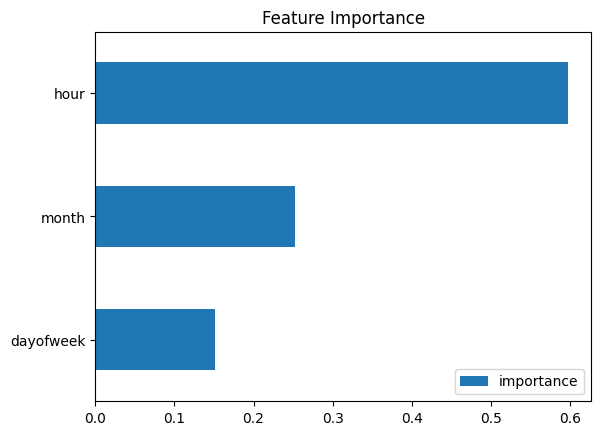

In [95]:
# Figure 27: Feature importance for the first attempt at training an 
# XGBoost model to predict energy production in Germany.

importance=pd.DataFrame(data=regression.feature_importances_,
             index=regression.feature_names_in_,
             columns=['importance'])
importance.sort_values('importance').plot(kind='barh',title='Feature Importance')
plt.show()

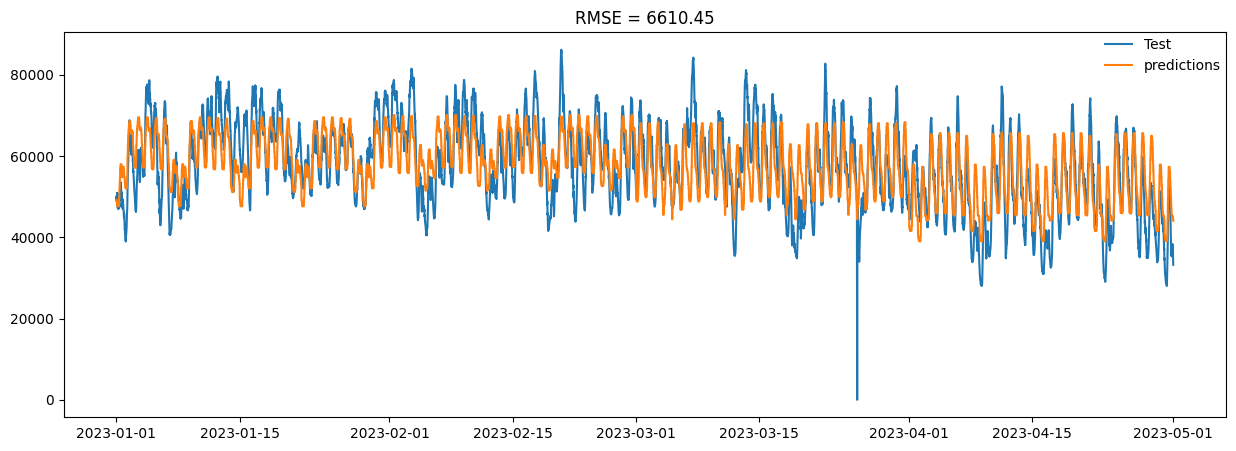

In [96]:
# Figure 28: Predicted vs test values of my first XGBoost model.

predictions = regression.predict(X_test)
fig, ax = plt.subplots(figsize=(15.,5.))
plt.title('RMSE = '+ "{:.2f}".format(np.sqrt(mean_squared_error(y_test,predictions))))
ax.plot(X_test.index,y_test,label='Test')
#ax.set_xlim('2022-05-01','2022-05-31')
ax.plot(X_test.index,predictions,label='predictions')
#ax.set_ylim(0,300)
plt.legend(loc='best', borderaxespad=0.,frameon=False)
#plt.title('Price of the second auction compared to the ML prediction during May 2022')
#ax.axvline('2022-03-01',color='black',linestyle='--')
plt.show()

In [97]:
# Creating a second XGBoost model, with a total of five time features

features = ['hour','month','dayofweek','quarter','dayofyear']
X_train = ener_past[features]
y_train = ener_past['Total electricity generated']
X_test = ener_2023[features]
y_test = ener_2023['Total electricity generated']

regression = xgb.XGBRegressor(n_estimators=10000,early_stopping_rounds=50,learning_rate=0.01)
regression.fit(X_train,y_train,
              eval_set=[(X_train,y_train),(X_test,y_test)],
              verbose=True)


[0]	validation_0-rmse:57771.96723	validation_1-rmse:57839.65171
[1]	validation_0-rmse:57200.99950	validation_1-rmse:57238.07794
[2]	validation_0-rmse:56635.80459	validation_1-rmse:56642.60315
[3]	validation_0-rmse:56076.32417	validation_1-rmse:56053.16792
[4]	validation_0-rmse:55522.50147	validation_1-rmse:55469.71156
[5]	validation_0-rmse:54974.28024	validation_1-rmse:54892.18459
[6]	validation_0-rmse:54431.57550	validation_1-rmse:54319.58694
[7]	validation_0-rmse:53894.38111	validation_1-rmse:53752.77580
[8]	validation_0-rmse:53362.60509	validation_1-rmse:53191.74668
[9]	validation_0-rmse:52836.21165	validation_1-rmse:52637.61234
[10]	validation_0-rmse:52315.02508	validation_1-rmse:52089.59397
[11]	validation_0-rmse:51799.22165	validation_1-rmse:51546.49132
[12]	validation_0-rmse:51288.53008	validation_1-rmse:51009.57056
[13]	validation_0-rmse:50783.11703	validation_1-rmse:50477.33278
[14]	validation_0-rmse:50282.68979	validation_1-rmse:49951.26230
[15]	validation_0-rmse:49787.48548	

[126]	validation_0-rmse:17178.36580	validation_1-rmse:15400.40651
[127]	validation_0-rmse:17024.37175	validation_1-rmse:15247.24401
[128]	validation_0-rmse:16872.21051	validation_1-rmse:15093.19985
[129]	validation_0-rmse:16721.57472	validation_1-rmse:14943.11644
[130]	validation_0-rmse:16572.42793	validation_1-rmse:14794.15697
[131]	validation_0-rmse:16425.16935	validation_1-rmse:14645.84871
[132]	validation_0-rmse:16279.22728	validation_1-rmse:14501.02369
[133]	validation_0-rmse:16134.85286	validation_1-rmse:14357.96648
[134]	validation_0-rmse:15992.47428	validation_1-rmse:14215.30948
[135]	validation_0-rmse:15851.23851	validation_1-rmse:14075.01383
[136]	validation_0-rmse:15711.75995	validation_1-rmse:13936.88290
[137]	validation_0-rmse:15573.65972	validation_1-rmse:13800.95053
[138]	validation_0-rmse:15437.03948	validation_1-rmse:13665.81745
[139]	validation_0-rmse:15302.30719	validation_1-rmse:13532.07579
[140]	validation_0-rmse:15168.78988	validation_1-rmse:13401.13240
[141]	vali

[253]	validation_0-rmse:6959.86519	validation_1-rmse:6681.55960
[254]	validation_0-rmse:6928.92645	validation_1-rmse:6670.44830
[255]	validation_0-rmse:6898.69221	validation_1-rmse:6658.93236
[256]	validation_0-rmse:6868.22063	validation_1-rmse:6649.81865
[257]	validation_0-rmse:6838.11034	validation_1-rmse:6640.79518
[258]	validation_0-rmse:6808.70171	validation_1-rmse:6632.18757
[259]	validation_0-rmse:6780.32135	validation_1-rmse:6622.46968
[260]	validation_0-rmse:6751.58907	validation_1-rmse:6616.17421
[261]	validation_0-rmse:6723.75099	validation_1-rmse:6607.73064
[262]	validation_0-rmse:6696.34140	validation_1-rmse:6599.53587
[263]	validation_0-rmse:6668.81328	validation_1-rmse:6593.03676
[264]	validation_0-rmse:6641.83545	validation_1-rmse:6587.33730
[265]	validation_0-rmse:6615.43345	validation_1-rmse:6581.50863
[266]	validation_0-rmse:6589.37625	validation_1-rmse:6576.78441
[267]	validation_0-rmse:6564.11126	validation_1-rmse:6570.68616
[268]	validation_0-rmse:6538.56934	valid

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=10000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

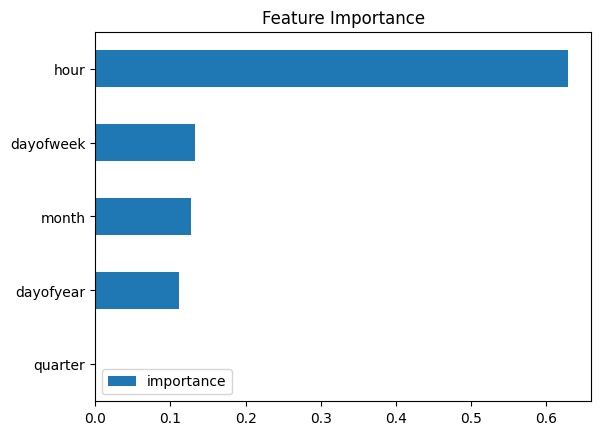

In [98]:
# Figure 29: Feature importance for the second attempt at training an 
# XGBoost model to predict energy production in Germany.

importance=pd.DataFrame(data=regression.feature_importances_,
             index=regression.feature_names_in_,
             columns=['importance'])
importance.sort_values('importance').plot(kind='barh',title='Feature Importance')
plt.show()


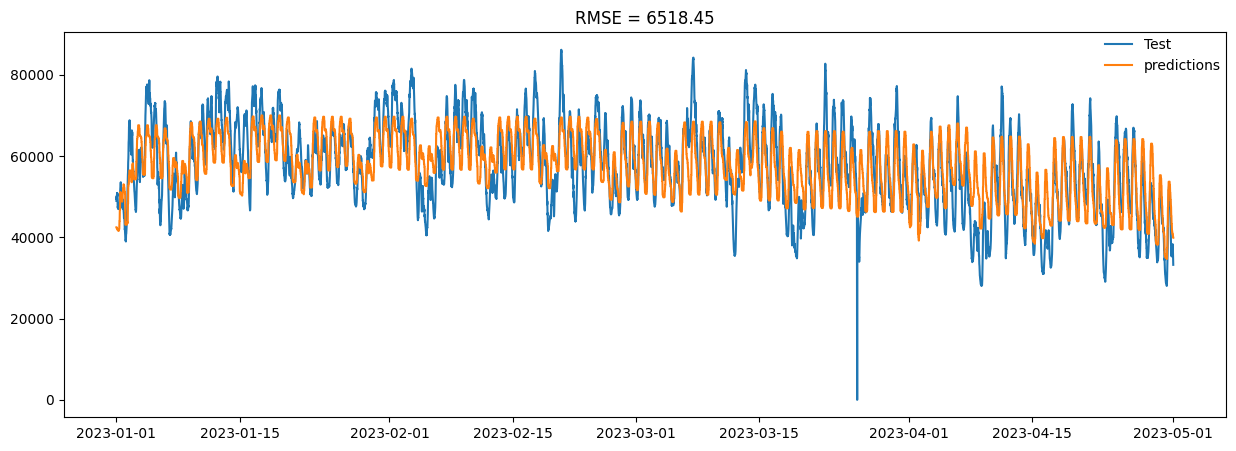

In [99]:
# Figure 30: Predicted vs test values of my second XGBoost model.

predictions = regression.predict(X_test)
fig, ax = plt.subplots(figsize=(15.,5.))

plt.title('RMSE = '+ "{:.2f}".format(np.sqrt(mean_squared_error(y_test,predictions))))
ax.plot(X_test.index,y_test,label='Test')
#ax.set_xlim('2022-05-01','2022-05-31')
ax.plot(X_test.index,predictions,label='predictions')
#ax.set_ylim(0,300)
plt.legend(loc='best', borderaxespad=0.,frameon=False)
#plt.title('Price of the second auction compared to the ML prediction during May 2022')
#ax.axvline('2022-03-01',color='black',linestyle='--')
plt.show()


In [100]:
# Creating a third XGBoost model, with a total of six time features

features = ['hour','month','dayofweek','quarter','dayofyear','year']
X_train = ener_past[features]
y_train = ener_past['Total electricity generated']
X_test = ener_2023[features]
y_test = ener_2023['Total electricity generated']

regression = xgb.XGBRegressor(n_estimators=10000,early_stopping_rounds=50,learning_rate=0.01)
regression.fit(X_train,y_train,
              eval_set=[(X_train,y_train),(X_test,y_test)],
              verbose=True)

[0]	validation_0-rmse:57771.92799	validation_1-rmse:57838.29480
[1]	validation_0-rmse:57200.92060	validation_1-rmse:57235.38759
[2]	validation_0-rmse:56635.68637	validation_1-rmse:56638.60295
[3]	validation_0-rmse:56076.16514	validation_1-rmse:56047.22705
[4]	validation_0-rmse:55522.30182	validation_1-rmse:55462.49930
[5]	validation_0-rmse:54974.03294	validation_1-rmse:54883.07552
[6]	validation_0-rmse:54431.27999	validation_1-rmse:54309.38448
[7]	validation_0-rmse:53894.00471	validation_1-rmse:53741.39482
[8]	validation_0-rmse:53362.16171	validation_1-rmse:53179.17310
[9]	validation_0-rmse:52835.73759	validation_1-rmse:52621.26995
[10]	validation_0-rmse:52314.48138	validation_1-rmse:52071.64170
[11]	validation_0-rmse:51798.63042	validation_1-rmse:51526.72344
[12]	validation_0-rmse:51287.89121	validation_1-rmse:50988.89567
[13]	validation_0-rmse:50782.42194	validation_1-rmse:50454.82641
[14]	validation_0-rmse:50281.95588	validation_1-rmse:49927.15544
[15]	validation_0-rmse:49786.67762	

[125]	validation_0-rmse:17300.65971	validation_1-rmse:15268.55687
[126]	validation_0-rmse:17144.37835	validation_1-rmse:15111.26341
[127]	validation_0-rmse:16989.45190	validation_1-rmse:14949.54670
[128]	validation_0-rmse:16836.40588	validation_1-rmse:14794.47709
[129]	validation_0-rmse:16684.91664	validation_1-rmse:14642.57047
[130]	validation_0-rmse:16535.10366	validation_1-rmse:14490.34178
[131]	validation_0-rmse:16387.01103	validation_1-rmse:14339.74593
[132]	validation_0-rmse:16240.40079	validation_1-rmse:14192.27345
[133]	validation_0-rmse:16095.53733	validation_1-rmse:14047.01225
[134]	validation_0-rmse:15952.11626	validation_1-rmse:13906.15537
[135]	validation_0-rmse:15810.29536	validation_1-rmse:13762.79988
[136]	validation_0-rmse:15669.97607	validation_1-rmse:13617.71321
[137]	validation_0-rmse:15531.23353	validation_1-rmse:13481.43808
[138]	validation_0-rmse:15394.08678	validation_1-rmse:13344.69062
[139]	validation_0-rmse:15258.31594	validation_1-rmse:13206.08380
[140]	vali

[252]	validation_0-rmse:6821.47779	validation_1-rmse:6682.72373
[253]	validation_0-rmse:6788.34186	validation_1-rmse:6678.00940
[254]	validation_0-rmse:6755.76768	validation_1-rmse:6672.79031
[255]	validation_0-rmse:6724.29026	validation_1-rmse:6666.84708
[256]	validation_0-rmse:6692.95491	validation_1-rmse:6662.01185
[257]	validation_0-rmse:6661.88456	validation_1-rmse:6658.10872
[258]	validation_0-rmse:6631.77427	validation_1-rmse:6653.19047
[259]	validation_0-rmse:6602.01998	validation_1-rmse:6648.94953
[260]	validation_0-rmse:6572.42206	validation_1-rmse:6645.37612
[261]	validation_0-rmse:6543.57046	validation_1-rmse:6642.02759
[262]	validation_0-rmse:6514.83866	validation_1-rmse:6639.02056
[263]	validation_0-rmse:6486.44889	validation_1-rmse:6637.83167
[264]	validation_0-rmse:6457.74463	validation_1-rmse:6635.08080
[265]	validation_0-rmse:6430.30998	validation_1-rmse:6633.69592
[266]	validation_0-rmse:6403.10988	validation_1-rmse:6632.11813
[267]	validation_0-rmse:6376.75814	valid

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=10000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

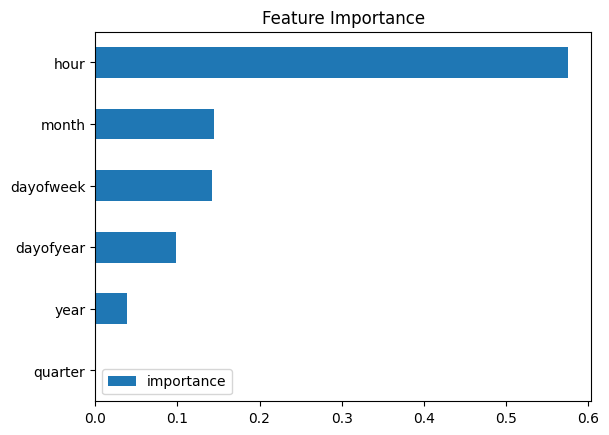

In [101]:
# Figure 31: Feature importance for the third attempt at training an 
# XGBoost model to predict energy production in Germany.

importance=pd.DataFrame(data=regression.feature_importances_,
             index=regression.feature_names_in_,
             columns=['importance'])
importance.sort_values('importance').plot(kind='barh',title='Feature Importance')
plt.show()


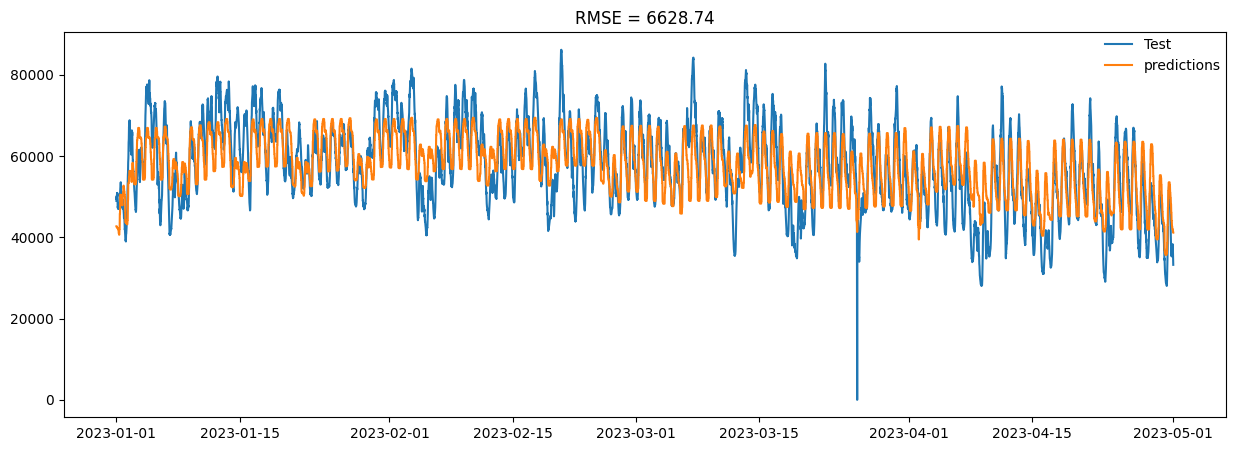

In [102]:
# Figure 32: Predicted vs test values of my third XGBoost model.

predictions = regression.predict(X_test)
fig, ax = plt.subplots(figsize=(15.,5.))
plt.title('RMSE = '+ "{:.2f}".format(np.sqrt(mean_squared_error(y_test,predictions))))
ax.plot(X_test.index,y_test,label='Test')
ax.plot(X_test.index,predictions,label='predictions')
plt.legend(loc='best', borderaxespad=0.,frameon=False)
plt.show()


Predictions using only temporal data were transformed directly into a supervised learning problem and tested on a fraction of the data. They capture some of the trends, but are not great. Below, Fig. 33 shows that the data has a very strong autocorrelation, so lag features are introduced to improve the forecast model's predictions. Since such features are the actual values of previous timesteps, models cannot be evaluated in the same way, so we reproduce the previous models and create a model using lags, and evaluate them using a rolling window approach.

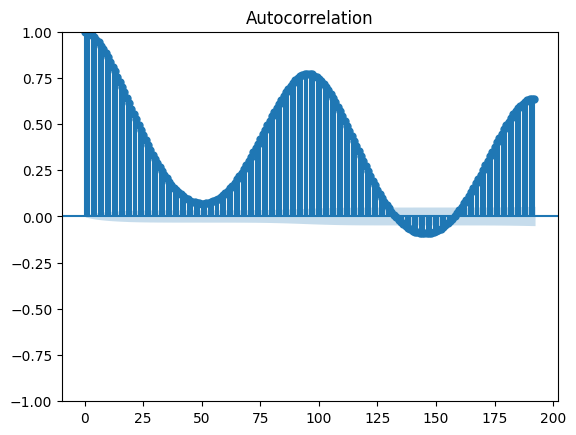

In [16]:
# Figure 33: Autocorrelation function (drawn from statsmodels)
#of the energy generation rate over a period of 2 days.

fig = tsaplots.plot_acf(ener_all['Total electricity generated'], lags=192)
plt.show()


In [30]:
ener_all_copy = ener_all.copy()
ener_all_copy = add_lags(ener_all_copy,5)
ener_2023_copy = ener_2023.copy()
ener_2023_copy = add_lags(ener_2023_copy,5)
ener_past_copy = ener_past.copy()
ener_past_copy = add_lags(ener_past_copy,5)


In [23]:
# Creating a series of XGBoost models to perform a rolling window validation,
# using only three time features

features = ['hour','month','dayofweek']
target = 'Total electricity generated'
train_start_date='01-01-2020'
train_end_date='04-23-2023'
test_end_date='04-30-2023'

predictions, rmse = rolling_window_validation(ener_all,features,target,
                                              train_start_date = train_start_date,
                                              train_end_date = train_end_date,
                                              test_end_date = test_end_date,
                                              verbose=True)


The test window length is 1209 days 00:00:00
The test window length is 7 days 00:00:00
Predictions are as follows:
Time, test value, predicted value
2023-04-24 00:00:00 38796.0 44937.242
2023-04-24 00:15:00 38602.0 44873.715
2023-04-24 00:30:00 38861.0 44825.473
2023-04-24 00:45:00 38972.0 44724.72
2023-04-24 01:00:00 38750.0 44340.137
2023-04-24 01:15:00 38768.0 44405.69
2023-04-24 01:30:00 38631.0 44308.57
2023-04-24 01:45:00 38868.0 44259.57
2023-04-24 02:00:00 38921.0 44292.457
2023-04-24 02:15:00 39050.0 44323.875
2023-04-24 02:30:00 39493.0 44194.875
2023-04-24 02:45:00 39576.0 44330.965
2023-04-24 03:00:00 39641.0 44220.094
2023-04-24 03:15:00 39708.0 44146.914
2023-04-24 03:30:00 39671.0 44214.91
2023-04-24 03:45:00 40040.0 44097.273
2023-04-24 04:00:00 39961.0 44592.902
2023-04-24 04:15:00 39904.0 44530.703
2023-04-24 04:30:00 40210.0 44537.69
2023-04-24 04:45:00 40821.0 44439.3
2023-04-24 05:00:00 41871.0 45730.44
2023-04-24 05:15:00 42039.0 45748.086
2023-04-24 05:30:00 4293

2023-04-26 05:45:00 48120.0 48642.67
2023-04-26 06:00:00 48366.0 52019.465
2023-04-26 06:15:00 49513.0 51938.938
2023-04-26 06:30:00 50828.0 52003.098
2023-04-26 06:45:00 52105.0 52014.59
2023-04-26 07:00:00 53937.0 55946.9
2023-04-26 07:15:00 55358.0 55863.594
2023-04-26 07:30:00 56144.0 55941.12
2023-04-26 07:45:00 56878.0 55879.652
2023-04-26 08:00:00 59262.0 59723.805
2023-04-26 08:15:00 59396.0 59735.11
2023-04-26 08:30:00 60117.0 59780.688
2023-04-26 08:45:00 60695.0 59860.945
2023-04-26 09:00:00 61849.0 63140.785
2023-04-26 09:15:00 62070.0 63213.39
2023-04-26 09:30:00 63144.0 63243.258
2023-04-26 09:45:00 63546.0 63215.32
2023-04-26 10:00:00 64420.0 66603.1
2023-04-26 10:15:00 64653.0 66412.945
2023-04-26 10:30:00 64672.0 66436.14
2023-04-26 10:45:00 65091.0 66464.99
2023-04-26 11:00:00 66419.0 69183.17
2023-04-26 11:15:00 66976.0 69263.9
2023-04-26 11:30:00 66422.0 69371.016
2023-04-26 11:45:00 66599.0 69203.77
2023-04-26 12:00:00 65010.0 69996.63
2023-04-26 12:15:00 65059.0 7

2023-04-28 12:30:00 52739.0 67360.266
2023-04-28 12:45:00 52342.0 67240.91
2023-04-28 13:00:00 52061.0 67006.445
2023-04-28 13:15:00 51591.0 66984.04
2023-04-28 13:30:00 51321.0 66938.766
2023-04-28 13:45:00 50932.0 66891.664
2023-04-28 14:00:00 50296.0 65593.305
2023-04-28 14:15:00 49897.0 65597.75
2023-04-28 14:30:00 49235.0 65637.31
2023-04-28 14:45:00 48613.0 65494.133
2023-04-28 15:00:00 48611.0 63644.918
2023-04-28 15:15:00 48597.0 63500.094
2023-04-28 15:30:00 48135.0 63496.21
2023-04-28 15:45:00 47613.0 63410.9
2023-04-28 16:00:00 46409.0 60315.76
2023-04-28 16:15:00 45929.0 60213.145
2023-04-28 16:30:00 45759.0 60152.613
2023-04-28 16:45:00 45166.0 60161.082
2023-04-28 17:00:00 44592.0 57195.83
2023-04-28 17:15:00 45097.0 57087.613
2023-04-28 17:30:00 45289.0 57087.73
2023-04-28 17:45:00 45224.0 57010.277
2023-04-28 18:00:00 44470.0 54826.242
2023-04-28 18:15:00 44641.0 54739.0
2023-04-28 18:30:00 45294.0 54903.984
2023-04-28 18:45:00 45604.0 54937.555
2023-04-28 19:00:00 4440

2023-04-30 19:15:00 36048.0 46549.027
2023-04-30 19:30:00 36172.0 46499.348
2023-04-30 19:45:00 35819.0 46632.926
2023-04-30 20:00:00 35774.0 46435.63
2023-04-30 20:15:00 35747.0 46341.754
2023-04-30 20:30:00 35820.0 46352.945
2023-04-30 20:45:00 35301.0 46242.81
2023-04-30 21:00:00 37546.0 46625.117
2023-04-30 21:15:00 37712.0 46621.125
2023-04-30 21:30:00 37286.0 46377.445
2023-04-30 21:45:00 37002.0 46545.24
2023-04-30 22:00:00 38308.0 46408.145
2023-04-30 22:15:00 37948.0 46336.816
2023-04-30 22:30:00 37654.0 46069.004
2023-04-30 22:45:00 36107.0 46050.86
2023-04-30 23:00:00 36118.0 45254.91
2023-04-30 23:15:00 35233.0 45080.742
2023-04-30 23:30:00 34142.0 44949.87
2023-04-30 23:45:00 33221.0 44682.11


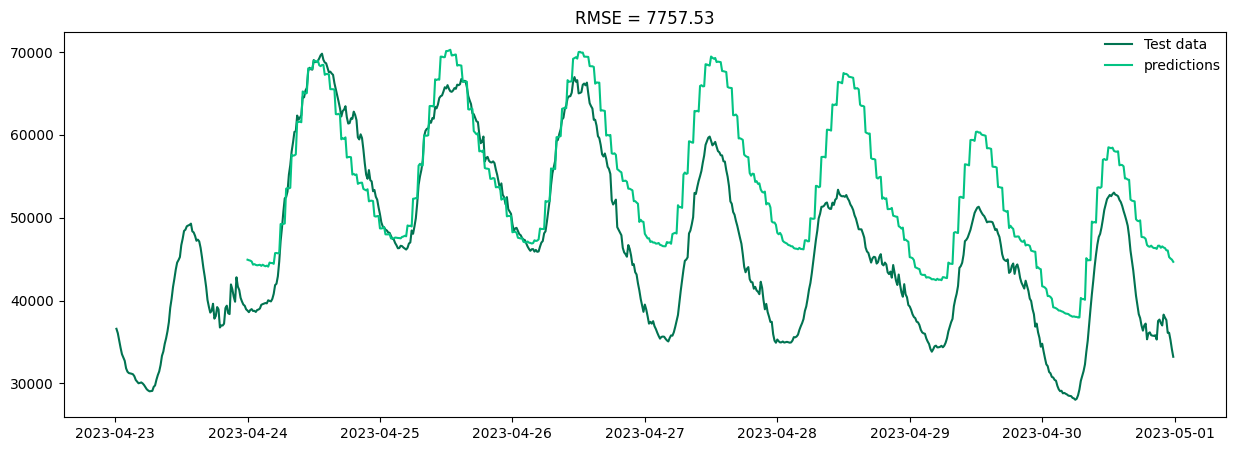

In [24]:
# Figure 35: One week predictions using a rolling window evaluation, on models
# with three time features.

fig, ax = plt.subplots(figsize=(15.,5.))

plt.title('RMSE = '+ "{:.2f}".format(rmse))
ax.plot(ener_all[ener_all.index>train_end_date].index,ener_all[ener_all.index>train_end_date][target],label='Test data',c=colors[0])
ax.plot(predictions.index,predictions[target],label='predictions',c=colors[1])
plt.legend(loc='best', borderaxespad=0.,frameon=False)
plt.show()


In [27]:
# Creating a series of XGBoost models to perform a rolling window validation,
# using four time features

features = ['hour','minute','month','dayofweek']
target = 'Total electricity generated'
train_start_date='01-01-2020'
train_end_date='04-23-2023'
test_end_date='04-30-2023'

predictions, rmse = rolling_window_validation(ener_all,features,target,
                                              train_start_date = train_start_date,
                                              train_end_date = train_end_date,
                                              test_end_date = test_end_date,
                                              verbose=True)


The test window length is 1209 days 00:00:00
The test window length is 7 days 00:00:00
Predictions are as follows:
Time, test value, predicted value
2023-04-24 00:00:00 38796.0 45304.344
2023-04-24 00:15:00 38602.0 44951.082
2023-04-24 00:30:00 38861.0 44664.785
2023-04-24 00:45:00 38972.0 44584.26
2023-04-24 01:00:00 38750.0 44623.93
2023-04-24 01:15:00 38768.0 44386.074
2023-04-24 01:30:00 38631.0 44492.816
2023-04-24 01:45:00 38868.0 44390.62
2023-04-24 02:00:00 38921.0 44461.32
2023-04-24 02:15:00 39050.0 44433.047
2023-04-24 02:30:00 39493.0 44409.914
2023-04-24 02:45:00 39576.0 44369.31
2023-04-24 03:00:00 39641.0 44206.75
2023-04-24 03:15:00 39708.0 44314.145
2023-04-24 03:30:00 39671.0 44312.273
2023-04-24 03:45:00 40040.0 44324.41
2023-04-24 04:00:00 39961.0 44187.34
2023-04-24 04:15:00 39904.0 44512.246
2023-04-24 04:30:00 40210.0 44736.22
2023-04-24 04:45:00 40821.0 44883.617
2023-04-24 05:00:00 41871.0 45213.938
2023-04-24 05:15:00 42039.0 45493.133
2023-04-24 05:30:00 4293

2023-04-26 05:45:00 48120.0 49467.4
2023-04-26 06:00:00 48366.0 50990.484
2023-04-26 06:15:00 49513.0 51563.047
2023-04-26 06:30:00 50828.0 52159.79
2023-04-26 06:45:00 52105.0 53021.777
2023-04-26 07:00:00 53937.0 54961.99
2023-04-26 07:15:00 55358.0 55523.93
2023-04-26 07:30:00 56144.0 56282.113
2023-04-26 07:45:00 56878.0 56867.03
2023-04-26 08:00:00 59262.0 58554.184
2023-04-26 08:15:00 59396.0 59288.996
2023-04-26 08:30:00 60117.0 59700.277
2023-04-26 08:45:00 60695.0 60274.387
2023-04-26 09:00:00 61849.0 62373.316
2023-04-26 09:15:00 62070.0 62842.2
2023-04-26 09:30:00 63144.0 63594.234
2023-04-26 09:45:00 63546.0 64096.375
2023-04-26 10:00:00 64420.0 65790.805
2023-04-26 10:15:00 64653.0 66330.99
2023-04-26 10:30:00 64672.0 66945.914
2023-04-26 10:45:00 65091.0 67329.695
2023-04-26 11:00:00 66419.0 68671.3
2023-04-26 11:15:00 66976.0 69098.875
2023-04-26 11:30:00 66422.0 69315.54
2023-04-26 11:45:00 66599.0 69519.35
2023-04-26 12:00:00 65010.0 69835.26
2023-04-26 12:15:00 65059.

2023-04-28 12:30:00 52739.0 67386.164
2023-04-28 12:45:00 52342.0 67248.08
2023-04-28 13:00:00 52061.0 67206.945
2023-04-28 13:15:00 51591.0 67088.02
2023-04-28 13:30:00 51321.0 66737.46
2023-04-28 13:45:00 50932.0 66379.57
2023-04-28 14:00:00 50296.0 66229.59
2023-04-28 14:15:00 49897.0 65785.016
2023-04-28 14:30:00 49235.0 65371.55
2023-04-28 14:45:00 48613.0 64909.582
2023-04-28 15:00:00 48611.0 64399.965
2023-04-28 15:15:00 48597.0 63888.766
2023-04-28 15:30:00 48135.0 63287.38
2023-04-28 15:45:00 47613.0 62840.664
2023-04-28 16:00:00 46409.0 60889.066
2023-04-28 16:15:00 45929.0 60433.37
2023-04-28 16:30:00 45759.0 60013.715
2023-04-28 16:45:00 45166.0 59670.836
2023-04-28 17:00:00 44592.0 57671.06
2023-04-28 17:15:00 45097.0 57369.105
2023-04-28 17:30:00 45289.0 56810.383
2023-04-28 17:45:00 45224.0 56606.09
2023-04-28 18:00:00 44470.0 54990.984
2023-04-28 18:15:00 44641.0 54497.98
2023-04-28 18:30:00 45294.0 54195.03
2023-04-28 18:45:00 45604.0 53806.223
2023-04-28 19:00:00 4440

2023-04-30 19:15:00 36048.0 46645.887
2023-04-30 19:30:00 36172.0 46407.83
2023-04-30 19:45:00 35819.0 46207.902
2023-04-30 20:00:00 35774.0 47162.785
2023-04-30 20:15:00 35747.0 46645.55
2023-04-30 20:30:00 35820.0 46408.367
2023-04-30 20:45:00 35301.0 46015.664
2023-04-30 21:00:00 37546.0 46994.668
2023-04-30 21:15:00 37712.0 46555.88
2023-04-30 21:30:00 37286.0 46114.152
2023-04-30 21:45:00 37002.0 45775.766
2023-04-30 22:00:00 38308.0 46822.254
2023-04-30 22:15:00 37948.0 46375.98
2023-04-30 22:30:00 37654.0 45943.867
2023-04-30 22:45:00 36107.0 45613.824
2023-04-30 23:00:00 36118.0 45722.586
2023-04-30 23:15:00 35233.0 44791.824
2023-04-30 23:30:00 34142.0 44612.016
2023-04-30 23:45:00 33221.0 44017.965


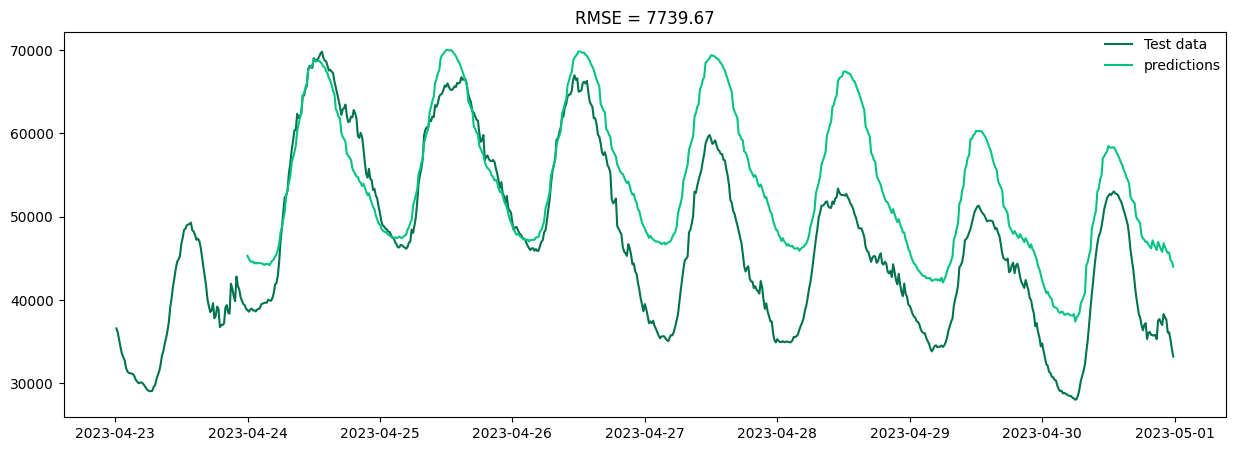

In [28]:
# Figure 35: One week predictions using a rolling window evaluation, on models
# with four time features.

fig, ax = plt.subplots(figsize=(15.,5.))

plt.title('RMSE = '+ "{:.2f}".format(rmse))
ax.plot(ener_all[ener_all.index>train_end_date].index,ener_all[ener_all.index>train_end_date][target],label='Test data',c=colors[0])
ax.plot(predictions.index,predictions[target],label='predictions',c=colors[1])
plt.legend(loc='best', borderaxespad=0.,frameon=False)
plt.show()


In [29]:
# Creating a series of XGBoost models to perform a rolling window validation,
# using seven time features

features = ['hour','minute','month','dayofweek','quarter','dayofyear','year']
target = 'Total electricity generated'
train_start_date='01-01-2020'
train_end_date='04-23-2023'
test_end_date='04-30-2023'

predictions, rmse = rolling_window_validation(ener_all,features,target,
                                              train_start_date = train_start_date,
                                              train_end_date = train_end_date,
                                              test_end_date = test_end_date,
                                              verbose=True)


The test window length is 1209 days 00:00:00
The test window length is 7 days 00:00:00
Predictions are as follows:
Time, test value, predicted value
2023-04-24 00:00:00 38796.0 40217.38
2023-04-24 00:15:00 38602.0 38489.098
2023-04-24 00:30:00 38861.0 38482.586
2023-04-24 00:45:00 38972.0 38338.203
2023-04-24 01:00:00 38750.0 38194.76
2023-04-24 01:15:00 38768.0 38303.086
2023-04-24 01:30:00 38631.0 38543.99
2023-04-24 01:45:00 38868.0 38611.562
2023-04-24 02:00:00 38921.0 38269.914
2023-04-24 02:15:00 39050.0 38588.305
2023-04-24 02:30:00 39493.0 38425.99
2023-04-24 02:45:00 39576.0 38578.598
2023-04-24 03:00:00 39641.0 38868.555
2023-04-24 03:15:00 39708.0 38930.83
2023-04-24 03:30:00 39671.0 39022.438
2023-04-24 03:45:00 40040.0 39089.875
2023-04-24 04:00:00 39961.0 38587.312
2023-04-24 04:15:00 39904.0 38938.074
2023-04-24 04:30:00 40210.0 39221.81
2023-04-24 04:45:00 40821.0 39365.43
2023-04-24 05:00:00 41871.0 40190.855
2023-04-24 05:15:00 42039.0 40919.902
2023-04-24 05:30:00 42

2023-04-26 05:45:00 48120.0 47482.004
2023-04-26 06:00:00 48366.0 49093.14
2023-04-26 06:15:00 49513.0 49685.184
2023-04-26 06:30:00 50828.0 50712.496
2023-04-26 06:45:00 52105.0 51407.99
2023-04-26 07:00:00 53937.0 54639.996
2023-04-26 07:15:00 55358.0 55108.215
2023-04-26 07:30:00 56144.0 55922.34
2023-04-26 07:45:00 56878.0 56779.336
2023-04-26 08:00:00 59262.0 58730.465
2023-04-26 08:15:00 59396.0 59826.766
2023-04-26 08:30:00 60117.0 60384.395
2023-04-26 08:45:00 60695.0 60976.293
2023-04-26 09:00:00 61849.0 62097.812
2023-04-26 09:15:00 62070.0 62712.934
2023-04-26 09:30:00 63144.0 63852.652
2023-04-26 09:45:00 63546.0 64168.82
2023-04-26 10:00:00 64420.0 66340.695
2023-04-26 10:15:00 64653.0 66536.47
2023-04-26 10:30:00 64672.0 67169.84
2023-04-26 10:45:00 65091.0 66950.62
2023-04-26 11:00:00 66419.0 68630.1
2023-04-26 11:15:00 66976.0 68944.06
2023-04-26 11:30:00 66422.0 69157.15
2023-04-26 11:45:00 66599.0 69048.88
2023-04-26 12:00:00 65010.0 68939.25
2023-04-26 12:15:00 65059

2023-04-28 12:15:00 52521.0 56748.586
2023-04-28 12:30:00 52739.0 56730.152
2023-04-28 12:45:00 52342.0 56007.72
2023-04-28 13:00:00 52061.0 55229.66
2023-04-28 13:15:00 51591.0 55289.207
2023-04-28 13:30:00 51321.0 55318.477
2023-04-28 13:45:00 50932.0 54286.805
2023-04-28 14:00:00 50296.0 55031.918
2023-04-28 14:15:00 49897.0 54110.465
2023-04-28 14:30:00 49235.0 53004.08
2023-04-28 14:45:00 48613.0 52745.133
2023-04-28 15:00:00 48611.0 52601.434
2023-04-28 15:15:00 48597.0 51442.535
2023-04-28 15:30:00 48135.0 51038.555
2023-04-28 15:45:00 47613.0 50427.6
2023-04-28 16:00:00 46409.0 48794.918
2023-04-28 16:15:00 45929.0 48162.496
2023-04-28 16:30:00 45759.0 47954.94
2023-04-28 16:45:00 45166.0 47407.69
2023-04-28 17:00:00 44592.0 46726.754
2023-04-28 17:15:00 45097.0 45746.55
2023-04-28 17:30:00 45289.0 46336.633
2023-04-28 17:45:00 45224.0 45766.566
2023-04-28 18:00:00 44470.0 44933.727
2023-04-28 18:15:00 44641.0 43776.953
2023-04-28 18:30:00 45294.0 43944.008
2023-04-28 18:45:00 

2023-04-30 18:45:00 37225.0 40223.684
2023-04-30 19:00:00 35332.0 40546.7
2023-04-30 19:15:00 36048.0 39492.7
2023-04-30 19:30:00 36172.0 39719.625
2023-04-30 19:45:00 35819.0 39295.266
2023-04-30 20:00:00 35774.0 39637.69
2023-04-30 20:15:00 35747.0 38963.35
2023-04-30 20:30:00 35820.0 39707.67
2023-04-30 20:45:00 35301.0 38641.58
2023-04-30 21:00:00 37546.0 39470.543
2023-04-30 21:15:00 37712.0 38990.508
2023-04-30 21:30:00 37286.0 38196.89
2023-04-30 21:45:00 37002.0 38168.188
2023-04-30 22:00:00 38308.0 38702.617
2023-04-30 22:15:00 37948.0 37747.92
2023-04-30 22:30:00 37654.0 37793.062
2023-04-30 22:45:00 36107.0 37514.656
2023-04-30 23:00:00 36118.0 36928.688
2023-04-30 23:15:00 35233.0 36382.04
2023-04-30 23:30:00 34142.0 35913.727
2023-04-30 23:45:00 33221.0 35587.812


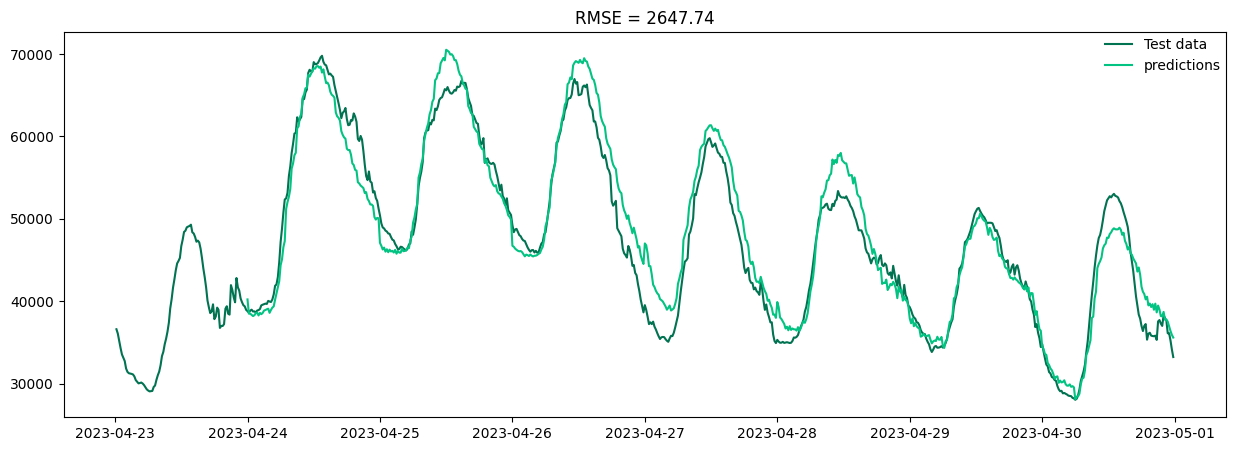

In [30]:
# Figure 36: One week predictions using a rolling window evaluation, on models
# with seven time features.

fig, ax = plt.subplots(figsize=(15.,5.))

plt.title('RMSE = '+ "{:.2f}".format(rmse))
ax.plot(ener_all[ener_all.index>train_end_date].index,ener_all[ener_all.index>train_end_date][target],label='Test data',c=colors[0])
#ax.set_xlim('2022-05-01','2022-05-31')
ax.plot(predictions.index,predictions[target],label='predictions',c=colors[1])
#ax.set_ylim(0,300)
plt.legend(loc='best', borderaxespad=0.,frameon=False)
#plt.title('Price of the second auction compared to the ML prediction during May 2022')
#ax.axvline('2022-03-01',color='black',linestyle='--')
plt.show()


In [32]:
ener_all = add_lags(ener_all,5)
ener_2023 = add_lags(ener_2023,5)
ener_past = add_lags(ener_past,5)
ener_all

Area  Biomass  - Actual Aggregated [MW]   
MTU                                                                    
2020-01-01 01:15:00  Germany (DE)                             4877.0  \
2020-01-01 01:30:00  Germany (DE)                             4886.0   
2020-01-01 01:45:00  Germany (DE)                             4896.0   
2020-01-01 02:00:00  Germany (DE)                             4897.0   
2020-01-01 02:15:00  Germany (DE)                             4889.0   
...                           ...                                ...   
2023-04-30 22:45:00  Germany (DE)                             4636.0   
2023-04-30 23:00:00  Germany (DE)                             4644.0   
2023-04-30 23:15:00  Germany (DE)                             4650.0   
2023-04-30 23:30:00  Germany (DE)                             4659.0   
2023-04-30 23:45:00  Germany (DE)                             4637.0   

                     Biomass  - Actual Consumption [MW]   
MTU                                                       
2020-01-01 01:15:00                                 NaN  \
2020-01-01 01:30:00                                 NaN   
2020-01-01 01:45:00                                 NaN   
2020-01-01 02:00:00                                 NaN   
2020-01-01 02:15:00                                 NaN   
...                                                 ...   
2023-04-30 22:45:00                                 NaN   
2023-04-30 23:00:00                                 NaN   
2023-04-30 23:15:00                                 NaN   
2023-04-30 23:30:00                                 NaN   
2023-04-30 23:45:00                                 NaN   

                     Fossil Brown coal/Lignite  - Actual Aggregated [MW]   
MTU                                                                        
2020-01-01 01:15:00                                             9422.0    \
2020-01-01 01:30:00                                             9421.0     
2020-01-01 01:45:00                                             9425.0     
2020-01-01 02:00:00                                             9455.0     
2020-01-01 02:15:00                                             9403.0     
...                                                                ...     
2023-04-30 22:45:00                                             9973.0     
2023-04-30 23:00:00                                             9863.0     
2023-04-30 23:15:00                                             9849.0     
2023-04-30 23:30:00                                             9830.0     
2023-04-30 23:45:00                                             9811.0     

                     Fossil Brown coal/Lignite  - Actual Consumption [MW]   
MTU                                                                         
2020-01-01 01:15:00                                                NaN     \
2020-01-01 01:30:00                                                NaN      
2020-01-01 01:45:00                                                NaN      
2020-01-01 02:00:00                                                NaN      
2020-01-01 02:15:00                                                NaN      
...                                                                ...      
2023-04-30 22:45:00                                                NaN      
2023-04-30 23:00:00                                                NaN      
2023-04-30 23:15:00                                                NaN      
2023-04-30 23:30:00                                                NaN      
2023-04-30 23:45:00                                                NaN      

                     Fossil Coal-derived gas  - Actual Aggregated [MW]   
MTU                                                                      
2020-01-01 01:15:00                                                0.0  \
2020-01-01 01:30:00                                                0.0   
2020-01-01 01:45:00                  

In [34]:
# Creating a series of XGBoost models to perform a rolling window validation,
# using six time features, and lags of the previous six consecutive time steps.

features = ['hour','month','dayofweek','quarter','dayofyear','year']+['lag_'+str(i) for i in range(1,6)]
target = 'Total electricity generated'
train_start_date='01-02-2020'
train_end_date='04-23-2023'
test_end_date='04-30-2023'

predictions, rmse = rolling_window_validation(ener_all,features,target,
                                              train_start_date = train_start_date,
                                              train_end_date = train_end_date,
                                              test_end_date = test_end_date,
                                              verbose=True)


The test window length is 1208 days 00:00:00
The test window length is 7 days 00:00:00
Predictions are as follows:
Time, test value, predicted value
2023-04-24 00:00:00 38796.0 38588.152
2023-04-24 00:15:00 38602.0 38603.715
2023-04-24 00:30:00 38861.0 38405.848
2023-04-24 00:45:00 38972.0 38638.97
2023-04-24 01:00:00 38750.0 38819.24
2023-04-24 01:15:00 38768.0 38806.914
2023-04-24 01:30:00 38631.0 38820.574
2023-04-24 01:45:00 38868.0 38627.74
2023-04-24 02:00:00 38921.0 38813.887
2023-04-24 02:15:00 39050.0 38854.4
2023-04-24 02:30:00 39493.0 39122.977
2023-04-24 02:45:00 39576.0 39708.926
2023-04-24 03:00:00 39641.0 39713.37
2023-04-24 03:15:00 39708.0 39748.36
2023-04-24 03:30:00 39671.0 39724.574
2023-04-24 03:45:00 40040.0 39727.035
2023-04-24 04:00:00 39961.0 40141.125
2023-04-24 04:15:00 39904.0 40109.395
2023-04-24 04:30:00 40210.0 39980.777
2023-04-24 04:45:00 40821.0 40330.76
2023-04-24 05:00:00 41871.0 41250.96
2023-04-24 05:15:00 42039.0 42758.08
2023-04-24 05:30:00 42936

2023-04-26 05:45:00 48120.0 47893.02
2023-04-26 06:00:00 48366.0 49152.113
2023-04-26 06:15:00 49513.0 49221.2
2023-04-26 06:30:00 50828.0 50566.48
2023-04-26 06:45:00 52105.0 51983.438
2023-04-26 07:00:00 53937.0 53196.133
2023-04-26 07:15:00 55358.0 55188.906
2023-04-26 07:30:00 56144.0 56650.4
2023-04-26 07:45:00 56878.0 57338.195
2023-04-26 08:00:00 59262.0 58028.457
2023-04-26 08:15:00 59396.0 60228.387
2023-04-26 08:30:00 60117.0 60320.79
2023-04-26 08:45:00 60695.0 60933.0
2023-04-26 09:00:00 61849.0 61665.85
2023-04-26 09:15:00 62070.0 62534.38
2023-04-26 09:30:00 63144.0 62790.746
2023-04-26 09:45:00 63546.0 63805.535
2023-04-26 10:00:00 64420.0 64304.75
2023-04-26 10:15:00 64653.0 65011.355
2023-04-26 10:30:00 64672.0 65232.23
2023-04-26 10:45:00 65091.0 65086.21
2023-04-26 11:00:00 66419.0 65457.69
2023-04-26 11:15:00 66976.0 66845.34
2023-04-26 11:30:00 66422.0 67484.984
2023-04-26 11:45:00 66599.0 66845.27
2023-04-26 12:00:00 65010.0 66619.56
2023-04-26 12:15:00 65059.0 64

2023-04-28 12:30:00 52739.0 52416.277
2023-04-28 12:45:00 52342.0 52615.113
2023-04-28 13:00:00 52061.0 52098.953
2023-04-28 13:15:00 51591.0 51719.43
2023-04-28 13:30:00 51321.0 51302.69
2023-04-28 13:45:00 50932.0 50912.45
2023-04-28 14:00:00 50296.0 50680.062
2023-04-28 14:15:00 49897.0 49847.15
2023-04-28 14:30:00 49235.0 49512.613
2023-04-28 14:45:00 48613.0 48823.215
2023-04-28 15:00:00 48611.0 48241.984
2023-04-28 15:15:00 48597.0 48306.793
2023-04-28 15:30:00 48135.0 48159.668
2023-04-28 15:45:00 47613.0 47788.336
2023-04-28 16:00:00 46409.0 47232.75
2023-04-28 16:15:00 45929.0 45975.93
2023-04-28 16:30:00 45759.0 45480.4
2023-04-28 16:45:00 45166.0 45263.21
2023-04-28 17:00:00 44592.0 44916.164
2023-04-28 17:15:00 45097.0 44140.46
2023-04-28 17:30:00 45289.0 44876.49
2023-04-28 17:45:00 45224.0 45104.26
2023-04-28 18:00:00 44470.0 45032.83
2023-04-28 18:15:00 44641.0 44328.37
2023-04-28 18:30:00 45294.0 44507.844
2023-04-28 18:45:00 45604.0 45194.277
2023-04-28 19:00:00 44403.

2023-04-30 19:15:00 36048.0 35456.098
2023-04-30 19:30:00 36172.0 35989.492
2023-04-30 19:45:00 35819.0 36218.438
2023-04-30 20:00:00 35774.0 35888.816
2023-04-30 20:15:00 35747.0 35950.367
2023-04-30 20:30:00 35820.0 35808.453
2023-04-30 20:45:00 35301.0 35844.79
2023-04-30 21:00:00 37546.0 36043.66
2023-04-30 21:15:00 37712.0 37664.5
2023-04-30 21:30:00 37286.0 37817.48
2023-04-30 21:45:00 37002.0 37451.84
2023-04-30 22:00:00 38308.0 37388.887
2023-04-30 22:15:00 37948.0 38173.543
2023-04-30 22:30:00 37654.0 37541.85
2023-04-30 22:45:00 36107.0 37289.418
2023-04-30 23:00:00 36118.0 36053.37
2023-04-30 23:15:00 35233.0 35686.96
2023-04-30 23:30:00 34142.0 34784.11
2023-04-30 23:45:00 33221.0 33633.27


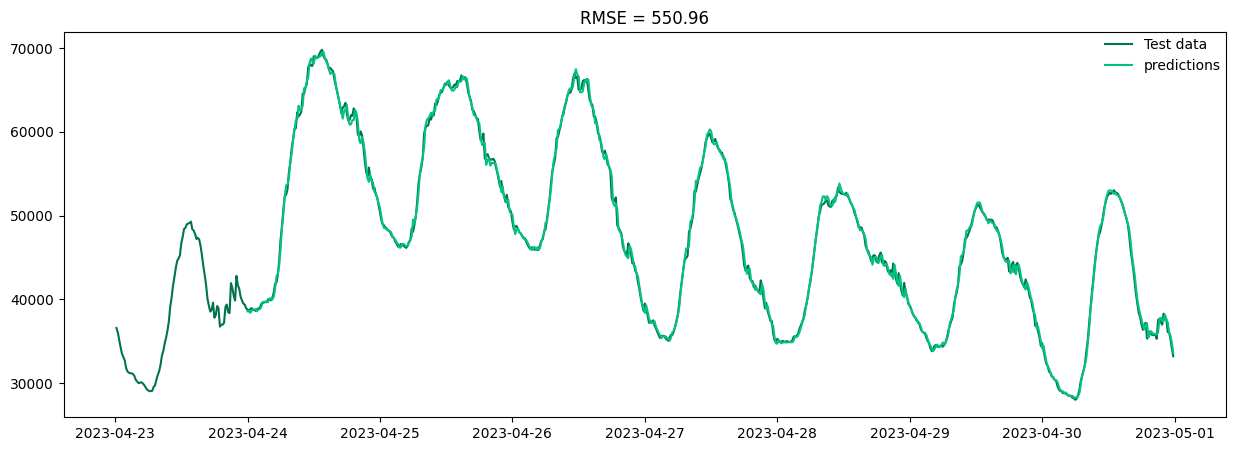

In [35]:
# Figure 37: One week predictions using a rolling window evaluation, on models
# with six time features and six lags.

fig, ax = plt.subplots(figsize=(15.,5.))

plt.title('RMSE = '+ "{:.2f}".format(rmse))
ax.plot(ener_all[ener_all.index>train_end_date].index,ener_all[ener_all.index>train_end_date][target],label='Test data',c=colors[0])
ax.plot(predictions.index,predictions[target],label='predictions',c=colors[1])
plt.legend(loc='best', borderaxespad=0.,frameon=False)
plt.show()


As shown in Fig. 37, adding the lags results in a huge improvement of the model! Next steps might include adding weather data (and perhaps other freely available data), to be able to better capture the finer details of energy trends. Also, hyperparameter tuning may improve the predictions and I will do that in the near future as well. Finally, I will also add different time-series models besides the one used here from XGBoost.